# Python Notebook

In [2]:
## Function to prepare datatables (cleaning and hyperlinking, adding tool tips, etc) input for the database qmds
import sys, os
import pandas as pd
# Change working directory to ConnectomeDB
project_root = "/Users/sakuramaezono/Library/CloudStorage/OneDrive-YokohamaCityUniversity/Personal/05_Python_repositories/ConnectomeDB"
os.chdir(project_root)
sys.path.append(os.path.abspath("src"))

In [3]:
import scanpy as sc
import anndata
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import scanpy as sc
import re

output_dir = "data/tabula_sapiens/"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir +"umap" , exist_ok=True)
os.makedirs(output_dir +"heatmap" , exist_ok=True)

output_file = "data/tissue_dataset.h5ad"

if os.path.exists(output_file):
    # Do only if the file exists
    print("File exists. Proceeding with the task.")

    # Rest of the logic that should only run if file exists
else:
    url = "https://datasets.cellxgene.cziscience.com/9daa676b-07ec-4cea-80aa-daa49200aa64.h5ad"
    #Tabula Sapiens is a benchmark, first-draft human cell atlas of over 1.1M cells from 28 organs of 24 normal human subjects. This work is the product of the Tabula Sapiens Consortium. Taking the organs from the same individual controls for genetic background, age, environment, and epigenetic effects, and allows detailed analysis and comparison of cell types that are shared between tissues.
    # Get file size for progress bar
    response = requests.head(url)
    total_size = int(response.headers.get('Content-Length', 0))
    
    # Stream download with tqdm
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_file, 'wb') as f, tqdm(
            total=total_size, unit='B', unit_scale=True, desc=output_file
        ) as pbar:
            for chunk in r.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))
                    
# Load with scanpy
adata = sc.read_h5ad(output_file)
print(adata)
print(adata.obs.columns) 
print(adata.var_names)    # Gene names

File exists. Proceeding with the task.
AnnData object with n_obs × n_vars = 1136218 × 61759
    obs: 'donor_id', 'tissue_in_publication', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'assay_ontology_term_id', 'sample_id', 'replicate', '10X_run', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_type_ontology_term_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'ethnicity_original', 'sample_number', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism',

In [4]:
import pandas as pd
import re
from createDataTable import gene_pair0, pop_up_info

# Build HGNC-to-Ensembl mapping
ensembl_id = dict(zip(pop_up_info['HGNC ID'], pop_up_info['ensembl_gene_id']))

# Define HGNC ID extractor
def extract_hgnc_id(text):
    if pd.isna(text): return None
    match = re.search(r'(HGNC:\d+)', str(text))
    return match.group(1) if match else None

# --- Prepare ligand dataframe ---
ligand_df = gene_pair0[['Ligand', 'Ligand HGNC ID']].copy()
ligand_df.columns = ['gene_symbol', 'hgnc_id']  # Standardize column names

# --- Prepare receptor dataframe ---
receptor_df = gene_pair0[['Receptor', 'Receptor HGNC ID']].copy()
receptor_df.columns = ['gene_symbol', 'hgnc_id']

# Combine both
gene_pair_input = pd.concat([ligand_df, receptor_df], ignore_index=True)

# Extract clean HGNC IDs
gene_pair_input['hgnc_id'] = gene_pair_input['hgnc_id'].apply(extract_hgnc_id)

# Map to Ensembl IDs
gene_pair_input['ensembl_id'] = gene_pair_input['hgnc_id'].map(ensembl_id)

# Drop duplicates and NaNs if needed
gene_pair_input = gene_pair_input.drop_duplicates().dropna(subset=['ensembl_id'])

# Final output
print(gene_pair_input.head())


/Users/sakuramaezono/Library/CloudStorage/OneDrive-YokohamaCityUniversity/Personal/05_Python_repositories/ConnectomeDB/src/createDataTable.py:26: DtypeWarning: Columns (32,34,38,40,50) have mixed types. Specify dtype option on import or set low_memory=False.
  pop_up_info = pd.read_table("data/HGNC_gene_info_full.tsv")


  gene_symbol    hgnc_id       ensembl_id
0         A2M     HGNC:7  ENSG00000175899
2         ACE  HGNC:2707  ENSG00000159640
3         ADA   HGNC:186  ENSG00000196839
4      ADAM10   HGNC:188  ENSG00000137845
6      ADAM11   HGNC:189  ENSG00000073670


In [23]:
# --- Imports ---
import os
import numpy as np
import pandas as pd
from scipy.sparse import issparse, csr_matrix
import plotly.express as px
from joblib import Parallel, delayed
from tqdm import tqdm
# --- Ensure Output Directories Exist ---
os.makedirs(f"{output_dir}heatmap", exist_ok=True)
os.makedirs(f"{output_dir}umap", exist_ok=True)

# --- Annotations ---
tissues = adata.obs["tissue_in_publication"].astype(str).values
cell_types = adata.obs["cell_type"].astype(str).values
assert len(tissues) == adata.n_obs, "Tissue annotation length mismatch"
assert len(cell_types) == adata.n_obs, "Cell type annotation length mismatch"

# --- Gene Lists and Labels ---
gene_id_list = gene_pair_input["ensembl_id"].tolist()

# --- Limit to First Few for Testing ---
test_mode = False  # ← change to True if testing
max_genes = 3 if test_mode else None
if test_mode:
    gene_id_list = gene_id_list[:max_genes]

# Strip versions from gene IDs if needed
def strip_version(gid):
    return gid.split(".")[0] if "." in gid else gid

gene_id_list_stripped = [strip_version(g) for g in gene_id_list]
gene_label_map = dict(zip(gene_id_list_stripped,
                          gene_pair_input.set_index("ensembl_id").loc[gene_id_list]["gene_symbol"].values))


# --- Precompute Scaled Expression ---
def precompute_scaled_expression(adata, gene_id_list):
    if "scale_data" not in adata.layers:
        raise ValueError("Layer 'scale_data' not found in adata.")

    X = adata.layers["scale_data"]  # shape: cells x genes
    var_names_stripped = [strip_version(g) for g in adata.var_names]
    gene_indices = {gene_id: i for i, gene_id in enumerate(var_names_stripped)}

    gene_expr_map = {}
    missing_genes = []

    for gene_id in tqdm(gene_id_list, desc="Precomputing scaled expression"):
        if gene_id not in gene_indices:
            missing_genes.append(gene_id)
            continue
        i = gene_indices[gene_id]
        x = X[:, i]  # ✅ not transposed
        expr = x.toarray().flatten() if hasattr(x, "toarray") else x.flatten()
        gene_expr_map[gene_id] = expr

    print(f"[✓] Precomputed expression for {len(gene_expr_map)} genes.")
    if missing_genes:
        print(f"[!] Skipped {len(missing_genes)} genes not found in adata.var_names.")

    return gene_expr_map, missing_genes

gene_expr_map, _ = precompute_scaled_expression(adata, gene_id_list_stripped)

# --- Plot Function ---
def plot_gene_umap_expression(adata, gene_id, gene_name, output_dir, gene_expr_map=None):
    try:
        if gene_expr_map and gene_id in gene_expr_map:
            expr = gene_expr_map[gene_id]
        else:
            if gene_id not in adata.var_names:
                print(f"[!] {gene_id} not in adata.var_names")
                return
            expr_data = adata[:, gene_id].X
            expr = expr_data.toarray().flatten() if issparse(expr_data) else expr_data.flatten()

        df = pd.DataFrame(adata.obsm["X_umap"], columns=["UMAP1", "UMAP2"])
        df["expression"] = expr
        df["tissue"] = tissues
        df["cell_type"] = cell_types

        fig = px.scatter(
            df,
            x="UMAP1", y="UMAP2",
            color="expression",
            color_continuous_scale="viridis",
            title=f"{gene_name} Expression on UMAP",
            width=600, height=600,
            render_mode="webgl",
            custom_data=["tissue", "cell_type"]
        )

        fig.update_traces(marker=dict(size=3), hovertemplate="<br>".join([
            "Tissue: %{customdata[0]}",
            "Cell type: %{customdata[1]}",
            "Expression: %{marker.color:.2f}"
        ]))

        fig.update_layout(
            plot_bgcolor='white',
            paper_bgcolor='white',
            legend_title="Expr",
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
        )

        out_path = os.path.join(output_dir, "umap", f"{gene_name}.html")
        fig.write_html(out_path, include_plotlyjs="cdn")
        del fig  # free memory
        print(f"[✓] UMAP written: {out_path}")
    except Exception as e:
        print(f"[✗] Error plotting {gene_name} ({gene_id}): {e}")
        

Precomputing scaled expression: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1648/1648 [8:40:18<00:00, 18.94s/it]

[✓] Precomputed expression for 1644 genes.
[!] Skipped 4 genes not found in adata.var_names.


In [24]:
# --- Wrapper for Parallel Execution ---
def generate_umap_wrapper(gene_id_original):
    gene_id = strip_version(gene_id_original)
    gene_label = gene_label_map.get(gene_id, gene_id)
    plot_gene_umap_expression(adata, gene_id, gene_label, output_dir, gene_expr_map)
# --- Run in Parallel ---
Parallel(n_jobs=16, backend="threading")(
    delayed(generate_umap_wrapper)(gene_id)
    for gene_id in tqdm(gene_id_list, desc="Generating UMAPs")
)


Generating UMAPs:   0%|                                                                                                                           | 0/1648 [00:00<?, ?it/s]

[✓] UMAP written: data/tabula_sapiens/umap/ADAM12.html


Generating UMAPs:   2%|██▎                                                                                                               | 33/1648 [00:31<28:33,  1.06s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ADAM11.html
[✓] UMAP written: data/tabula_sapiens/umap/ADAM17.html
[✓] UMAP written: data/tabula_sapiens/umap/ADA.html
[✓] UMAP written: data/tabula_sapiens/umap/ADAM9.html
[✓] UMAP written: data/tabula_sapiens/umap/ADAM29.html
[✓] UMAP written: data/tabula_sapiens/umap/ADAM15.html
[✓] UMAP written: data/tabula_sapiens/umap/ADAMTS13.html
[✓] UMAP written: data/tabula_sapiens/umap/A2M.html


Generating UMAPs:   2%|██▍                                                                                                               | 35/1648 [00:38<38:11,  1.42s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ADAM28.html
[✓] UMAP written: data/tabula_sapiens/umap/ADAM7.html
[✓] UMAP written: data/tabula_sapiens/umap/ADAM10.html
[✓] UMAP written: data/tabula_sapiens/umap/ADAM23.html
[✓] UMAP written: data/tabula_sapiens/umap/ACE.html
[✓] UMAP written: data/tabula_sapiens/umap/ADAM2.html


Generating UMAPs:   2%|██▋                                                                                                               | 38/1648 [00:43<41:48,  1.56s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ADAMTS1.html


Generating UMAPs:   3%|███▏                                                                                                            | 46/1648 [01:07<1:50:08,  4.12s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ADGRB1.html
[✓] UMAP written: data/tabula_sapiens/umap/ADCYAP1.html
[✓] UMAP written: data/tabula_sapiens/umap/AGRP.html
[✓] UMAP written: data/tabula_sapiens/umap/ADM.html


Generating UMAPs:   3%|███▎                                                                                                            | 48/1648 [01:15<1:54:53,  4.31s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ADGRL1.html[✓] UMAP written: data/tabula_sapiens/umap/ADGRG1.html
[✓] UMAP written: data/tabula_sapiens/umap/AGRN.html
[✓] UMAP written: data/tabula_sapiens/umap/ADIPOQ.html
[✓] UMAP written: data/tabula_sapiens/umap/AGGF1.html

[✓] UMAP written: data/tabula_sapiens/umap/ALB.html
[✓] UMAP written: data/tabula_sapiens/umap/ADGRE5.html
[✓] UMAP written: data/tabula_sapiens/umap/AGR2.html
[✓] UMAP written: data/tabula_sapiens/umap/AGT.html


Generating UMAPs:   3%|███▌                                                                                                              | 51/1648 [01:16<48:24,  1.82s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ADM2.html
[✓] UMAP written: data/tabula_sapiens/umap/AHSG.html


Generating UMAPs:   3%|███▋                                                                                                              | 54/1648 [01:22<48:51,  1.84s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ALCAM.html


Generating UMAPs:   4%|████▍                                                                                                           | 65/1648 [01:51<2:11:56,  5.00s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ANGPT1.html[✓] UMAP written: data/tabula_sapiens/umap/ALKAL1.html
[✓] UMAP written: data/tabula_sapiens/umap/AMBN.html

[✓] UMAP written: data/tabula_sapiens/umap/ANGPT2.html
[✓] UMAP written: data/tabula_sapiens/umap/ALKAL2.html
[✓] UMAP written: data/tabula_sapiens/umap/ANGPTL5.html
[✓] UMAP written: data/tabula_sapiens/umap/ANGPTL2.html
[✓] UMAP written: data/tabula_sapiens/umap/ANGPT4.html
[✓] UMAP written: data/tabula_sapiens/umap/ANGPTL3.html
[✓] UMAP written: data/tabula_sapiens/umap/AMELY.html
[✓] UMAP written: data/tabula_sapiens/umap/ANGPTL4.html
[✓] UMAP written: data/tabula_sapiens/umap/AMH.html
[✓] UMAP written: data/tabula_sapiens/umap/ANG.html
[✓] UMAP written: data/tabula_sapiens/umap/AMELX.html


Generating UMAPs:   4%|████▋                                                                                                           | 69/1648 [01:58<1:05:49,  2.50s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ANGPTL1.html
[✓] UMAP written: data/tabula_sapiens/umap/ANGPTL7.html


Generating UMAPs:   5%|█████▌                                                                                                          | 82/1648 [02:31<1:53:42,  4.36s/it]

[✓] UMAP written: data/tabula_sapiens/umap/APLN.html
[✓] UMAP written: data/tabula_sapiens/umap/ANOS1.html
[✓] UMAP written: data/tabula_sapiens/umap/APELA.html
[✓] UMAP written: data/tabula_sapiens/umap/APOD.html
[✓] UMAP written: data/tabula_sapiens/umap/ANXA1.html
[✓] UMAP written: data/tabula_sapiens/umap/APOA2.html
[✓] UMAP written: data/tabula_sapiens/umap/APLP2.html
[✓] UMAP written: data/tabula_sapiens/umap/APOE.html
[✓] UMAP written: data/tabula_sapiens/umap/ANXA2.html
[✓] UMAP written: data/tabula_sapiens/umap/ANPEP.html
[✓] UMAP written: data/tabula_sapiens/umap/APLP1.html
[✓] UMAP written: data/tabula_sapiens/umap/APOB.html
[✓] UMAP written: data/tabula_sapiens/umap/APOC3.html
[✓] UMAP written: data/tabula_sapiens/umap/APOA1.html


Generating UMAPs:   5%|█████▉                                                                                                            | 86/1648 [02:38<59:59,  2.30s/it]

[✓] UMAP written: data/tabula_sapiens/umap/APP.html


Generating UMAPs:   5%|██████▏                                                                                                           | 90/1648 [02:42<32:48,  1.26s/it]

[✓] UMAP written: data/tabula_sapiens/umap/AREG.html


Generating UMAPs:   6%|██████▌                                                                                                           | 94/1648 [02:50<47:42,  1.84s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ASGR1.html
[✓] UMAP written: data/tabula_sapiens/umap/ARTN.html


Generating UMAPs:   6%|██████▌                                                                                                           | 95/1648 [02:51<46:17,  1.79s/it]

[✓] UMAP written: data/tabula_sapiens/umap/AZGP1.html


Generating UMAPs:   6%|██████▋                                                                                                         | 98/1648 [03:07<1:32:37,  3.59s/it]

[✓] UMAP written: data/tabula_sapiens/umap/AVP.html
[✓] UMAP written: data/tabula_sapiens/umap/BGLAP.html
[✓] UMAP written: data/tabula_sapiens/umap/BGN.html
[✓] UMAP written: data/tabula_sapiens/umap/BAG6.html
[✓] UMAP written: data/tabula_sapiens/umap/B2M.html
[✓] UMAP written: data/tabula_sapiens/umap/BMP15.html
[✓] UMAP written: data/tabula_sapiens/umap/ASIP.html


Generating UMAPs:   6%|██████▉                                                                                                          | 102/1648 [03:15<58:30,  2.27s/it]

[✓] UMAP written: data/tabula_sapiens/umap/BDNF.html
[✓] UMAP written: data/tabula_sapiens/umap/BMP2.html
[✓] UMAP written: data/tabula_sapiens/umap/BMP10.html
[✓] UMAP written: data/tabula_sapiens/umap/BMP3.html


Generating UMAPs:   6%|███████▏                                                                                                         | 105/1648 [03:21<44:11,  1.72s/it]

[✓] UMAP written: data/tabula_sapiens/umap/BMP4.html
[✓] UMAP written: data/tabula_sapiens/umap/BMP5.html


Generating UMAPs:   7%|███████▌                                                                                                       | 113/1648 [03:37<1:10:22,  2.75s/it]

[✓] UMAP written: data/tabula_sapiens/umap/BMP6.html
[✓] UMAP written: data/tabula_sapiens/umap/BST2.html
[✓] UMAP written: data/tabula_sapiens/umap/BSG.html
[✓] UMAP written: data/tabula_sapiens/umap/C1QC.html


Generating UMAPs:   7%|███████▊                                                                                                       | 116/1648 [03:49<1:23:25,  3.27s/it]

[✓] UMAP written: data/tabula_sapiens/umap/C1QL1.html
[✓] UMAP written: data/tabula_sapiens/umap/BMP7.html
[✓] UMAP written: data/tabula_sapiens/umap/BTC.html
[✓] UMAP written: data/tabula_sapiens/umap/C1QL3.html
[✓] UMAP written: data/tabula_sapiens/umap/C1QB.html
[✓] UMAP written: data/tabula_sapiens/umap/BMP8A.html
[✓] UMAP written: data/tabula_sapiens/umap/BPI.html
[✓] UMAP written: data/tabula_sapiens/umap/C1QA.html


Generating UMAPs:   7%|███████▉                                                                                                       | 118/1648 [03:54<1:13:35,  2.89s/it]

[✓] UMAP written: data/tabula_sapiens/umap/BTLA.html
[✓] UMAP written: data/tabula_sapiens/umap/C1QL2.html


Generating UMAPs:   7%|████████▎                                                                                                        | 121/1648 [03:59<53:01,  2.08s/it]

[✓] UMAP written: data/tabula_sapiens/umap/C1QTNF3.html


Generating UMAPs:   8%|████████▌                                                                                                        | 124/1648 [04:03<39:45,  1.57s/it]

[✓] UMAP written: data/tabula_sapiens/umap/C1QL4.html


Generating UMAPs:   8%|████████▍                                                                                                      | 126/1648 [04:11<1:09:32,  2.74s/it]

[✓] UMAP written: data/tabula_sapiens/umap/C1QTNF5.html
[✓] UMAP written: data/tabula_sapiens/umap/C5.html
[✓] UMAP written: data/tabula_sapiens/umap/C1QTNF8.html


Generating UMAPs:   8%|████████▌                                                                                                      | 127/1648 [04:17<1:43:42,  4.09s/it]

[✓] UMAP written: data/tabula_sapiens/umap/C4B.html
[✓] UMAP written: data/tabula_sapiens/umap/CADM1.html
[✓] UMAP written: data/tabula_sapiens/umap/C4BPA.html
[✓] UMAP written: data/tabula_sapiens/umap/C1QTNF9.html


Generating UMAPs:   8%|████████▊                                                                                                      | 130/1648 [04:30<1:41:45,  4.02s/it]

[✓] UMAP written: data/tabula_sapiens/umap/C3.html
[✓] UMAP written: data/tabula_sapiens/umap/C4A.html
[✓] UMAP written: data/tabula_sapiens/umap/C9.html
[✓] UMAP written: data/tabula_sapiens/umap/CADM3.html
[✓] UMAP written: data/tabula_sapiens/umap/CADM2.html


Generating UMAPs:   8%|████████▊                                                                                                      | 131/1648 [04:30<1:14:50,  2.96s/it]

[✓] UMAP written: data/tabula_sapiens/umap/C8A.html
[✓] UMAP written: data/tabula_sapiens/umap/CADM4.html


Generating UMAPs:   8%|█████████▎                                                                                                       | 136/1648 [04:38<40:57,  1.63s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CALCA.html


Generating UMAPs:   8%|█████████▌                                                                                                       | 140/1648 [04:45<43:11,  1.72s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CALCB.html


Generating UMAPs:   9%|█████████▋                                                                                                     | 144/1648 [05:06<1:36:18,  3.84s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CCL1.html
[✓] UMAP written: data/tabula_sapiens/umap/CBLN1.html
[✓] UMAP written: data/tabula_sapiens/umap/CBLN4.html
[✓] UMAP written: data/tabula_sapiens/umap/CBLN2.html
[✓] UMAP written: data/tabula_sapiens/umap/CCL15.html
[✓] UMAP written: data/tabula_sapiens/umap/CBLIF.html
[✓] UMAP written: data/tabula_sapiens/umap/CCL14.html
[✓] UMAP written: data/tabula_sapiens/umap/CAMP.html
[✓] UMAP written: data/tabula_sapiens/umap/CALR.html
[✓] UMAP written: data/tabula_sapiens/umap/CCL11.html
[✓] UMAP written: data/tabula_sapiens/umap/CCK.html
[✓] UMAP written: data/tabula_sapiens/umap/CCL17.html
[!] ENSG00000277796 not in adata.var_names


Generating UMAPs:   9%|█████████▊                                                                                                     | 146/1648 [05:09<1:07:09,  2.68s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CCL13.html
[✓] UMAP written: data/tabula_sapiens/umap/CCL16.html


Generating UMAPs:   9%|██████████▍                                                                                                      | 153/1648 [05:17<27:56,  1.12s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CCL18.html
[✓] UMAP written: data/tabula_sapiens/umap/CCL19.html


Generating UMAPs:  10%|██████████▉                                                                                                    | 163/1648 [05:45<1:12:42,  2.94s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CCL24.html
[✓] UMAP written: data/tabula_sapiens/umap/CCL5.html
[✓] UMAP written: data/tabula_sapiens/umap/CCL20.html
[✓] UMAP written: data/tabula_sapiens/umap/CCL23.html
[✓] UMAP written: data/tabula_sapiens/umap/CCL28.html
[✓] UMAP written: data/tabula_sapiens/umap/CCL4.html
[✓] UMAP written: data/tabula_sapiens/umap/CCL21.html
[✓] UMAP written: data/tabula_sapiens/umap/CCL22.html
[✓] UMAP written: data/tabula_sapiens/umap/CCL27.html
[✓] UMAP written: data/tabula_sapiens/umap/CCL2.html
[✓] UMAP written: data/tabula_sapiens/umap/CCL3L3.html
[✓] UMAP written: data/tabula_sapiens/umap/CCL26.html


Generating UMAPs:  10%|███████████▍                                                                                                     | 167/1648 [05:51<43:05,  1.75s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CCL25.html
[✓] UMAP written: data/tabula_sapiens/umap/CCL3.html


Generating UMAPs:  10%|███████████▋                                                                                                     | 170/1648 [05:55<35:54,  1.46s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CCL7.html


Generating UMAPs:  11%|███████████▋                                                                                                   | 174/1648 [06:09<1:16:09,  3.10s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CCN3.html
[✓] UMAP written: data/tabula_sapiens/umap/CCN1.html
[✓] UMAP written: data/tabula_sapiens/umap/CD160.html
[✓] UMAP written: data/tabula_sapiens/umap/CCL8.html
[✓] UMAP written: data/tabula_sapiens/umap/CD1D.html
[✓] UMAP written: data/tabula_sapiens/umap/CCN2.html
[✓] UMAP written: data/tabula_sapiens/umap/CD177.html


Generating UMAPs:  11%|████████████                                                                                                   | 179/1648 [06:24<1:02:39,  2.56s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CD14.html
[✓] UMAP written: data/tabula_sapiens/umap/CD200.html
[✓] UMAP written: data/tabula_sapiens/umap/CCN4.html
[✓] UMAP written: data/tabula_sapiens/umap/CD2.html
[✓] UMAP written: data/tabula_sapiens/umap/CD209.html
[✓] UMAP written: data/tabula_sapiens/umap/CD22.html
[✓] UMAP written: data/tabula_sapiens/umap/CD200R1.html


Generating UMAPs:  11%|████████████                                                                                                   | 180/1648 [06:27<1:06:56,  2.74s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CD24.html
[✓] UMAP written: data/tabula_sapiens/umap/CD226.html


Generating UMAPs:  11%|████████████▋                                                                                                  | 189/1648 [06:47<1:17:01,  3.17s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CD244.html
[✓] UMAP written: data/tabula_sapiens/umap/CD28.html
[✓] UMAP written: data/tabula_sapiens/umap/CD274.html
[✓] UMAP written: data/tabula_sapiens/umap/CD47.html
[✓] UMAP written: data/tabula_sapiens/umap/CD38.html
[✓] UMAP written: data/tabula_sapiens/umap/CD34.html


Generating UMAPs:  12%|████████████▊                                                                                                  | 191/1648 [06:58<1:51:10,  4.58s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CD5.html
[✓] UMAP written: data/tabula_sapiens/umap/CD44.html
[✓] UMAP written: data/tabula_sapiens/umap/CD40LG.html
[✓] UMAP written: data/tabula_sapiens/umap/CD48.html
[✓] UMAP written: data/tabula_sapiens/umap/CD55.html
[✓] UMAP written: data/tabula_sapiens/umap/CD5L.html
[✓] UMAP written: data/tabula_sapiens/umap/CD59.html


Generating UMAPs:  12%|█████████████                                                                                                  | 194/1648 [07:05<1:02:54,  2.60s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CD58.html
[✓] UMAP written: data/tabula_sapiens/umap/CD6.html
[✓] UMAP written: data/tabula_sapiens/umap/CD52.html


Generating UMAPs:  13%|██████████████                                                                                                 | 208/1648 [07:25<1:21:43,  3.41s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CD96.html
[✓] UMAP written: data/tabula_sapiens/umap/CD8A.html
[✓] UMAP written: data/tabula_sapiens/umap/CDH4.html
[✓] UMAP written: data/tabula_sapiens/umap/CD86.html
[✓] UMAP written: data/tabula_sapiens/umap/CDH11.html


Generating UMAPs:  13%|██████████████▏                                                                                                | 210/1648 [07:41<2:04:29,  5.19s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CDCP1.html
[✓] UMAP written: data/tabula_sapiens/umap/CD70.html
[✓] UMAP written: data/tabula_sapiens/umap/CDH6.html
[✓] UMAP written: data/tabula_sapiens/umap/CD84.html
[✓] UMAP written: data/tabula_sapiens/umap/CDH10.html
[✓] UMAP written: data/tabula_sapiens/umap/CDH2.html
[✓] UMAP written: data/tabula_sapiens/umap/CDH3.html
[✓] UMAP written: data/tabula_sapiens/umap/CD80.html
[✓] UMAP written: data/tabula_sapiens/umap/CD99.html
[✓] UMAP written: data/tabula_sapiens/umap/CDH1.html


Generating UMAPs:  13%|██████████████▋                                                                                                  | 214/1648 [07:45<50:32,  2.11s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CD72.html


Generating UMAPs:  14%|███████████████▎                                                                                                 | 224/1648 [08:01<58:14,  2.45s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CEACAM6.html
[✓] UMAP written: data/tabula_sapiens/umap/CDH9.html
[✓] UMAP written: data/tabula_sapiens/umap/CEL.html
[✓] UMAP written: data/tabula_sapiens/umap/CEACAM8.html
[✓] UMAP written: data/tabula_sapiens/umap/CEACAM5.html


Generating UMAPs:  14%|███████████████▎                                                                                               | 227/1648 [08:18<1:35:29,  4.03s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CELSR3.html
[✓] UMAP written: data/tabula_sapiens/umap/CDH8.html
[✓] UMAP written: data/tabula_sapiens/umap/CFH.html
[✓] UMAP written: data/tabula_sapiens/umap/CEACAM16.html
[✓] UMAP written: data/tabula_sapiens/umap/CGA.html
[✓] UMAP written: data/tabula_sapiens/umap/CEMIP.html
[✓] UMAP written: data/tabula_sapiens/umap/CELSR2.html
[✓] UMAP written: data/tabula_sapiens/umap/CEACAM1.html
[✓] UMAP written: data/tabula_sapiens/umap/CFP.html


Generating UMAPs:  14%|███████████████▉                                                                                                 | 232/1648 [08:27<44:05,  1.87s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CGB3.html
[✓] UMAP written: data/tabula_sapiens/umap/CGB5.html


Generating UMAPs:  14%|███████████████▉                                                                                               | 237/1648 [08:41<1:24:52,  3.61s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CLCF1.html
[✓] UMAP written: data/tabula_sapiens/umap/CIRBP.html


Generating UMAPs:  14%|████████████████                                                                                               | 238/1648 [08:42<1:05:09,  2.77s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CKLF.html[✓] UMAP written: data/tabula_sapiens/umap/CLC.html

[✓] UMAP written: data/tabula_sapiens/umap/CGB8.html
[✓] UMAP written: data/tabula_sapiens/umap/CHAD.html


Generating UMAPs:  15%|████████████████▏                                                                                              | 240/1648 [08:53<1:43:30,  4.41s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CLEC2A.html
[✓] UMAP written: data/tabula_sapiens/umap/CLEC11A.html
[✓] UMAP written: data/tabula_sapiens/umap/CLEC2D.html
[✓] UMAP written: data/tabula_sapiens/umap/CLEC4G.html
[✓] UMAP written: data/tabula_sapiens/umap/CLEC1B.html


Generating UMAPs:  15%|█████████████████                                                                                                | 248/1648 [09:07<43:34,  1.87s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CLSTN3.html
[✓] UMAP written: data/tabula_sapiens/umap/CLEC4M.html
[✓] UMAP written: data/tabula_sapiens/umap/CLEC2B.html
[✓] UMAP written: data/tabula_sapiens/umap/CLU.html
[✓] UMAP written: data/tabula_sapiens/umap/CNIH2.html


Generating UMAPs:  15%|█████████████████▏                                                                                             | 255/1648 [09:28<1:45:55,  4.56s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CNTN2.html
[✓] UMAP written: data/tabula_sapiens/umap/COL10A1.html
[✓] UMAP written: data/tabula_sapiens/umap/CNTNAP1.html
[✓] UMAP written: data/tabula_sapiens/umap/COL11A2.html
[✓] UMAP written: data/tabula_sapiens/umap/CNTN4.html
[✓] UMAP written: data/tabula_sapiens/umap/CNTN3.html
[✓] UMAP written: data/tabula_sapiens/umap/CNTN6.html


Generating UMAPs:  16%|█████████████████▎                                                                                             | 257/1648 [09:33<1:24:43,  3.65s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CNTN5.html
[✓] UMAP written: data/tabula_sapiens/umap/CNTF.html
[✓] UMAP written: data/tabula_sapiens/umap/CNTN1.html
[✓] UMAP written: data/tabula_sapiens/umap/COL13A1.html


Generating UMAPs:  16%|█████████████████▍                                                                                             | 259/1648 [09:41<1:28:05,  3.81s/it]

[✓] UMAP written: data/tabula_sapiens/umap/COL11A1.html
[✓] UMAP written: data/tabula_sapiens/umap/COL17A1.html
[✓] UMAP written: data/tabula_sapiens/umap/COL14A1.html


Generating UMAPs:  16%|██████████████████▌                                                                                              | 270/1648 [09:51<22:09,  1.04it/s]

[✓] UMAP written: data/tabula_sapiens/umap/COL18A1.html
[✓] UMAP written: data/tabula_sapiens/umap/COL1A1.html


Generating UMAPs:  16%|██████████████████▌                                                                                              | 271/1648 [09:54<30:04,  1.31s/it]

[✓] UMAP written: data/tabula_sapiens/umap/COL4A1.html
[✓] UMAP written: data/tabula_sapiens/umap/COL4A4.html


Generating UMAPs:  17%|███████████████████                                                                                              | 278/1648 [10:16<47:33,  2.08s/it]

[✓] UMAP written: data/tabula_sapiens/umap/COL4A6.html
[✓] UMAP written: data/tabula_sapiens/umap/COL8A1.html
[✓] UMAP written: data/tabula_sapiens/umap/COL5A1.html
[✓] UMAP written: data/tabula_sapiens/umap/COL1A2.html
[✓] UMAP written: data/tabula_sapiens/umap/COL5A2.html
[✓] UMAP written: data/tabula_sapiens/umap/COL4A2.html
[✓] UMAP written: data/tabula_sapiens/umap/COL3A1.html
[✓] UMAP written: data/tabula_sapiens/umap/COL5A3.html
[✓] UMAP written: data/tabula_sapiens/umap/COL4A5.html
[✓] UMAP written: data/tabula_sapiens/umap/COL4A3.html
[✓] UMAP written: data/tabula_sapiens/umap/COL2A1.html


Generating UMAPs:  17%|███████████████████▋                                                                                             | 287/1648 [10:28<20:38,  1.10it/s]

[✓] UMAP written: data/tabula_sapiens/umap/COL8A2.html
[✓] UMAP written: data/tabula_sapiens/umap/COLEC12.html
[✓] UMAP written: data/tabula_sapiens/umap/COLQ.html


Generating UMAPs:  17%|███████████████████▍                                                                                           | 288/1648 [10:37<1:12:48,  3.21s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CRIPTO.html
[✓] UMAP written: data/tabula_sapiens/umap/CRLF1.html
[✓] UMAP written: data/tabula_sapiens/umap/CORT.html


Generating UMAPs:  18%|███████████████████▌                                                                                           | 290/1648 [10:48<1:40:22,  4.43s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CRH.html
[✓] UMAP written: data/tabula_sapiens/umap/COMP.html
[✓] UMAP written: data/tabula_sapiens/umap/CSF2.html


Generating UMAPs:  18%|███████████████████▋                                                                                           | 292/1648 [10:56<1:29:55,  3.98s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CR2.html
[✓] UMAP written: data/tabula_sapiens/umap/CSF3.html
[✓] UMAP written: data/tabula_sapiens/umap/CSH1.html
[✓] UMAP written: data/tabula_sapiens/umap/CSPG4.html
[✓] UMAP written: data/tabula_sapiens/umap/CRP.html
[✓] UMAP written: data/tabula_sapiens/umap/CRTAM.html
[✓] UMAP written: data/tabula_sapiens/umap/CSF1.html


Generating UMAPs:  18%|████████████████████▍                                                                                            | 298/1648 [11:05<32:53,  1.46s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CTF1.html
[✓] UMAP written: data/tabula_sapiens/umap/CTHRC1.html
[✓] UMAP written: data/tabula_sapiens/umap/CTLA4.html


Generating UMAPs:  19%|████████████████████▌                                                                                          | 305/1648 [11:25<1:09:05,  3.09s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CXCL1.html[✓] UMAP written: data/tabula_sapiens/umap/CXCL12.html

[✓] UMAP written: data/tabula_sapiens/umap/CTSG.html
[✓] UMAP written: data/tabula_sapiens/umap/CXADR.html
[✓] UMAP written: data/tabula_sapiens/umap/CXCL2.html
[✓] UMAP written: data/tabula_sapiens/umap/CXCL10.html
[✓] UMAP written: data/tabula_sapiens/umap/CXCL14.html
[✓] UMAP written: data/tabula_sapiens/umap/CX3CL1.html


Generating UMAPs:  19%|████████████████████▋                                                                                          | 307/1648 [11:31<1:09:06,  3.09s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CXCL17.html
[✓] UMAP written: data/tabula_sapiens/umap/CXCL11.html


Generating UMAPs:  19%|█████████████████████▎                                                                                           | 310/1648 [11:37<55:24,  2.48s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CXCL13.html
[✓] UMAP written: data/tabula_sapiens/umap/CXCL16.html
[✓] UMAP written: data/tabula_sapiens/umap/CXCL3.html


Generating UMAPs:  19%|█████████████████████▍                                                                                           | 312/1648 [11:42<55:41,  2.50s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CXCL6.html
[✓] UMAP written: data/tabula_sapiens/umap/CXCL5.html


Generating UMAPs:  19%|█████████████████████▋                                                                                           | 316/1648 [11:47<32:16,  1.45s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CXCL8.html


Generating UMAPs:  19%|█████████████████████▍                                                                                         | 318/1648 [12:02<1:38:17,  4.43s/it]

[✓] UMAP written: data/tabula_sapiens/umap/DCHS1.html[✓] UMAP written: data/tabula_sapiens/umap/DCN.html

[✓] UMAP written: data/tabula_sapiens/umap/DEFB103A.html
[✓] UMAP written: data/tabula_sapiens/umap/DEFB103B.html
[✓] UMAP written: data/tabula_sapiens/umap/DEFB1.html
[✓] UMAP written: data/tabula_sapiens/umap/DEFB106A.html[✓] UMAP written: data/tabula_sapiens/umap/DAG1.html

[✓] UMAP written: data/tabula_sapiens/umap/CYTL1.html


Generating UMAPs:  19%|█████████████████████▌                                                                                         | 321/1648 [12:10<1:08:21,  3.09s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CXCL9.html
[✓] UMAP written: data/tabula_sapiens/umap/DHH.html
[✓] UMAP written: data/tabula_sapiens/umap/DEFB4B.html
[✓] UMAP written: data/tabula_sapiens/umap/DEFB106B.html
[✓] UMAP written: data/tabula_sapiens/umap/DEFB4A.html


Generating UMAPs:  20%|██████████████████████▍                                                                                          | 327/1648 [12:19<38:52,  1.77s/it]

[✓] UMAP written: data/tabula_sapiens/umap/DKK1.html[✓] UMAP written: data/tabula_sapiens/umap/DKK2.html

[✓] UMAP written: data/tabula_sapiens/umap/DKK3.html


Generating UMAPs:  20%|██████████████████████▉                                                                                          | 334/1648 [12:36<58:06,  2.65s/it]

[✓] UMAP written: data/tabula_sapiens/umap/DRAXIN.html
[✓] UMAP written: data/tabula_sapiens/umap/DLK2.html
[✓] UMAP written: data/tabula_sapiens/umap/DSC1.html
[✓] UMAP written: data/tabula_sapiens/umap/DLL1.html


Generating UMAPs:  20%|██████████████████████▋                                                                                        | 336/1648 [12:43<1:08:10,  3.12s/it]

[✓] UMAP written: data/tabula_sapiens/umap/DSC3.html
[✓] UMAP written: data/tabula_sapiens/umap/DKK4.html
[✓] UMAP written: data/tabula_sapiens/umap/DLK1.html
[✓] UMAP written: data/tabula_sapiens/umap/DSC2.html
[✓] UMAP written: data/tabula_sapiens/umap/DLL4.html


Generating UMAPs:  21%|███████████████████████▏                                                                                         | 339/1648 [12:51<57:41,  2.64s/it]

[✓] UMAP written: data/tabula_sapiens/umap/DSG1.html[✓] UMAP written: data/tabula_sapiens/umap/DNAJB11.html

[✓] UMAP written: data/tabula_sapiens/umap/DSCAM.html
[✓] UMAP written: data/tabula_sapiens/umap/DMP1.html
[✓] UMAP written: data/tabula_sapiens/umap/DSG2.html


Generating UMAPs:  21%|███████████████████████▍                                                                                         | 341/1648 [12:56<57:18,  2.63s/it]

[✓] UMAP written: data/tabula_sapiens/umap/DSG3.html


Generating UMAPs:  21%|███████████████████████▌                                                                                         | 344/1648 [13:00<35:58,  1.66s/it]

[✓] UMAP written: data/tabula_sapiens/umap/DSG4.html


Generating UMAPs:  21%|███████████████████████▌                                                                                       | 350/1648 [13:21<1:39:56,  4.62s/it]

[✓] UMAP written: data/tabula_sapiens/umap/EFNA1.html
[✓] UMAP written: data/tabula_sapiens/umap/DSPP.html
[✓] UMAP written: data/tabula_sapiens/umap/EFNA4.html
[✓] UMAP written: data/tabula_sapiens/umap/ECM1.html
[✓] UMAP written: data/tabula_sapiens/umap/EDN2.html


Generating UMAPs:  21%|███████████████████████▊                                                                                       | 353/1648 [13:28<1:08:41,  3.18s/it]

[✓] UMAP written: data/tabula_sapiens/umap/EFEMP1.html
[✓] UMAP written: data/tabula_sapiens/umap/EBI3.html
[✓] UMAP written: data/tabula_sapiens/umap/EDN3.html
[✓] UMAP written: data/tabula_sapiens/umap/EDA.html
[✓] UMAP written: data/tabula_sapiens/umap/EFNA3.html
[✓] UMAP written: data/tabula_sapiens/umap/EFNA2.html
[✓] UMAP written: data/tabula_sapiens/umap/EDN1.html
[✓] UMAP written: data/tabula_sapiens/umap/EDIL3.html


Generating UMAPs:  22%|████████████████████████▎                                                                                        | 355/1648 [13:32<56:20,  2.61s/it]

[✓] UMAP written: data/tabula_sapiens/umap/EFNA5.html
[✓] UMAP written: data/tabula_sapiens/umap/EFNB1.html


Generating UMAPs:  22%|████████████████████████▌                                                                                        | 358/1648 [13:37<43:12,  2.01s/it]

[✓] UMAP written: data/tabula_sapiens/umap/EFNB2.html


Generating UMAPs:  22%|████████████████████████▋                                                                                      | 367/1648 [14:04<1:25:39,  4.01s/it]

[✓] UMAP written: data/tabula_sapiens/umap/EFNB3.html
[✓] UMAP written: data/tabula_sapiens/umap/EPGN.html
[✓] UMAP written: data/tabula_sapiens/umap/EPHA1.html
[✓] UMAP written: data/tabula_sapiens/umap/EPHA3.html
[✓] UMAP written: data/tabula_sapiens/umap/EPHA6.html
[✓] UMAP written: data/tabula_sapiens/umap/ENAM.html
[✓] UMAP written: data/tabula_sapiens/umap/EPHA2.html
[✓] UMAP written: data/tabula_sapiens/umap/EPHA8.html
[✓] UMAP written: data/tabula_sapiens/umap/ENHO.html
[✓] UMAP written: data/tabula_sapiens/umap/EPHA4.html
[✓] UMAP written: data/tabula_sapiens/umap/EPHA7.html
[✓] UMAP written: data/tabula_sapiens/umap/EPHA5.html


Generating UMAPs:  23%|█████████████████████████▌                                                                                       | 372/1648 [14:13<45:05,  2.12s/it]

[✓] UMAP written: data/tabula_sapiens/umap/EPHB1.html
[✓] UMAP written: data/tabula_sapiens/umap/EGF.html
[✓] UMAP written: data/tabula_sapiens/umap/EPHB3.html
[✓] UMAP written: data/tabula_sapiens/umap/EPHB2.html


Generating UMAPs:  23%|██████████████████████████▎                                                                                      | 383/1648 [14:22<14:02,  1.50it/s]

[✓] UMAP written: data/tabula_sapiens/umap/EPHB6.html
[✓] UMAP written: data/tabula_sapiens/umap/F10.html


Generating UMAPs:  24%|██████████████████████████▏                                                                                    | 388/1648 [14:50<1:06:02,  3.15s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ESAM.html
[✓] UMAP written: data/tabula_sapiens/umap/EPO.html
[✓] UMAP written: data/tabula_sapiens/umap/F8.html
[✓] UMAP written: data/tabula_sapiens/umap/EREG.html
[✓] UMAP written: data/tabula_sapiens/umap/EPHB4.html
[✓] UMAP written: data/tabula_sapiens/umap/F13A1.html
[✓] UMAP written: data/tabula_sapiens/umap/ERVH48-1.html
[✓] UMAP written: data/tabula_sapiens/umap/F2.html
[✓] UMAP written: data/tabula_sapiens/umap/F7.html
[✓] UMAP written: data/tabula_sapiens/umap/FAM3B.html
[✓] UMAP written: data/tabula_sapiens/umap/F11R.html
[✓] UMAP written: data/tabula_sapiens/umap/FAM3C.html


Generating UMAPs:  24%|██████████████████████████▉                                                                                      | 392/1648 [14:54<32:37,  1.56s/it]

[✓] UMAP written: data/tabula_sapiens/umap/FAM3D.html
[✓] UMAP written: data/tabula_sapiens/umap/F9.html


Generating UMAPs:  24%|███████████████████████████                                                                                    | 401/1648 [15:17<1:12:44,  3.50s/it]

[✓] UMAP written: data/tabula_sapiens/umap/FAT1.html
[✓] UMAP written: data/tabula_sapiens/umap/FASLG.html
[✓] UMAP written: data/tabula_sapiens/umap/FAT4.html
[✓] UMAP written: data/tabula_sapiens/umap/FBN1.html
[✓] UMAP written: data/tabula_sapiens/umap/FBLN2.html
[✓] UMAP written: data/tabula_sapiens/umap/FGB.html


Generating UMAPs:  25%|███████████████████████████▊                                                                                     | 406/1648 [15:32<48:55,  2.36s/it]

[✓] UMAP written: data/tabula_sapiens/umap/FGA.html
[✓] UMAP written: data/tabula_sapiens/umap/FCN2.html
[✓] UMAP written: data/tabula_sapiens/umap/FGF1.html
[✓] UMAP written: data/tabula_sapiens/umap/FCER2.html
[✓] UMAP written: data/tabula_sapiens/umap/FGF2.html
[✓] UMAP written: data/tabula_sapiens/umap/FGF18.html
[✓] UMAP written: data/tabula_sapiens/umap/FGF16.html
[✓] UMAP written: data/tabula_sapiens/umap/FGF10.html
[✓] UMAP written: data/tabula_sapiens/umap/FGF17.html
[✓] UMAP written: data/tabula_sapiens/umap/FGF19.html


Generating UMAPs:  25%|████████████████████████████▏                                                                                  | 418/1648 [16:05<1:17:47,  3.79s/it]

[✓] UMAP written: data/tabula_sapiens/umap/FGF5.html
[✓] UMAP written: data/tabula_sapiens/umap/FGF21.html
[✓] UMAP written: data/tabula_sapiens/umap/FGF8.html
[✓] UMAP written: data/tabula_sapiens/umap/FGFR1.html
[✓] UMAP written: data/tabula_sapiens/umap/FGF6.html
[✓] UMAP written: data/tabula_sapiens/umap/FGF23.html
[✓] UMAP written: data/tabula_sapiens/umap/FGF3.html
[✓] UMAP written: data/tabula_sapiens/umap/FGF20.html
[✓] UMAP written: data/tabula_sapiens/umap/FGFBP1.html
[✓] UMAP written: data/tabula_sapiens/umap/FGF22.html
[✓] UMAP written: data/tabula_sapiens/umap/FGF7.html
[✓] UMAP written: data/tabula_sapiens/umap/FGF4.html
[✓] UMAP written: data/tabula_sapiens/umap/FGF9.html
[✓] UMAP written: data/tabula_sapiens/umap/FGL1.html


Generating UMAPs:  25%|████████████████████████████▏                                                                                  | 419/1648 [16:07<1:04:41,  3.16s/it]

[✓] UMAP written: data/tabula_sapiens/umap/FGG.html


Generating UMAPs:  26%|█████████████████████████████▏                                                                                   | 425/1648 [16:16<31:58,  1.57s/it]

[✓] UMAP written: data/tabula_sapiens/umap/FGL2.html


Generating UMAPs:  26%|█████████████████████████████▏                                                                                 | 433/1648 [16:42<1:06:39,  3.29s/it]

[✓] UMAP written: data/tabula_sapiens/umap/FN1.html
[✓] UMAP written: data/tabula_sapiens/umap/FLRT1.html
[✓] UMAP written: data/tabula_sapiens/umap/FNDC5.html
[✓] UMAP written: data/tabula_sapiens/umap/FLT3LG.html
[✓] UMAP written: data/tabula_sapiens/umap/FZD8.html
[✓] UMAP written: data/tabula_sapiens/umap/FSHB.html
[✓] UMAP written: data/tabula_sapiens/umap/FTH1.html
[✓] UMAP written: data/tabula_sapiens/umap/FLRT3.html
[✓] UMAP written: data/tabula_sapiens/umap/FLRT2.html
[✓] UMAP written: data/tabula_sapiens/umap/FTL.html


Generating UMAPs:  27%|██████████████████████████████▏                                                                                  | 440/1648 [16:54<35:47,  1.78s/it]

[✓] UMAP written: data/tabula_sapiens/umap/GAL.html
[✓] UMAP written: data/tabula_sapiens/umap/GALP.html
[✓] UMAP written: data/tabula_sapiens/umap/FZD1.html
[✓] UMAP written: data/tabula_sapiens/umap/GAS1.html
[✓] UMAP written: data/tabula_sapiens/umap/FSTL1.html
[✓] UMAP written: data/tabula_sapiens/umap/GAS6.html


Generating UMAPs:  27%|██████████████████████████████▋                                                                                  | 447/1648 [17:05<40:20,  2.02s/it]

[✓] UMAP written: data/tabula_sapiens/umap/GDF1.html


Generating UMAPs:  27%|██████████████████████████████▎                                                                                | 450/1648 [17:20<1:13:15,  3.67s/it]

[✓] UMAP written: data/tabula_sapiens/umap/GDF5.html
[✓] UMAP written: data/tabula_sapiens/umap/GDF6.html
[✓] UMAP written: data/tabula_sapiens/umap/GAST.html
[✓] UMAP written: data/tabula_sapiens/umap/GC.html
[✓] UMAP written: data/tabula_sapiens/umap/GCG.html
[✓] UMAP written: data/tabula_sapiens/umap/GDF15.html
[✓] UMAP written: data/tabula_sapiens/umap/GDF2.html
[✓] UMAP written: data/tabula_sapiens/umap/GDF3.html
[✓] UMAP written: data/tabula_sapiens/umap/GDF11.html
[✓] UMAP written: data/tabula_sapiens/umap/GH1.html


Generating UMAPs:  27%|██████████████████████████████▍                                                                                | 451/1648 [17:25<1:21:52,  4.10s/it]

[✓] UMAP written: data/tabula_sapiens/umap/GDF10.html
[✓] UMAP written: data/tabula_sapiens/umap/GDF7.html


Generating UMAPs:  28%|███████████████████████████████▋                                                                                 | 462/1648 [17:38<18:48,  1.05it/s]

[✓] UMAP written: data/tabula_sapiens/umap/GDNF.html
[✓] UMAP written: data/tabula_sapiens/umap/GDF9.html
[✓] UMAP written: data/tabula_sapiens/umap/GH2.html


Generating UMAPs:  28%|███████████████████████████████▋                                                                                 | 463/1648 [17:45<35:52,  1.82s/it]

[✓] UMAP written: data/tabula_sapiens/umap/GLG1.html
[✓] UMAP written: data/tabula_sapiens/umap/GPHA2.html
[✓] UMAP written: data/tabula_sapiens/umap/GP1BA.html
[✓] UMAP written: data/tabula_sapiens/umap/GNRH1.html
[✓] UMAP written: data/tabula_sapiens/umap/GHRH.html


Generating UMAPs:  29%|████████████████████████████████▎                                                                                | 472/1648 [18:12<36:15,  1.85s/it]

[✓] UMAP written: data/tabula_sapiens/umap/GNRH2.html[✓] UMAP written: data/tabula_sapiens/umap/GHRL.html

[✓] UMAP written: data/tabula_sapiens/umap/GPI.html
[✓] UMAP written: data/tabula_sapiens/umap/GIP.html
[✓] UMAP written: data/tabula_sapiens/umap/GPR15LG.html
[✓] UMAP written: data/tabula_sapiens/umap/GPC3.html
[✓] UMAP written: data/tabula_sapiens/umap/GPNMB.html
[✓] UMAP written: data/tabula_sapiens/umap/GREM1.html
[✓] UMAP written: data/tabula_sapiens/umap/GPC4.html
[✓] UMAP written: data/tabula_sapiens/umap/GPHB5.html


Generating UMAPs:  29%|████████████████████████████████▊                                                                                | 479/1648 [18:19<23:32,  1.21s/it]

[✓] UMAP written: data/tabula_sapiens/umap/GRN.html


Generating UMAPs:  30%|█████████████████████████████████▊                                                                               | 493/1648 [18:54<25:41,  1.33s/it]

[✓] UMAP written: data/tabula_sapiens/umap/GUCA2A.html
[✓] UMAP written: data/tabula_sapiens/umap/GUCA2B.html
[✓] UMAP written: data/tabula_sapiens/umap/HEBP1.html
[✓] UMAP written: data/tabula_sapiens/umap/HAVCR1.html
[✓] UMAP written: data/tabula_sapiens/umap/GRP.html
[✓] UMAP written: data/tabula_sapiens/umap/HCRT.html
[✓] UMAP written: data/tabula_sapiens/umap/GZMB.html
[✓] UMAP written: data/tabula_sapiens/umap/HBEGF.html
[✓] UMAP written: data/tabula_sapiens/umap/HGF.html
[✓] UMAP written: data/tabula_sapiens/umap/HLA-A.html
[✓] UMAP written: data/tabula_sapiens/umap/HHLA2.html
[✓] UMAP written: data/tabula_sapiens/umap/HLA-C.html
[✓] UMAP written: data/tabula_sapiens/umap/HJV.html
[✓] UMAP written: data/tabula_sapiens/umap/HLA-B.html
[✓] UMAP written: data/tabula_sapiens/umap/HGFAC.html


Generating UMAPs:  30%|█████████████████████████████████▉                                                                               | 495/1648 [18:57<27:39,  1.44s/it]

[✓] UMAP written: data/tabula_sapiens/umap/HLA-DRA.html


Generating UMAPs:  30%|█████████████████████████████████▍                                                                             | 496/1648 [19:04<1:02:50,  3.27s/it]

[✓] UMAP written: data/tabula_sapiens/umap/HLA-E.html
[✓] UMAP written: data/tabula_sapiens/umap/HLA-DRB1.html


Generating UMAPs:  31%|██████████████████████████████████▍                                                                              | 503/1648 [19:29<49:27,  2.59s/it]

[✓] UMAP written: data/tabula_sapiens/umap/HMGB1.html
[✓] UMAP written: data/tabula_sapiens/umap/HMGB2.html
[✓] UMAP written: data/tabula_sapiens/umap/HLA-F.html
[✓] UMAP written: data/tabula_sapiens/umap/HP.html
[✓] UMAP written: data/tabula_sapiens/umap/HPX.html
[✓] UMAP written: data/tabula_sapiens/umap/HSP90B1.html
[✓] UMAP written: data/tabula_sapiens/umap/HLA-G.html
[✓] UMAP written: data/tabula_sapiens/umap/HSP90AA1.html
[✓] UMAP written: data/tabula_sapiens/umap/HRG.html
[✓] UMAP written: data/tabula_sapiens/umap/HSPA4.html
[✓] UMAP written: data/tabula_sapiens/umap/IAPP.html
[✓] UMAP written: data/tabula_sapiens/umap/HSPG2.html
[✓] UMAP written: data/tabula_sapiens/umap/HSPA1A.html


Generating UMAPs:  31%|██████████████████████████████████▉                                                                              | 510/1648 [19:37<22:02,  1.16s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IBSP.html


Generating UMAPs:  31%|███████████████████████████████████                                                                              | 512/1648 [19:42<42:39,  2.25s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ICAM1.html


Generating UMAPs:  31%|██████████████████████████████████▊                                                                            | 516/1648 [19:59<1:11:02,  3.77s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IFNA14.html
[✓] UMAP written: data/tabula_sapiens/umap/ICOSLG.html
[✓] UMAP written: data/tabula_sapiens/umap/ICAM2.html
[✓] UMAP written: data/tabula_sapiens/umap/ICAM4.html
[✓] UMAP written: data/tabula_sapiens/umap/ICOS.html
[✓] UMAP written: data/tabula_sapiens/umap/IFNA16.html
[✓] UMAP written: data/tabula_sapiens/umap/ICAM3.html
[✓] UMAP written: data/tabula_sapiens/umap/ICAM5.html


Generating UMAPs:  31%|██████████████████████████████████▉                                                                            | 518/1648 [20:06<1:07:07,  3.56s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IFNA10.html
[✓] UMAP written: data/tabula_sapiens/umap/IFNA21.html
[✓] UMAP written: data/tabula_sapiens/umap/IFNA2.html
[✓] UMAP written: data/tabula_sapiens/umap/IFNA1.html
[✓] UMAP written: data/tabula_sapiens/umap/IFNA17.html


Generating UMAPs:  32%|███████████████████████████████████▋                                                                             | 520/1648 [20:11<54:51,  2.92s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IFNA4.html


Generating UMAPs:  32%|███████████████████████████████████▉                                                                             | 524/1648 [20:17<32:35,  1.74s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IFNA5.html


Generating UMAPs:  32%|████████████████████████████████████▏                                                                            | 527/1648 [20:24<44:24,  2.38s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IFNA6.html
[✓] UMAP written: data/tabula_sapiens/umap/IFNA7.html


Generating UMAPs:  32%|████████████████████████████████████▎                                                                            | 529/1648 [20:29<51:07,  2.74s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IFNK.html
[✓] UMAP written: data/tabula_sapiens/umap/IFNB1.html
[✓] UMAP written: data/tabula_sapiens/umap/IFNA8.html
[✓] UMAP written: data/tabula_sapiens/umap/IFNL1.html


Generating UMAPs:  32%|███████████████████████████████████▊                                                                           | 531/1648 [20:41<1:20:38,  4.33s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IFNG.html
[✓] UMAP written: data/tabula_sapiens/umap/IFNL3.html
[✓] UMAP written: data/tabula_sapiens/umap/IFNL2.html
[✓] UMAP written: data/tabula_sapiens/umap/IFNL4.html
[✓] UMAP written: data/tabula_sapiens/umap/IFNW1.html
[✓] UMAP written: data/tabula_sapiens/umap/IFNE.html


Generating UMAPs:  32%|████████████████████████████████████▋                                                                            | 535/1648 [20:51<54:25,  2.93s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IGF2.html
[✓] UMAP written: data/tabula_sapiens/umap/IGF1.html
[✓] UMAP written: data/tabula_sapiens/umap/IGFBP3.html


Generating UMAPs:  33%|████████████████████████████████████▊                                                                            | 536/1648 [20:54<54:31,  2.94s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IGFBP4.html


Generating UMAPs:  33%|████████████████████████████████████▉                                                                            | 539/1648 [21:01<53:39,  2.90s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IGFL1.html


Generating UMAPs:  33%|████████████████████████████████████▎                                                                          | 540/1648 [21:08<1:12:06,  3.90s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IGFBP7.html
[✓] UMAP written: data/tabula_sapiens/umap/IGFL3.html
[✓] UMAP written: data/tabula_sapiens/umap/IGHG1.html
[✓] UMAP written: data/tabula_sapiens/umap/IGHE.html
[✓] UMAP written: data/tabula_sapiens/umap/IGSF11.html


Generating UMAPs:  33%|████████████████████████████████████▌                                                                          | 543/1648 [21:20<1:17:25,  4.20s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IGSF8.html
[✓] UMAP written: data/tabula_sapiens/umap/IGSF1.html
[✓] UMAP written: data/tabula_sapiens/umap/IL12A.html
[✓] UMAP written: data/tabula_sapiens/umap/IL11.html


Generating UMAPs:  33%|█████████████████████████████████████▍                                                                           | 546/1648 [21:25<49:37,  2.70s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IL10.html
[✓] UMAP written: data/tabula_sapiens/umap/IL12B.html
[✓] UMAP written: data/tabula_sapiens/umap/IHH.html
[✓] UMAP written: data/tabula_sapiens/umap/IL15.html


Generating UMAPs:  33%|█████████████████████████████████████▌                                                                           | 548/1648 [21:29<39:30,  2.15s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IL13.html
[✓] UMAP written: data/tabula_sapiens/umap/IL16.html


Generating UMAPs:  34%|█████████████████████████████████████▋                                                                         | 559/1648 [21:54<1:19:54,  4.40s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IL1F10.html
[✓] UMAP written: data/tabula_sapiens/umap/IL17B.html
[✓] UMAP written: data/tabula_sapiens/umap/IL1B.html
[✓] UMAP written: data/tabula_sapiens/umap/IL17C.html
[✓] UMAP written: data/tabula_sapiens/umap/IL1A.html
[✓] UMAP written: data/tabula_sapiens/umap/IL17D.html
[✓] UMAP written: data/tabula_sapiens/umap/IL1RN.html


Generating UMAPs:  34%|██████████████████████████████████████▋                                                                          | 564/1648 [22:06<41:53,  2.32s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IL2.html
[✓] UMAP written: data/tabula_sapiens/umap/IL1RAPL1.html
[✓] UMAP written: data/tabula_sapiens/umap/IL18.html
[✓] UMAP written: data/tabula_sapiens/umap/IL1RAP.html
[✓] UMAP written: data/tabula_sapiens/umap/IL20.html
[✓] UMAP written: data/tabula_sapiens/umap/IL19.html
[✓] UMAP written: data/tabula_sapiens/umap/IL17A.html
[✓] UMAP written: data/tabula_sapiens/umap/IL17F.html
[✓] UMAP written: data/tabula_sapiens/umap/IL21.html


Generating UMAPs:  35%|███████████████████████████████████████▍                                                                         | 575/1648 [22:17<21:54,  1.23s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IL27.html


Generating UMAPs:  35%|██████████████████████████████████████▉                                                                        | 579/1648 [22:42<1:11:11,  4.00s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IL36A.html
[✓] UMAP written: data/tabula_sapiens/umap/IL34.html
[✓] UMAP written: data/tabula_sapiens/umap/IL25.html
[✓] UMAP written: data/tabula_sapiens/umap/IL31.html
[✓] UMAP written: data/tabula_sapiens/umap/IL24.html
[✓] UMAP written: data/tabula_sapiens/umap/IL26.html
[✓] UMAP written: data/tabula_sapiens/umap/IL36RN.html
[✓] UMAP written: data/tabula_sapiens/umap/IL22.html
[✓] UMAP written: data/tabula_sapiens/umap/IL36B.html
[✓] UMAP written: data/tabula_sapiens/umap/IL3.html
[✓] UMAP written: data/tabula_sapiens/umap/IL32.html
[✓] UMAP written: data/tabula_sapiens/umap/IL23A.html
[✓] UMAP written: data/tabula_sapiens/umap/IL36G.html


Generating UMAPs:  35%|███████████████████████████████████████▉                                                                         | 583/1648 [22:46<28:42,  1.62s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IL33.html
[✓] UMAP written: data/tabula_sapiens/umap/IL37.html


Generating UMAPs:  36%|████████████████████████████████████████▌                                                                        | 591/1648 [22:54<21:52,  1.24s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IL9.html


Generating UMAPs:  36%|████████████████████████████████████████▊                                                                        | 596/1648 [23:18<55:43,  3.18s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IL7.html
[✓] UMAP written: data/tabula_sapiens/umap/IL4.html
[✓] UMAP written: data/tabula_sapiens/umap/INHBA.html
[✓] UMAP written: data/tabula_sapiens/umap/INHBE.html
[✓] UMAP written: data/tabula_sapiens/umap/INHBB.html
[✓] UMAP written: data/tabula_sapiens/umap/INHBC.html
[✓] UMAP written: data/tabula_sapiens/umap/INS.html
[✓] UMAP written: data/tabula_sapiens/umap/INHA.html
[✓] UMAP written: data/tabula_sapiens/umap/INSL3.html
[!] ENSG00000274143 not in adata.var_names
[✓] UMAP written: data/tabula_sapiens/umap/IL6.html
[✓] UMAP written: data/tabula_sapiens/umap/ISG15.html
[✓] UMAP written: data/tabula_sapiens/umap/INSL5.html
[✓] UMAP written: data/tabula_sapiens/umap/IL5.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGAX.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGA5.html


Generating UMAPs:  37%|█████████████████████████████████████████▌                                                                       | 606/1648 [23:35<40:33,  2.34s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ITGB2.html[✓] UMAP written: data/tabula_sapiens/umap/ITGB1.html



Generating UMAPs:  37%|█████████████████████████████████████████▉                                                                       | 612/1648 [23:55<38:07,  2.21s/it]

[✓] UMAP written: data/tabula_sapiens/umap/JAM3.html
[✓] UMAP written: data/tabula_sapiens/umap/IZUMO1.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGB3.html
[✓] UMAP written: data/tabula_sapiens/umap/KISS1.html
[✓] UMAP written: data/tabula_sapiens/umap/JAG2.html
[✓] UMAP written: data/tabula_sapiens/umap/KLRB1.html
[✓] UMAP written: data/tabula_sapiens/umap/JAM2.html
[✓] UMAP written: data/tabula_sapiens/umap/JAML.html
[✓] UMAP written: data/tabula_sapiens/umap/KLRF2.html
[✓] UMAP written: data/tabula_sapiens/umap/JAG1.html
[✓] UMAP written: data/tabula_sapiens/umap/KITLG.html


Generating UMAPs:  37%|██████████████████████████████████████████                                                                       | 614/1648 [24:00<38:05,  2.21s/it]

[✓] UMAP written: data/tabula_sapiens/umap/KMT2E.html
[✓] UMAP written: data/tabula_sapiens/umap/KLRG1.html


Generating UMAPs:  38%|██████████████████████████████████████████▊                                                                      | 625/1648 [24:24<48:31,  2.85s/it]

[✓] UMAP written: data/tabula_sapiens/umap/LAMA3.html
[✓] UMAP written: data/tabula_sapiens/umap/L1CAM.html
[✓] UMAP written: data/tabula_sapiens/umap/LAMB3.html
[✓] UMAP written: data/tabula_sapiens/umap/LACRT.html
[✓] UMAP written: data/tabula_sapiens/umap/LAMA4.html
[✓] UMAP written: data/tabula_sapiens/umap/LAMA5.html
[✓] UMAP written: data/tabula_sapiens/umap/LAMB2.html
[✓] UMAP written: data/tabula_sapiens/umap/LAMA2.html
[✓] UMAP written: data/tabula_sapiens/umap/LAMB1.html


Generating UMAPs:  38%|██████████████████████████████████████████▉                                                                      | 626/1648 [24:29<59:37,  3.50s/it]

[✓] UMAP written: data/tabula_sapiens/umap/LAMA1.html


Generating UMAPs:  38%|███████████████████████████████████████████▎                                                                     | 632/1648 [24:41<28:40,  1.69s/it]

[✓] UMAP written: data/tabula_sapiens/umap/LAIR1.html
[✓] UMAP written: data/tabula_sapiens/umap/LAMC2.html
[✓] UMAP written: data/tabula_sapiens/umap/LCN1.html
[✓] UMAP written: data/tabula_sapiens/umap/KNG1.html
[✓] UMAP written: data/tabula_sapiens/umap/LAMC1.html
[✓] UMAP written: data/tabula_sapiens/umap/LCN2.html


Generating UMAPs:  39%|████████████████████████████████████████████▏                                                                    | 644/1648 [25:09<42:49,  2.56s/it]

[✓] UMAP written: data/tabula_sapiens/umap/LEAP2.html
[✓] UMAP written: data/tabula_sapiens/umap/LGALS3.html
[✓] UMAP written: data/tabula_sapiens/umap/LEFTY2.html
[✓] UMAP written: data/tabula_sapiens/umap/LGALS1.html
[✓] UMAP written: data/tabula_sapiens/umap/LGALS3BP.html
[✓] UMAP written: data/tabula_sapiens/umap/LGI1.html
[✓] UMAP written: data/tabula_sapiens/umap/LGALS9.html
[✓] UMAP written: data/tabula_sapiens/umap/LGALS8.html
[✓] UMAP written: data/tabula_sapiens/umap/LGI3.html
[✓] UMAP written: data/tabula_sapiens/umap/LECT2.html


Generating UMAPs:  39%|████████████████████████████████████████████▌                                                                    | 650/1648 [25:22<32:31,  1.96s/it]

[✓] UMAP written: data/tabula_sapiens/umap/LGI2.html[✓] UMAP written: data/tabula_sapiens/umap/LEP.html

[✓] UMAP written: data/tabula_sapiens/umap/LGI4.html
[✓] UMAP written: data/tabula_sapiens/umap/LIF.html
[✓] UMAP written: data/tabula_sapiens/umap/LHB.html
[✓] UMAP written: data/tabula_sapiens/umap/LINGO1.html


Generating UMAPs:  40%|█████████████████████████████████████████████▎                                                                   | 661/1648 [25:49<47:03,  2.86s/it]

[✓] UMAP written: data/tabula_sapiens/umap/LIPC.html
[✓] UMAP written: data/tabula_sapiens/umap/LRFN3.html
[✓] UMAP written: data/tabula_sapiens/umap/LRFN4.html
[✓] UMAP written: data/tabula_sapiens/umap/LPA.html
[✓] UMAP written: data/tabula_sapiens/umap/LRIG2.html
[✓] UMAP written: data/tabula_sapiens/umap/LPL.html
[✓] UMAP written: data/tabula_sapiens/umap/LRFN5.html
[✓] UMAP written: data/tabula_sapiens/umap/LRRC4.html
[✓] UMAP written: data/tabula_sapiens/umap/LRRC4B.html
[✓] UMAP written: data/tabula_sapiens/umap/LRPAP1.html
[✓] UMAP written: data/tabula_sapiens/umap/LRIG1.html


Generating UMAPs:  41%|█████████████████████████████████████████████▊                                                                   | 668/1648 [26:01<25:54,  1.59s/it]

[✓] UMAP written: data/tabula_sapiens/umap/LRRTM1.html
[✓] UMAP written: data/tabula_sapiens/umap/LRRC4C.html
[✓] UMAP written: data/tabula_sapiens/umap/LRRTM3.html
[✓] UMAP written: data/tabula_sapiens/umap/LRRTM2.html


Generating UMAPs:  41%|█████████████████████████████████████████████▉                                                                   | 670/1648 [26:06<34:03,  2.09s/it]

[✓] UMAP written: data/tabula_sapiens/umap/LRRTM4.html


Generating UMAPs:  41%|██████████████████████████████████████████████▎                                                                  | 675/1648 [26:24<47:28,  2.93s/it]

[✓] UMAP written: data/tabula_sapiens/umap/LTA.html
[✓] UMAP written: data/tabula_sapiens/umap/LUM.html
[✓] UMAP written: data/tabula_sapiens/umap/LTF.html
[✓] UMAP written: data/tabula_sapiens/umap/LTBP1.html
[✓] UMAP written: data/tabula_sapiens/umap/LY6H.html
[✓] UMAP written: data/tabula_sapiens/umap/LSR.html
[✓] UMAP written: data/tabula_sapiens/umap/LTB.html
[✓] UMAP written: data/tabula_sapiens/umap/LTBP3.html
[✓] UMAP written: data/tabula_sapiens/umap/LY9.html


Generating UMAPs:  41%|██████████████████████████████████████████████▊                                                                  | 682/1648 [26:36<24:21,  1.51s/it]

[✓] UMAP written: data/tabula_sapiens/umap/MBL2.html
[✓] UMAP written: data/tabula_sapiens/umap/MADCAM1.html
[✓] UMAP written: data/tabula_sapiens/umap/MATN1.html
[✓] UMAP written: data/tabula_sapiens/umap/MCAM.html
[✓] UMAP written: data/tabula_sapiens/umap/MAG.html


Generating UMAPs:  42%|███████████████████████████████████████████████                                                                  | 686/1648 [26:40<16:26,  1.03s/it]

[✓] UMAP written: data/tabula_sapiens/umap/MDGA1.html


Generating UMAPs:  42%|███████████████████████████████████████████████                                                                  | 687/1648 [26:43<24:36,  1.54s/it]

[✓] UMAP written: data/tabula_sapiens/umap/MDK.html
[✓] UMAP written: data/tabula_sapiens/umap/MFAP2.html


Generating UMAPs:  42%|███████████████████████████████████████████████▌                                                                 | 693/1648 [27:09<49:32,  3.11s/it]

[✓] UMAP written: data/tabula_sapiens/umap/MEPE.html
[✓] UMAP written: data/tabula_sapiens/umap/MFAP5.html
[✓] UMAP written: data/tabula_sapiens/umap/MFNG.html
[✓] UMAP written: data/tabula_sapiens/umap/MIA.html
[✓] UMAP written: data/tabula_sapiens/umap/MLN.html
[✓] UMAP written: data/tabula_sapiens/umap/MMP1.html
[✓] UMAP written: data/tabula_sapiens/umap/MFGE8.html
[✓] UMAP written: data/tabula_sapiens/umap/MICB.html
[✓] UMAP written: data/tabula_sapiens/umap/MICA.html


Generating UMAPs:  43%|████████████████████████████████████████████████▏                                                                | 702/1648 [27:23<22:35,  1.43s/it]

[✓] UMAP written: data/tabula_sapiens/umap/MMP12.html
[✓] UMAP written: data/tabula_sapiens/umap/MMP13.html
[✓] UMAP written: data/tabula_sapiens/umap/MIF.html
[✓] UMAP written: data/tabula_sapiens/umap/MMP2.html
[✓] UMAP written: data/tabula_sapiens/umap/MMP7.html
[✓] UMAP written: data/tabula_sapiens/umap/MMRN2.html


Generating UMAPs:  43%|████████████████████████████████████████████████▎                                                                | 705/1648 [27:28<24:52,  1.58s/it]

[✓] UMAP written: data/tabula_sapiens/umap/MMP9.html


Generating UMAPs:  43%|████████████████████████████████████████████████▊                                                                | 711/1648 [27:49<34:27,  2.21s/it]

[✓] UMAP written: data/tabula_sapiens/umap/MRC1.html
[✓] UMAP written: data/tabula_sapiens/umap/MST1.html
[✓] UMAP written: data/tabula_sapiens/umap/MPZ.html
[✓] UMAP written: data/tabula_sapiens/umap/MSMP.html
[✓] UMAP written: data/tabula_sapiens/umap/MUC7.html
[✓] UMAP written: data/tabula_sapiens/umap/MYL12A.html
[✓] UMAP written: data/tabula_sapiens/umap/MSTN.html
[✓] UMAP written: data/tabula_sapiens/umap/MUC1.html
[✓] UMAP written: data/tabula_sapiens/umap/MYL9.html
[✓] UMAP written: data/tabula_sapiens/umap/MYL12B.html


Generating UMAPs:  44%|█████████████████████████████████████████████████▎                                                               | 719/1648 [28:02<21:25,  1.38s/it]

[✓] UMAP written: data/tabula_sapiens/umap/NAMPT.html
[✓] UMAP written: data/tabula_sapiens/umap/MYOC.html
[✓] UMAP written: data/tabula_sapiens/umap/NCAM1.html
[✓] UMAP written: data/tabula_sapiens/umap/NCAN.html
[✓] UMAP written: data/tabula_sapiens/umap/NDP.html


Generating UMAPs:  44%|█████████████████████████████████████████████████▍                                                               | 721/1648 [28:13<49:45,  3.22s/it]

[✓] UMAP written: data/tabula_sapiens/umap/NCR3LG1.html
[✓] UMAP written: data/tabula_sapiens/umap/NECTIN1.html
[✓] UMAP written: data/tabula_sapiens/umap/NECTIN2.html


Generating UMAPs:  44%|█████████████████████████████████████████████████▉                                                               | 729/1648 [28:31<24:56,  1.63s/it]

[✓] UMAP written: data/tabula_sapiens/umap/NFASC.html
[✓] UMAP written: data/tabula_sapiens/umap/NEGR1.html
[✓] UMAP written: data/tabula_sapiens/umap/NECTIN4.html
[✓] UMAP written: data/tabula_sapiens/umap/NECTIN3.html
[✓] UMAP written: data/tabula_sapiens/umap/NGF.html
[✓] UMAP written: data/tabula_sapiens/umap/NID2.html
[✓] UMAP written: data/tabula_sapiens/umap/NID1.html
[✓] UMAP written: data/tabula_sapiens/umap/NELL2.html
[✓] UMAP written: data/tabula_sapiens/umap/NLGN3.html


Generating UMAPs:  45%|██████████████████████████████████████████████████▍                                                              | 735/1648 [28:40<19:13,  1.26s/it]

[✓] UMAP written: data/tabula_sapiens/umap/NLGN2.html
[✓] UMAP written: data/tabula_sapiens/umap/NLGN1.html
[✓] UMAP written: data/tabula_sapiens/umap/NODAL.html[✓] UMAP written: data/tabula_sapiens/umap/NLGN4X.html



Generating UMAPs:  45%|██████████████████████████████████████████████████▋                                                              | 739/1648 [29:00<50:13,  3.32s/it]

[✓] UMAP written: data/tabula_sapiens/umap/NMS.html
[✓] UMAP written: data/tabula_sapiens/umap/NMB.html
[✓] UMAP written: data/tabula_sapiens/umap/NMU.html
[✓] UMAP written: data/tabula_sapiens/umap/NPB.html
[✓] UMAP written: data/tabula_sapiens/umap/NPPA.html
[✓] UMAP written: data/tabula_sapiens/umap/NPFF.html
[✓] UMAP written: data/tabula_sapiens/umap/NPDC1.html
[✓] UMAP written: data/tabula_sapiens/umap/NPNT.html
[✓] UMAP written: data/tabula_sapiens/umap/NPPC.html
[✓] UMAP written: data/tabula_sapiens/umap/NPS.html


Generating UMAPs:  45%|██████████████████████████████████████████████████▊                                                              | 741/1648 [29:08<54:14,  3.59s/it]

[✓] UMAP written: data/tabula_sapiens/umap/NPTX1.html
[✓] UMAP written: data/tabula_sapiens/umap/NPPB.html


Generating UMAPs:  45%|███████████████████████████████████████████████████▏                                                             | 746/1648 [29:15<28:43,  1.91s/it]

[✓] UMAP written: data/tabula_sapiens/umap/NPTX2.html
[✓] UMAP written: data/tabula_sapiens/umap/NPVF.html


Generating UMAPs:  46%|████████████████████████████████████████████████████▍                                                            | 764/1648 [29:50<13:28,  1.09it/s]

[✓] UMAP written: data/tabula_sapiens/umap/NPW.html
[✓] UMAP written: data/tabula_sapiens/umap/NRG3.html
[✓] UMAP written: data/tabula_sapiens/umap/NPY.html
[✓] UMAP written: data/tabula_sapiens/umap/NRCAM.html
[✓] UMAP written: data/tabula_sapiens/umap/NRG4.html
[✓] UMAP written: data/tabula_sapiens/umap/NRN1.html
[✓] UMAP written: data/tabula_sapiens/umap/NRG2.html
[✓] UMAP written: data/tabula_sapiens/umap/NRP1.html
[✓] UMAP written: data/tabula_sapiens/umap/NRG1.html
[✓] UMAP written: data/tabula_sapiens/umap/NRTN.html
[✓] UMAP written: data/tabula_sapiens/umap/NRXN1.html
[✓] UMAP written: data/tabula_sapiens/umap/NRXN3.html
[✓] UMAP written: data/tabula_sapiens/umap/NTF3.html
[✓] UMAP written: data/tabula_sapiens/umap/NRXN2.html


Generating UMAPs:  47%|████████████████████████████████████████████████████▌                                                            | 767/1648 [30:00<38:39,  2.63s/it]

[✓] UMAP written: data/tabula_sapiens/umap/NTM.html
[✓] UMAP written: data/tabula_sapiens/umap/NTN1.html
[✓] UMAP written: data/tabula_sapiens/umap/NTF4.html
[✓] UMAP written: data/tabula_sapiens/umap/NTN3.html


Generating UMAPs:  47%|████████████████████████████████████████████████████▋                                                            | 768/1648 [30:06<55:37,  3.79s/it]

[✓] UMAP written: data/tabula_sapiens/umap/NXNL1.html


Generating UMAPs:  47%|████████████████████████████████████████████████████▉                                                            | 772/1648 [30:21<42:53,  2.94s/it]

[✓] UMAP written: data/tabula_sapiens/umap/NTNG1.html
[✓] UMAP written: data/tabula_sapiens/umap/NTNG2.html
[✓] UMAP written: data/tabula_sapiens/umap/NTS.html
[✓] UMAP written: data/tabula_sapiens/umap/NTRK3.html
[✓] UMAP written: data/tabula_sapiens/umap/NXPH1.html
[✓] UMAP written: data/tabula_sapiens/umap/OMG.html
[✓] UMAP written: data/tabula_sapiens/umap/OBP2A.html


Generating UMAPs:  47%|█████████████████████████████████████████████████████▏                                                           | 776/1648 [30:28<28:39,  1.97s/it]

[✓] UMAP written: data/tabula_sapiens/umap/NXPH3.html
[✓] UMAP written: data/tabula_sapiens/umap/NTN4.html
[✓] UMAP written: data/tabula_sapiens/umap/ORM1.html


Generating UMAPs:  47%|█████████████████████████████████████████████████████▍                                                           | 780/1648 [30:39<43:13,  2.99s/it]

[✓] UMAP written: data/tabula_sapiens/umap/OSM.html
[✓] UMAP written: data/tabula_sapiens/umap/OXT.html
[✓] UMAP written: data/tabula_sapiens/umap/OSTN.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHA7.html


Generating UMAPs:  48%|█████████████████████████████████████████████████████▊                                                           | 785/1648 [30:56<50:15,  3.49s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PCDHB10.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHB11.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHB13.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHB1.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHB15.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHB3.html


Generating UMAPs:  48%|██████████████████████████████████████████████████████                                                           | 789/1648 [31:04<32:33,  2.27s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PCDHB14.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHB4.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHB16.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHB5.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHB2.html


Generating UMAPs:  48%|██████████████████████████████████████████████████████▍                                                          | 794/1648 [31:09<14:18,  1.01s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PCDHB12.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHB6.html


Generating UMAPs:  48%|██████████████████████████████████████████████████████▌                                                          | 796/1648 [31:16<35:18,  2.49s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PCDHGA1.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHB7.html


Generating UMAPs:  48%|██████████████████████████████████████████████████████▋                                                          | 798/1648 [31:25<49:12,  3.47s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PCDHB8.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHB9.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHGA10.html


Generating UMAPs:  48%|██████████████████████████████████████████████████████▊                                                          | 799/1648 [31:27<42:35,  3.01s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PCDHGA2.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHGA12.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHGA8.html


Generating UMAPs:  49%|█████████████████████████████████████████████████████▉                                                         | 801/1648 [31:40<1:01:45,  4.38s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PCDHGA11.html[✓] UMAP written: data/tabula_sapiens/umap/PCDHGA5.html

[✓] UMAP written: data/tabula_sapiens/umap/PCDHGA3.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHGA4.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHGA6.html


Generating UMAPs:  49%|███████████████████████████████████████████████████████▎                                                         | 807/1648 [31:50<21:31,  1.54s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PCDHGB1.html[✓] UMAP written: data/tabula_sapiens/umap/PCDHGA7.html

[✓] UMAP written: data/tabula_sapiens/umap/PCDHGA9.html


Generating UMAPs:  49%|███████████████████████████████████████████████████████▊                                                         | 814/1648 [32:06<26:25,  1.90s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PCDHGB3.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHGB4.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHGB2.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHGB5.html
[✓] UMAP written: data/tabula_sapiens/umap/PCNA.html


Generating UMAPs:  50%|████████████████████████████████████████████████████████▏                                                        | 820/1648 [32:24<28:08,  2.04s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PDCD1LG2.html[✓] UMAP written: data/tabula_sapiens/umap/PCDHGC3.html

[✓] UMAP written: data/tabula_sapiens/umap/PCDHGC5.html
[✓] UMAP written: data/tabula_sapiens/umap/PDCD1.html
[✓] UMAP written: data/tabula_sapiens/umap/PCSK1N.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHGB6.html
[✓] UMAP written: data/tabula_sapiens/umap/PDGFA.html
[✓] UMAP written: data/tabula_sapiens/umap/PCDHGB7.html
[✓] UMAP written: data/tabula_sapiens/umap/PDGFD.html
[✓] UMAP written: data/tabula_sapiens/umap/PDGFB.html


Generating UMAPs:  50%|████████████████████████████████████████████████████████▍                                                        | 823/1648 [32:32<30:48,  2.24s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PDGFC.html
[✓] UMAP written: data/tabula_sapiens/umap/PDYN.html


Generating UMAPs:  50%|████████████████████████████████████████████████████████▊                                                        | 829/1648 [32:41<16:19,  1.20s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PDPN.html
[✓] UMAP written: data/tabula_sapiens/umap/PECAM1.html


Generating UMAPs:  50%|████████████████████████████████████████████████████████▉                                                        | 831/1648 [32:49<40:05,  2.94s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PF4.html
[✓] UMAP written: data/tabula_sapiens/umap/PENK.html
[✓] UMAP written: data/tabula_sapiens/umap/PF4V1.html
[✓] UMAP written: data/tabula_sapiens/umap/PGF.html
[✓] UMAP written: data/tabula_sapiens/umap/PILRA.html


Generating UMAPs:  51%|████████████████████████████████████████████████████████                                                       | 833/1648 [33:02<1:00:24,  4.45s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PIANP.html
[✓] UMAP written: data/tabula_sapiens/umap/PLA2G2A.html
[✓] UMAP written: data/tabula_sapiens/umap/PGLYRP1.html
[✓] UMAP written: data/tabula_sapiens/umap/PIP.html
[✓] UMAP written: data/tabula_sapiens/umap/PLA2G10.html


Generating UMAPs:  51%|█████████████████████████████████████████████████████████▌                                                       | 840/1648 [33:14<27:46,  2.06s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PLAU.html
[✓] UMAP written: data/tabula_sapiens/umap/PLAT.html
[✓] UMAP written: data/tabula_sapiens/umap/PLAUR.html
[✓] UMAP written: data/tabula_sapiens/umap/PLTP.html


Generating UMAPs:  51%|█████████████████████████████████████████████████████████▋                                                       | 841/1648 [33:16<25:05,  1.87s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PLG.html


Generating UMAPs:  51%|██████████████████████████████████████████████████████████                                                       | 847/1648 [33:42<55:50,  4.18s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PNOC.html
[✓] UMAP written: data/tabula_sapiens/umap/PMCH.html
[✓] UMAP written: data/tabula_sapiens/umap/PPIA.html
[✓] UMAP written: data/tabula_sapiens/umap/PRG4.html
[✓] UMAP written: data/tabula_sapiens/umap/PODXL2.html
[✓] UMAP written: data/tabula_sapiens/umap/PPBP.html
[✓] UMAP written: data/tabula_sapiens/umap/PODXL.html
[✓] UMAP written: data/tabula_sapiens/umap/PRL.html
[✓] UMAP written: data/tabula_sapiens/umap/PPY.html
[✓] UMAP written: data/tabula_sapiens/umap/POSTN.html
[✓] UMAP written: data/tabula_sapiens/umap/PRLH.html


Generating UMAPs:  51%|██████████████████████████████████████████████████████████▏                                                      | 848/1648 [33:44<48:10,  3.61s/it]

[✓] UMAP written: data/tabula_sapiens/umap/POMC.html
[✓] UMAP written: data/tabula_sapiens/umap/PRNP.html


Generating UMAPs:  52%|██████████████████████████████████████████████████████████▉                                                      | 860/1648 [34:00<15:39,  1.19s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PRND.html
[✓] UMAP written: data/tabula_sapiens/umap/PROC.html
[✓] UMAP written: data/tabula_sapiens/umap/PROK2.html
[✓] UMAP written: data/tabula_sapiens/umap/PROK1.html


Generating UMAPs:  53%|███████████████████████████████████████████████████████████▍                                                     | 866/1648 [34:23<37:08,  2.85s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PROS1.html
[✓] UMAP written: data/tabula_sapiens/umap/PSAP.html
[✓] UMAP written: data/tabula_sapiens/umap/PTH.html
[✓] UMAP written: data/tabula_sapiens/umap/PTK7.html
[✓] UMAP written: data/tabula_sapiens/umap/PTHLH.html
[✓] UMAP written: data/tabula_sapiens/umap/PTH2.html
[✓] UMAP written: data/tabula_sapiens/umap/PRTN3.html
[✓] UMAP written: data/tabula_sapiens/umap/PTPRD.html
[✓] UMAP written: data/tabula_sapiens/umap/PRRT1.html
[✓] UMAP written: data/tabula_sapiens/umap/PTPRC.html
[✓] UMAP written: data/tabula_sapiens/umap/PSPN.html


Generating UMAPs:  53%|███████████████████████████████████████████████████████████▉                                                     | 874/1648 [34:31<13:40,  1.06s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PTPRF.html
[✓] UMAP written: data/tabula_sapiens/umap/PTN.html


Generating UMAPs:  53%|████████████████████████████████████████████████████████████▎                                                    | 879/1648 [34:43<28:07,  2.19s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PTPRK.html
[✓] UMAP written: data/tabula_sapiens/umap/PTPRG.html
[✓] UMAP written: data/tabula_sapiens/umap/PTPRS.html
[✓] UMAP written: data/tabula_sapiens/umap/PTPRM.html
[✓] UMAP written: data/tabula_sapiens/umap/RARRES2.html
[✓] UMAP written: data/tabula_sapiens/umap/RAET1E.html
[✓] UMAP written: data/tabula_sapiens/umap/QRFP.html
[✓] UMAP written: data/tabula_sapiens/umap/PVRIG.html


Generating UMAPs:  53%|███████████████████████████████████████████████████████████▎                                                   | 881/1648 [35:01<1:07:08,  5.25s/it]

[✓] UMAP written: data/tabula_sapiens/umap/RELN.html[✓] UMAP written: data/tabula_sapiens/umap/PTPRZ1.html

[✓] UMAP written: data/tabula_sapiens/umap/RAET1L.html
[✓] UMAP written: data/tabula_sapiens/umap/RAE1.html
[✓] UMAP written: data/tabula_sapiens/umap/PVR.html
[✓] UMAP written: data/tabula_sapiens/umap/PYY.html


Generating UMAPs:  54%|████████████████████████████████████████████████████████████▌                                                    | 884/1648 [35:06<38:37,  3.03s/it]

[✓] UMAP written: data/tabula_sapiens/umap/RAET1G.html
[✓] UMAP written: data/tabula_sapiens/umap/RBP4.html


Generating UMAPs:  54%|█████████████████████████████████████████████████████████████                                                    | 891/1648 [35:16<18:37,  1.48s/it]

[✓] UMAP written: data/tabula_sapiens/umap/REN.html
[✓] UMAP written: data/tabula_sapiens/umap/RETN.html


Generating UMAPs:  54%|████████████████████████████████████████████████████████████▏                                                  | 893/1648 [35:35<1:12:51,  5.79s/it]

[✓] UMAP written: data/tabula_sapiens/umap/RLN1.html
[✓] UMAP written: data/tabula_sapiens/umap/RGMA.html
[✓] UMAP written: data/tabula_sapiens/umap/ROBO3.html
[✓] UMAP written: data/tabula_sapiens/umap/RLN2.html
[✓] UMAP written: data/tabula_sapiens/umap/RNASE2.html
[✓] UMAP written: data/tabula_sapiens/umap/RPS19.html
[✓] UMAP written: data/tabula_sapiens/umap/ROBO1.html
[✓] UMAP written: data/tabula_sapiens/umap/RLN3.html
[✓] UMAP written: data/tabula_sapiens/umap/ROBO2.html


Generating UMAPs:  54%|█████████████████████████████████████████████████████████████▎                                                   | 895/1648 [35:38<46:14,  3.69s/it]

[✓] UMAP written: data/tabula_sapiens/umap/RGMB.html
[✓] UMAP written: data/tabula_sapiens/umap/RSPO1.html


Generating UMAPs:  54%|█████████████████████████████████████████████████████████████▌                                                   | 897/1648 [35:43<36:49,  2.94s/it]

[✓] UMAP written: data/tabula_sapiens/umap/RSPO3.html
[✓] UMAP written: data/tabula_sapiens/umap/RSPO2.html


Generating UMAPs:  55%|█████████████████████████████████████████████████████████████▋                                                   | 900/1648 [35:51<36:20,  2.92s/it]

[✓] UMAP written: data/tabula_sapiens/umap/RSPO4.html
[✓] UMAP written: data/tabula_sapiens/umap/RTN4.html


Generating UMAPs:  55%|█████████████████████████████████████████████████████████████▉                                                   | 904/1648 [35:57<23:25,  1.89s/it]

[✓] UMAP written: data/tabula_sapiens/umap/RTN4R.html


Generating UMAPs:  55%|██████████████████████████████████████████████████████████████                                                   | 906/1648 [36:04<33:54,  2.74s/it]

[✓] UMAP written: data/tabula_sapiens/umap/RTN4RL2.html
[✓] UMAP written: data/tabula_sapiens/umap/RTN4RL1.html


Generating UMAPs:  55%|██████████████████████████████████████████████████████████████▏                                                  | 907/1648 [36:11<47:14,  3.82s/it]

[✓] UMAP written: data/tabula_sapiens/umap/S100A1.html
[✓] UMAP written: data/tabula_sapiens/umap/S100B.html
[✓] UMAP written: data/tabula_sapiens/umap/SCGB3A2.html
[✓] UMAP written: data/tabula_sapiens/umap/S100A4.html
[✓] UMAP written: data/tabula_sapiens/umap/SAA1.html
[✓] UMAP written: data/tabula_sapiens/umap/S100A8.html
[✓] UMAP written: data/tabula_sapiens/umap/S100A12.html


Generating UMAPs:  55%|██████████████████████████████████████████████████████████████▍                                                  | 910/1648 [36:24<43:13,  3.51s/it]

[✓] UMAP written: data/tabula_sapiens/umap/S100A9.html
[✓] UMAP written: data/tabula_sapiens/umap/S100A7.html
[✓] UMAP written: data/tabula_sapiens/umap/SCGB1A1.html
[✓] UMAP written: data/tabula_sapiens/umap/S100A10.html


Generating UMAPs:  55%|██████████████████████████████████████████████████████████████▌                                                  | 913/1648 [36:28<26:03,  2.13s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SCRG1.html
[✓] UMAP written: data/tabula_sapiens/umap/SCT.html


Generating UMAPs:  56%|██████████████████████████████████████████████████████████████▉                                                  | 917/1648 [36:35<24:09,  1.98s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SCUBE2.html
[✓] UMAP written: data/tabula_sapiens/umap/SDC1.html


Generating UMAPs:  56%|███████████████████████████████████████████████████████████████▏                                                 | 921/1648 [36:40<15:52,  1.31s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SDC2.html


Generating UMAPs:  56%|███████████████████████████████████████████████████████████████▋                                                 | 929/1648 [36:59<37:42,  3.15s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SELP.html[✓] UMAP written: data/tabula_sapiens/umap/SELPLG.html

[✓] UMAP written: data/tabula_sapiens/umap/SELE.html
[✓] UMAP written: data/tabula_sapiens/umap/SEMA3D.html
[✓] UMAP written: data/tabula_sapiens/umap/SELENOP.html
[✓] UMAP written: data/tabula_sapiens/umap/SEMA3C.html
[✓] UMAP written: data/tabula_sapiens/umap/SEMA4A.html
[✓] UMAP written: data/tabula_sapiens/umap/SECTM1.html


Generating UMAPs:  57%|███████████████████████████████████████████████████████████████▉                                                 | 932/1648 [37:14<52:53,  4.43s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SEMA3F.html
[✓] UMAP written: data/tabula_sapiens/umap/SEMA3E.html
[✓] UMAP written: data/tabula_sapiens/umap/SEMA3B.html
[✓] UMAP written: data/tabula_sapiens/umap/SEMA3G.html
[✓] UMAP written: data/tabula_sapiens/umap/SEMA3A.html
[✓] UMAP written: data/tabula_sapiens/umap/SEMA4B.html


Generating UMAPs:  57%|████████████████████████████████████████████████████████████████                                                 | 934/1648 [37:16<32:04,  2.70s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SEMA4C.html


Generating UMAPs:  57%|████████████████████████████████████████████████████████████████▍                                                | 939/1648 [37:23<19:14,  1.63s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SEMA4D.html


Generating UMAPs:  57%|████████████████████████████████████████████████████████████████▍                                                | 940/1648 [37:31<42:28,  3.60s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SEMA4G.html
[✓] UMAP written: data/tabula_sapiens/umap/SEMA5A.html


Generating UMAPs:  57%|████████████████████████████████████████████████████████████████▌                                                | 942/1648 [37:39<46:56,  3.99s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SEMA6B.html
[✓] UMAP written: data/tabula_sapiens/umap/SEMA7A.html
[✓] UMAP written: data/tabula_sapiens/umap/SEMA6D.html
[✓] UMAP written: data/tabula_sapiens/umap/SERPINC1.html
[✓] UMAP written: data/tabula_sapiens/umap/SERPINF1.html


Generating UMAPs:  57%|████████████████████████████████████████████████████████████████▊                                                | 945/1648 [37:49<37:02,  3.16s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SERPINE2.html[✓] UMAP written: data/tabula_sapiens/umap/SEMA6A.html

[✓] UMAP written: data/tabula_sapiens/umap/SERPINA1.html
[✓] UMAP written: data/tabula_sapiens/umap/SERPIND1.html
[✓] UMAP written: data/tabula_sapiens/umap/SERPING1.html


Generating UMAPs:  58%|█████████████████████████████████████████████████████████████████                                                | 948/1648 [37:53<26:02,  2.23s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SERPINE1.html
[✓] UMAP written: data/tabula_sapiens/umap/SFRP2.html


Generating UMAPs:  58%|█████████████████████████████████████████████████████████████████▏                                               | 951/1648 [37:57<18:43,  1.61s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SFTPA1.html


Generating UMAPs:  58%|█████████████████████████████████████████████████████████████████▌                                               | 956/1648 [38:03<14:42,  1.27s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SFTPA2.html


Generating UMAPs:  58%|█████████████████████████████████████████████████████████████████▉                                               | 962/1648 [38:26<48:55,  4.28s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SIRPB2.html
[✓] UMAP written: data/tabula_sapiens/umap/SIGLEC10.html
[✓] UMAP written: data/tabula_sapiens/umap/SIGLEC15.html
[✓] UMAP written: data/tabula_sapiens/umap/SIGLEC1.html
[✓] UMAP written: data/tabula_sapiens/umap/SLAMF6.html
[✓] UMAP written: data/tabula_sapiens/umap/SHBG.html
[✓] UMAP written: data/tabula_sapiens/umap/SHH.html
[✓] UMAP written: data/tabula_sapiens/umap/SIRPA.html
[✓] UMAP written: data/tabula_sapiens/umap/SIGLEC9.html
[✓] UMAP written: data/tabula_sapiens/umap/SFTPD.html
[✓] UMAP written: data/tabula_sapiens/umap/SLAMF7.html
[✓] UMAP written: data/tabula_sapiens/umap/SLAMF1.html


Generating UMAPs:  59%|██████████████████████████████████████████████████████████████████▏                                              | 965/1648 [38:31<29:14,  2.57s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SIRPG.html
[✓] UMAP written: data/tabula_sapiens/umap/SLC50A1.html


Generating UMAPs:  59%|██████████████████████████████████████████████████████████████████▎                                              | 968/1648 [38:35<19:08,  1.69s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SLAMF8.html


Generating UMAPs:  59%|██████████████████████████████████████████████████████████████████▊                                              | 975/1648 [38:52<33:57,  3.03s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SLIT1.html
[✓] UMAP written: data/tabula_sapiens/umap/SLITRK6.html
[✓] UMAP written: data/tabula_sapiens/umap/SLIT3.html


Generating UMAPs:  59%|███████████████████████████████████████████████████████████████████                                              | 978/1648 [39:09<52:52,  4.73s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SLITRK1.html
[✓] UMAP written: data/tabula_sapiens/umap/SLITRK3.html
[✓] UMAP written: data/tabula_sapiens/umap/SLIT2.html
[✓] UMAP written: data/tabula_sapiens/umap/SLURP1.html
[✓] UMAP written: data/tabula_sapiens/umap/SLITRK2.html
[✓] UMAP written: data/tabula_sapiens/umap/SLURP2.html
[✓] UMAP written: data/tabula_sapiens/umap/SLITRK5.html
[✓] UMAP written: data/tabula_sapiens/umap/SLPI.html
[✓] UMAP written: data/tabula_sapiens/umap/SPARC.html
[✓] UMAP written: data/tabula_sapiens/umap/SOST.html
[✓] UMAP written: data/tabula_sapiens/umap/SNCA.html


Generating UMAPs:  59%|███████████████████████████████████████████████████████████████████▏                                             | 980/1648 [39:11<31:51,  2.86s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SOSTDC1.html


Generating UMAPs:  60%|███████████████████████████████████████████████████████████████████▌                                             | 985/1648 [39:20<21:50,  1.98s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SPINK1.html


Generating UMAPs:  60%|███████████████████████████████████████████████████████████████████▋                                             | 987/1648 [39:24<24:18,  2.21s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SPN.html


Generating UMAPs:  60%|███████████████████████████████████████████████████████████████████▋                                             | 988/1648 [39:37<50:47,  4.62s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TAC1.html
[✓] UMAP written: data/tabula_sapiens/umap/SPX.html
[✓] UMAP written: data/tabula_sapiens/umap/SPP1.html
[✓] UMAP written: data/tabula_sapiens/umap/SVEP1.html
[✓] UMAP written: data/tabula_sapiens/umap/SPON2.html
[✓] UMAP written: data/tabula_sapiens/umap/TAC4.html


Generating UMAPs:  60%|██████████████████████████████████████████████████████████████████▌                                            | 989/1648 [39:42<1:00:30,  5.51s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SST.html[✓] UMAP written: data/tabula_sapiens/umap/SPON1.html

[✓] UMAP written: data/tabula_sapiens/umap/TAFA3.html
[✓] UMAP written: data/tabula_sapiens/umap/ST6GAL1.html


Generating UMAPs:  60%|████████████████████████████████████████████████████████████████████                                             | 992/1648 [39:47<31:54,  2.92s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TAFA2.html
[✓] UMAP written: data/tabula_sapiens/umap/TAFA4.html
[✓] UMAP written: data/tabula_sapiens/umap/TAFA1.html
[✓] UMAP written: data/tabula_sapiens/umap/TAC3.html


Generating UMAPs:  61%|████████████████████████████████████████████████████████████████████▍                                            | 999/1648 [39:56<16:11,  1.50s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TAFA5.html


Generating UMAPs:  61%|████████████████████████████████████████████████████████████████████▏                                           | 1004/1648 [40:00<08:48,  1.22it/s]

[✓] UMAP written: data/tabula_sapiens/umap/TCN1.html


Generating UMAPs:  61%|████████████████████████████████████████████████████████████████████▌                                           | 1009/1648 [40:22<41:38,  3.91s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TENM4.html
[✓] UMAP written: data/tabula_sapiens/umap/TCN2.html
[✓] UMAP written: data/tabula_sapiens/umap/TFF1.html
[✓] UMAP written: data/tabula_sapiens/umap/TENM2.html
[✓] UMAP written: data/tabula_sapiens/umap/TENM3.html
[✓] UMAP written: data/tabula_sapiens/umap/TGFA.html
[✓] UMAP written: data/tabula_sapiens/umap/TFF2.html
[✓] UMAP written: data/tabula_sapiens/umap/TF.html
[✓] UMAP written: data/tabula_sapiens/umap/TGFB3.html
[✓] UMAP written: data/tabula_sapiens/umap/TGFB2.html
[✓] UMAP written: data/tabula_sapiens/umap/TG.html
[✓] UMAP written: data/tabula_sapiens/umap/TFF3.html


Generating UMAPs:  61%|████████████████████████████████████████████████████████████████████▊                                           | 1012/1648 [40:31<37:03,  3.50s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TFPI.html
[✓] UMAP written: data/tabula_sapiens/umap/TGFB1.html
[✓] UMAP written: data/tabula_sapiens/umap/TGFBI.html


Generating UMAPs:  62%|█████████████████████████████████████████████████████████████████████                                           | 1017/1648 [40:39<20:13,  1.92s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TGM2.html


Generating UMAPs:  62%|█████████████████████████████████████████████████████████████████████▌                                          | 1024/1648 [41:02<41:38,  4.00s/it]

[✓] UMAP written: data/tabula_sapiens/umap/THPO.html
[✓] UMAP written: data/tabula_sapiens/umap/TIMP2.html
[✓] UMAP written: data/tabula_sapiens/umap/THBS1.html
[✓] UMAP written: data/tabula_sapiens/umap/THY1.html
[✓] UMAP written: data/tabula_sapiens/umap/THBS2.html
[✓] UMAP written: data/tabula_sapiens/umap/TIGIT.html
[✓] UMAP written: data/tabula_sapiens/umap/TIMD4.html
[✓] UMAP written: data/tabula_sapiens/umap/TIMP1.html
[✓] UMAP written: data/tabula_sapiens/umap/TIMP3.html
[✓] UMAP written: data/tabula_sapiens/umap/TMPRSS6.html
[✓] UMAP written: data/tabula_sapiens/umap/TNC.html


Generating UMAPs:  62%|█████████████████████████████████████████████████████████████████████▊                                          | 1028/1648 [41:08<21:14,  2.06s/it]

[✓] UMAP written: data/tabula_sapiens/umap/THBS4.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFAIP6.html
[✓] UMAP written: data/tabula_sapiens/umap/TNF.html


Generating UMAPs:  63%|██████████████████████████████████████████████████████████████████████                                          | 1031/1648 [41:12<15:33,  1.51s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TNFRSF14.html


Generating UMAPs:  63%|██████████████████████████████████████████████████████████████████████▍                                         | 1036/1648 [41:19<09:57,  1.02it/s]

[✓] UMAP written: data/tabula_sapiens/umap/TNFRSF1B.html


Generating UMAPs:  63%|██████████████████████████████████████████████████████████████████████▌                                         | 1039/1648 [41:23<14:19,  1.41s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TNFSF9.html[✓] UMAP written: data/tabula_sapiens/umap/TNFSF4.html



Generating UMAPs:  63%|██████████████████████████████████████████████████████████████████████▉                                         | 1043/1648 [41:44<31:18,  3.11s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TNFSF18.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFSF14.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFSF12.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFSF10.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFSF13B.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFSF11.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFSF15.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFSF13.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFSF8.html


Generating UMAPs:  64%|███████████████████████████████████████████████████████████████████████▏                                        | 1047/1648 [41:49<17:45,  1.77s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TNR.html
[✓] UMAP written: data/tabula_sapiens/umap/TPSB2.html
[✓] UMAP written: data/tabula_sapiens/umap/TOR2A.html


Generating UMAPs:  64%|███████████████████████████████████████████████████████████████████████▍                                        | 1051/1648 [41:54<13:21,  1.34s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TREM2.html


Generating UMAPs:  64%|███████████████████████████████████████████████████████████████████████▋                                        | 1055/1648 [41:58<10:56,  1.11s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TRH.html


Generating UMAPs:  64%|███████████████████████████████████████████████████████████████████████▉                                        | 1059/1648 [42:18<39:39,  4.04s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TUB.html
[✓] UMAP written: data/tabula_sapiens/umap/TRIM21.html
[✓] UMAP written: data/tabula_sapiens/umap/TSLP.html
[✓] UMAP written: data/tabula_sapiens/umap/UMOD.html
[✓] UMAP written: data/tabula_sapiens/umap/TULP1.html
[✓] UMAP written: data/tabula_sapiens/umap/UCN2.html
[✓] UMAP written: data/tabula_sapiens/umap/TSHB.html


Generating UMAPs:  65%|████████████████████████████████████████████████████████████████████████▏                                       | 1063/1648 [42:27<26:05,  2.68s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TSKU.html
[✓] UMAP written: data/tabula_sapiens/umap/ULBP2.html
[✓] UMAP written: data/tabula_sapiens/umap/UCN3.html
[✓] UMAP written: data/tabula_sapiens/umap/ULBP1.html
[✓] UMAP written: data/tabula_sapiens/umap/ULBP3.html
[✓] UMAP written: data/tabula_sapiens/umap/UCN.html
[✓] UMAP written: data/tabula_sapiens/umap/UNC5A.html
[✓] UMAP written: data/tabula_sapiens/umap/UNC5B.html


Generating UMAPs:  65%|████████████████████████████████████████████████████████████████████████▍                                       | 1066/1648 [42:34<23:17,  2.40s/it]

[✓] UMAP written: data/tabula_sapiens/umap/UNC5C.html


Generating UMAPs:  65%|████████████████████████████████████████████████████████████████████████▉                                       | 1073/1648 [42:49<27:55,  2.91s/it]

[✓] UMAP written: data/tabula_sapiens/umap/UNC5D.html
[✓] UMAP written: data/tabula_sapiens/umap/UTS2.html
[✓] UMAP written: data/tabula_sapiens/umap/VEGFC.html
[✓] UMAP written: data/tabula_sapiens/umap/UTS2B.html


Generating UMAPs:  65%|█████████████████████████████████████████████████████████████████████████▏                                      | 1077/1648 [43:04<26:59,  2.84s/it]

[✓] UMAP written: data/tabula_sapiens/umap/VEGFB.html
[✓] UMAP written: data/tabula_sapiens/umap/VIM.html
[✓] UMAP written: data/tabula_sapiens/umap/VEGFD.html
[✓] UMAP written: data/tabula_sapiens/umap/VEGFA.html
[✓] UMAP written: data/tabula_sapiens/umap/VTCN1.html
[✓] UMAP written: data/tabula_sapiens/umap/VCAN.html
[✓] UMAP written: data/tabula_sapiens/umap/VCAM1.html
[✓] UMAP written: data/tabula_sapiens/umap/VIP.html


Generating UMAPs:  65%|█████████████████████████████████████████████████████████████████████████▎                                      | 1079/1648 [43:07<21:04,  2.22s/it]

[✓] UMAP written: data/tabula_sapiens/umap/VTN.html
[✓] UMAP written: data/tabula_sapiens/umap/VWC2L.html


Generating UMAPs:  66%|█████████████████████████████████████████████████████████████████████████▌                                      | 1083/1648 [43:13<14:00,  1.49s/it]

[✓] UMAP written: data/tabula_sapiens/umap/VWF.html


Generating UMAPs:  66%|█████████████████████████████████████████████████████████████████████████▊                                      | 1087/1648 [43:18<10:34,  1.13s/it]

[✓] UMAP written: data/tabula_sapiens/umap/WFIKKN2.html
[✓] UMAP written: data/tabula_sapiens/umap/WNT2.html
[✓] UMAP written: data/tabula_sapiens/umap/WNT10A.html


Generating UMAPs:  66%|██████████████████████████████████████████████████████████████████████████▏                                     | 1092/1648 [43:41<33:46,  3.64s/it]

[✓] UMAP written: data/tabula_sapiens/umap/WNT11.html
[✓] UMAP written: data/tabula_sapiens/umap/WNT1.html
[✓] UMAP written: data/tabula_sapiens/umap/WNT3A.html
[✓] UMAP written: data/tabula_sapiens/umap/WNT4.html
[✓] UMAP written: data/tabula_sapiens/umap/WNT2B.html
[✓] UMAP written: data/tabula_sapiens/umap/WNT5A.html
[✓] UMAP written: data/tabula_sapiens/umap/WNT16.html
[✓] UMAP written: data/tabula_sapiens/umap/WNT10B.html


Generating UMAPs:  66%|██████████████████████████████████████████████████████████████████████████▍                                     | 1095/1648 [43:47<21:46,  2.36s/it]

[✓] UMAP written: data/tabula_sapiens/umap/WNT5B.html[✓] UMAP written: data/tabula_sapiens/umap/WNT3.html

[✓] UMAP written: data/tabula_sapiens/umap/WNT6.html
[✓] UMAP written: data/tabula_sapiens/umap/WNT7A.html


Generating UMAPs:  67%|███████████████████████████████████████████████████████████████████████████                                     | 1105/1648 [44:05<22:37,  2.50s/it]

[✓] UMAP written: data/tabula_sapiens/umap/WNT7B.html
[✓] UMAP written: data/tabula_sapiens/umap/WNT8A.html
[✓] UMAP written: data/tabula_sapiens/umap/WNT8B.html
[✓] UMAP written: data/tabula_sapiens/umap/WNT9A.html
[✓] UMAP written: data/tabula_sapiens/umap/WNT9B.html


Generating UMAPs:  67%|███████████████████████████████████████████████████████████████████████████▎                                    | 1108/1648 [44:24<41:44,  4.64s/it]

[✓] UMAP written: data/tabula_sapiens/umap/XCL1.html[✓] UMAP written: data/tabula_sapiens/umap/ZG16B.html

[✓] UMAP written: data/tabula_sapiens/umap/HSPA5.html
[✓] UMAP written: data/tabula_sapiens/umap/BDKRB2.html
[✓] UMAP written: data/tabula_sapiens/umap/LRP1.html
[✓] UMAP written: data/tabula_sapiens/umap/ZP3.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGA4.html
[✓] UMAP written: data/tabula_sapiens/umap/YBX1.html
[✓] UMAP written: data/tabula_sapiens/umap/XCL2.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGA9.html


Generating UMAPs:  67%|███████████████████████████████████████████████████████████████████████████▍                                    | 1110/1648 [44:28<29:34,  3.30s/it]

[✓] UMAP written: data/tabula_sapiens/umap/DPP4.html


Generating UMAPs:  68%|███████████████████████████████████████████████████████████████████████████▊                                    | 1115/1648 [44:35<15:37,  1.76s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SDC4.html


Generating UMAPs:  68%|████████████████████████████████████████████████████████████████████████████                                    | 1119/1648 [44:44<23:06,  2.62s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ITGAV.html
[✓] UMAP written: data/tabula_sapiens/umap/IL1R2.html


Generating UMAPs:  68%|████████████████████████████████████████████████████████████████████████████                                    | 1120/1648 [44:53<41:06,  4.67s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CD9.html
[✓] UMAP written: data/tabula_sapiens/umap/IL6R.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGA6.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGA1.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGB5.html
[✓] UMAP written: data/tabula_sapiens/umap/CD36.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGB7.html
[✓] UMAP written: data/tabula_sapiens/umap/ADCYAP1R1.html
[✓] UMAP written: data/tabula_sapiens/umap/VIPR1.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGA3.html
[✓] UMAP written: data/tabula_sapiens/umap/CD163.html
[✓] UMAP written: data/tabula_sapiens/umap/VIPR2.html
[✓] UMAP written: data/tabula_sapiens/umap/SCTR.html
[✓] UMAP written: data/tabula_sapiens/umap/ADIPOR1.html
[✓] UMAP written: data/tabula_sapiens/umap/ADIPOR2.html


Generating UMAPs:  69%|█████████████████████████████████████████████████████████████████████████████▋                                  | 1143/1648 [45:48<19:11,  2.28s/it]

[✓] UMAP written: data/tabula_sapiens/umap/LRP4.html
[✓] UMAP written: data/tabula_sapiens/umap/CALCRL.html
[✓] UMAP written: data/tabula_sapiens/umap/CALCR.html
[✓] UMAP written: data/tabula_sapiens/umap/MUSK.html
[✓] UMAP written: data/tabula_sapiens/umap/MRGPRX2.html
[✓] UMAP written: data/tabula_sapiens/umap/CDH13.html
[✓] UMAP written: data/tabula_sapiens/umap/RAMP3.html
[✓] UMAP written: data/tabula_sapiens/umap/LYPD3.html
[✓] UMAP written: data/tabula_sapiens/umap/MC1R.html
[✓] UMAP written: data/tabula_sapiens/umap/MC4R.html
[✓] UMAP written: data/tabula_sapiens/umap/RAMP2.html
[✓] UMAP written: data/tabula_sapiens/umap/ATP1A3.html
[✓] UMAP written: data/tabula_sapiens/umap/MC5R.html
[✓] UMAP written: data/tabula_sapiens/umap/MC3R.html


Generating UMAPs:  70%|██████████████████████████████████████████████████████████████████████████████▎                                 | 1152/1648 [46:04<18:30,  2.24s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SDC3.html
[✓] UMAP written: data/tabula_sapiens/umap/AGTR2.html
[✓] UMAP written: data/tabula_sapiens/umap/AGTR1.html
[✓] UMAP written: data/tabula_sapiens/umap/ENPEP.html


Generating UMAPs:  70%|██████████████████████████████████████████████████████████████████████████████▎                                 | 1153/1648 [46:10<27:33,  3.34s/it]

[✓] UMAP written: data/tabula_sapiens/umap/LRP2.html
[✓] UMAP written: data/tabula_sapiens/umap/ALK.html
[✓] UMAP written: data/tabula_sapiens/umap/FCGRT.html


Generating UMAPs:  70%|██████████████████████████████████████████████████████████████████████████████▉                                 | 1161/1648 [46:30<12:43,  1.57s/it]

[✓] UMAP written: data/tabula_sapiens/umap/INSR.html
[✓] UMAP written: data/tabula_sapiens/umap/MAS1.html
[✓] UMAP written: data/tabula_sapiens/umap/CHL1.html
[✓] UMAP written: data/tabula_sapiens/umap/TLR4.html
[✓] UMAP written: data/tabula_sapiens/umap/LTK.html
[✓] UMAP written: data/tabula_sapiens/umap/CD63.html
[✓] UMAP written: data/tabula_sapiens/umap/AMHR2.html
[✓] UMAP written: data/tabula_sapiens/umap/EGFR.html
[✓] UMAP written: data/tabula_sapiens/umap/PLXNB2.html


Generating UMAPs:  71%|███████████████████████████████████████████████████████████████████████████████▎                                | 1167/1648 [46:42<19:37,  2.45s/it]

[✓] UMAP written: data/tabula_sapiens/umap/LILRB2.html


Generating UMAPs:  71%|███████████████████████████████████████████████████████████████████████████████▍                                | 1169/1648 [46:51<26:57,  3.38s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CDH5.html
[✓] UMAP written: data/tabula_sapiens/umap/TEK.html
[✓] UMAP written: data/tabula_sapiens/umap/LILRB3.html


Generating UMAPs:  71%|███████████████████████████████████████████████████████████████████████████████▋                                | 1172/1648 [47:04<31:18,  3.95s/it]

[✓] UMAP written: data/tabula_sapiens/umap/FPR2.html[✓] UMAP written: data/tabula_sapiens/umap/LILRB5.html
[✓] UMAP written: data/tabula_sapiens/umap/CLDN5.html

[✓] UMAP written: data/tabula_sapiens/umap/NRP2.html
[✓] UMAP written: data/tabula_sapiens/umap/TIE1.html
[✓] UMAP written: data/tabula_sapiens/umap/LEPR.html
[✓] UMAP written: data/tabula_sapiens/umap/TLR2.html
[✓] UMAP written: data/tabula_sapiens/umap/APLNR.html
[✓] UMAP written: data/tabula_sapiens/umap/ROBO4.html
[✓] UMAP written: data/tabula_sapiens/umap/FPR3.html


Generating UMAPs:  71%|███████████████████████████████████████████████████████████████████████████████▊                                | 1174/1648 [47:07<20:09,  2.55s/it]

[✓] UMAP written: data/tabula_sapiens/umap/FPR1.html
[✓] UMAP written: data/tabula_sapiens/umap/ABCA1.html


Generating UMAPs:  72%|████████████████████████████████████████████████████████████████████████████████▍                               | 1183/1648 [47:17<09:33,  1.23s/it]

[✓] UMAP written: data/tabula_sapiens/umap/LRP6.html
[✓] UMAP written: data/tabula_sapiens/umap/SCARB1.html[✓] UMAP written: data/tabula_sapiens/umap/LDLR.html

[✓] UMAP written: data/tabula_sapiens/umap/LRP5.html


Generating UMAPs:  72%|████████████████████████████████████████████████████████████████████████████████▌                               | 1185/1648 [47:38<41:45,  5.41s/it]

[✓] UMAP written: data/tabula_sapiens/umap/OLR1.html
[✓] UMAP written: data/tabula_sapiens/umap/VLDLR.html
[✓] UMAP written: data/tabula_sapiens/umap/CD74.html
[✓] UMAP written: data/tabula_sapiens/umap/LRP8.html
[✓] UMAP written: data/tabula_sapiens/umap/LILRB4.html
[✓] UMAP written: data/tabula_sapiens/umap/GPC1.html
[✓] UMAP written: data/tabula_sapiens/umap/CUBN.html
[✓] UMAP written: data/tabula_sapiens/umap/ENO1.html
[✓] UMAP written: data/tabula_sapiens/umap/SORL1.html


Generating UMAPs:  72%|████████████████████████████████████████████████████████████████████████████████▊                               | 1189/1648 [47:48<22:43,  2.97s/it]

[✓] UMAP written: data/tabula_sapiens/umap/AGER.html
[✓] UMAP written: data/tabula_sapiens/umap/LRP10.html
[✓] UMAP written: data/tabula_sapiens/umap/DCC.html


Generating UMAPs:  73%|█████████████████████████████████████████████████████████████████████████████████▎                              | 1197/1648 [48:04<24:14,  3.22s/it]

[✓] UMAP written: data/tabula_sapiens/umap/NOTCH1.html
[✓] UMAP written: data/tabula_sapiens/umap/GFRA3.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFRSF21.html
[✓] UMAP written: data/tabula_sapiens/umap/AVPR1B.html
[✓] UMAP written: data/tabula_sapiens/umap/NOTCH2.html


Generating UMAPs:  73%|█████████████████████████████████████████████████████████████████████████████████▍                              | 1199/1648 [48:20<43:44,  5.85s/it]

[✓] UMAP written: data/tabula_sapiens/umap/GFRA1.html
[✓] UMAP written: data/tabula_sapiens/umap/RPSA.html
[✓] UMAP written: data/tabula_sapiens/umap/ERBB3.html
[✓] UMAP written: data/tabula_sapiens/umap/ATRN.html
[✓] UMAP written: data/tabula_sapiens/umap/AVPR1A.html
[✓] UMAP written: data/tabula_sapiens/umap/AVPR2.html
[✓] UMAP written: data/tabula_sapiens/umap/RET.html


Generating UMAPs:  73%|█████████████████████████████████████████████████████████████████████████████████▋                              | 1202/1648 [48:21<16:42,  2.25s/it]

[✓] UMAP written: data/tabula_sapiens/umap/HFE.html
[✓] UMAP written: data/tabula_sapiens/umap/MC2R.html
[✓] UMAP written: data/tabula_sapiens/umap/OXTR.html


Generating UMAPs:  73%|██████████████████████████████████████████████████████████████████████████████████                              | 1207/1648 [48:28<10:09,  1.38s/it]

[✓] UMAP written: data/tabula_sapiens/umap/NCR3.html


Generating UMAPs:  74%|██████████████████████████████████████████████████████████████████████████████████▎                             | 1212/1648 [48:36<09:03,  1.25s/it]

[✓] UMAP written: data/tabula_sapiens/umap/NTRK1.html
[✓] UMAP written: data/tabula_sapiens/umap/NGFR.html


Generating UMAPs:  74%|██████████████████████████████████████████████████████████████████████████████████▋                             | 1216/1648 [48:49<26:49,  3.73s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ACVR2A.html
[✓] UMAP written: data/tabula_sapiens/umap/GPRC6A.html
[✓] UMAP written: data/tabula_sapiens/umap/FGFR3.html
[✓] UMAP written: data/tabula_sapiens/umap/ACVRL1.html
[✓] UMAP written: data/tabula_sapiens/umap/GPR158.html
[✓] UMAP written: data/tabula_sapiens/umap/NTRK2.html


Generating UMAPs:  74%|██████████████████████████████████████████████████████████████████████████████████▊                             | 1219/1648 [48:58<18:42,  2.62s/it]

[✓] UMAP written: data/tabula_sapiens/umap/BMPR1A.html
[✓] UMAP written: data/tabula_sapiens/umap/BMPR1B.html
[✓] UMAP written: data/tabula_sapiens/umap/ENG.html
[✓] UMAP written: data/tabula_sapiens/umap/BMPR2.html
[✓] UMAP written: data/tabula_sapiens/umap/GPR37.html


Generating UMAPs:  74%|███████████████████████████████████████████████████████████████████████████████████                             | 1223/1648 [49:03<11:41,  1.65s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ACVR2B.html
[✓] UMAP written: data/tabula_sapiens/umap/ACVR1.html


Generating UMAPs:  74%|███████████████████████████████████████████████████████████████████████████████████▎                            | 1226/1648 [49:09<12:47,  1.82s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CFC1.html


Generating UMAPs:  75%|███████████████████████████████████████████████████████████████████████████████████▋                            | 1231/1648 [49:23<19:37,  2.82s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TGFBR2.html
[✓] UMAP written: data/tabula_sapiens/umap/KDR.html
[✓] UMAP written: data/tabula_sapiens/umap/TGFBR1.html
[✓] UMAP written: data/tabula_sapiens/umap/GP6.html
[✓] UMAP written: data/tabula_sapiens/umap/LILRA4.html
[✓] UMAP written: data/tabula_sapiens/umap/CD33.html


Generating UMAPs:  75%|███████████████████████████████████████████████████████████████████████████████████▉                            | 1235/1648 [49:38<20:31,  2.98s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ERBB4.html
[✓] UMAP written: data/tabula_sapiens/umap/ERBB2.html
[✓] UMAP written: data/tabula_sapiens/umap/ADCY5.html
[✓] UMAP written: data/tabula_sapiens/umap/GPR62.html
[✓] UMAP written: data/tabula_sapiens/umap/DDR1.html
[✓] UMAP written: data/tabula_sapiens/umap/CD93.html
[✓] UMAP written: data/tabula_sapiens/umap/CR1.html


Generating UMAPs:  75%|████████████████████████████████████████████████████████████████████████████████████▎                           | 1241/1648 [49:47<10:24,  1.53s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ADGRB3.html
[✓] UMAP written: data/tabula_sapiens/umap/MET.html


Generating UMAPs:  75%|████████████████████████████████████████████████████████████████████████████████████▍                           | 1243/1648 [49:51<13:07,  1.95s/it]

[✓] UMAP written: data/tabula_sapiens/umap/MFRP.html


Generating UMAPs:  76%|████████████████████████████████████████████████████████████████████████████████████▋                           | 1247/1648 [49:59<14:05,  2.11s/it]

[✓] UMAP written: data/tabula_sapiens/umap/RXFP1.html
[✓] UMAP written: data/tabula_sapiens/umap/C3AR1.html


Generating UMAPs:  76%|█████████████████████████████████████████████████████████████████████████████████████                           | 1251/1648 [50:15<22:50,  3.45s/it]

[✓] UMAP written: data/tabula_sapiens/umap/C5AR2.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGAM.html
[✓] UMAP written: data/tabula_sapiens/umap/RAMP1.html
[✓] UMAP written: data/tabula_sapiens/umap/CD46.html
[✓] UMAP written: data/tabula_sapiens/umap/F2RL3.html
[✓] UMAP written: data/tabula_sapiens/umap/CD40.html
[✓] UMAP written: data/tabula_sapiens/umap/SCARF1.html
[✓] UMAP written: data/tabula_sapiens/umap/P2RX7.html
[✓] UMAP written: data/tabula_sapiens/umap/CRCP.html
[✓] UMAP written: data/tabula_sapiens/umap/C5AR1.html
[✓] UMAP written: data/tabula_sapiens/umap/F2R.html


Generating UMAPs:  76%|█████████████████████████████████████████████████████████████████████████████████████▎                          | 1255/1648 [50:22<13:07,  2.00s/it]

[✓] UMAP written: data/tabula_sapiens/umap/GRID2.html
[✓] UMAP written: data/tabula_sapiens/umap/NEO1.html


Generating UMAPs:  76%|█████████████████████████████████████████████████████████████████████████████████████▌                          | 1259/1648 [50:31<17:03,  2.63s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CCKBR.html
[✓] UMAP written: data/tabula_sapiens/umap/CCKAR.html


Generating UMAPs:  77%|█████████████████████████████████████████████████████████████████████████████████████▊                          | 1263/1648 [50:46<26:13,  4.09s/it]

[✓] UMAP written: data/tabula_sapiens/umap/GPR83.html
[✓] UMAP written: data/tabula_sapiens/umap/ACKR4.html
[✓] UMAP written: data/tabula_sapiens/umap/CCR1.html
[✓] UMAP written: data/tabula_sapiens/umap/CXCR3.html
[✓] UMAP written: data/tabula_sapiens/umap/CCR2.html
[✓] UMAP written: data/tabula_sapiens/umap/ACKR1.html
[✓] UMAP written: data/tabula_sapiens/umap/CCR8.html
[✓] UMAP written: data/tabula_sapiens/umap/HRH4.html


Generating UMAPs:  77%|█████████████████████████████████████████████████████████████████████████████████████▉                          | 1264/1648 [50:50<27:33,  4.31s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CCR3.html


Generating UMAPs:  77%|██████████████████████████████████████████████████████████████████████████████████████▎                         | 1270/1648 [50:59<11:39,  1.85s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CCR10.html
[✓] UMAP written: data/tabula_sapiens/umap/ACKR2.html
[✓] UMAP written: data/tabula_sapiens/umap/CCR5.html
[✓] UMAP written: data/tabula_sapiens/umap/GPER1.html


Generating UMAPs:  77%|██████████████████████████████████████████████████████████████████████████████████████▊                         | 1277/1648 [51:10<11:39,  1.88s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CCR4.html


Generating UMAPs:  78%|██████████████████████████████████████████████████████████████████████████████████████▉                         | 1279/1648 [51:12<08:57,  1.46s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CCRL2.html
[✓] UMAP written: data/tabula_sapiens/umap/PITPNM3.html
[✓] UMAP written: data/tabula_sapiens/umap/CCR7.html


Generating UMAPs:  78%|██████████████████████████████████████████████████████████████████████████████████████▉                         | 1280/1648 [51:24<28:56,  4.72s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CX3CR1.html
[✓] UMAP written: data/tabula_sapiens/umap/IGF2R.html
[✓] UMAP written: data/tabula_sapiens/umap/SIGLEC5.html


Generating UMAPs:  78%|███████████████████████████████████████████████████████████████████████████████████████▍                        | 1286/1648 [51:35<10:11,  1.69s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CCR6.html[✓] UMAP written: data/tabula_sapiens/umap/ITGB6.html

[✓] UMAP written: data/tabula_sapiens/umap/CCR9.html
[✓] UMAP written: data/tabula_sapiens/umap/FGFR2.html
[✓] UMAP written: data/tabula_sapiens/umap/GPR75.html
[✓] UMAP written: data/tabula_sapiens/umap/GPR182.html
[✓] UMAP written: data/tabula_sapiens/umap/CD200R1L.html
[✓] UMAP written: data/tabula_sapiens/umap/SELL.html


Generating UMAPs:  78%|███████████████████████████████████████████████████████████████████████████████████████▌                        | 1288/1648 [51:40<11:12,  1.87s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ITGA2B.html
[✓] UMAP written: data/tabula_sapiens/umap/PILRB.html


Generating UMAPs:  79%|████████████████████████████████████████████████████████████████████████████████████████                        | 1295/1648 [51:57<14:00,  2.38s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ADGRE2.html
[✓] UMAP written: data/tabula_sapiens/umap/CD27.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGA2.html


Generating UMAPs:  79%|████████████████████████████████████████████████████████████████████████████████████████▎                       | 1300/1648 [52:14<13:08,  2.26s/it]

[✓] UMAP written: data/tabula_sapiens/umap/HAVCR2.html[✓] UMAP written: data/tabula_sapiens/umap/CXCR4.html
[✓] UMAP written: data/tabula_sapiens/umap/TECTA.html

[✓] UMAP written: data/tabula_sapiens/umap/ASTN1.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGAE.html
[✓] UMAP written: data/tabula_sapiens/umap/FSHR.html
[✓] UMAP written: data/tabula_sapiens/umap/NCR1.html
[✓] UMAP written: data/tabula_sapiens/umap/TECTB.html
[✓] UMAP written: data/tabula_sapiens/umap/LHCGR.html
[✓] UMAP written: data/tabula_sapiens/umap/LY96.html


Generating UMAPs:  79%|████████████████████████████████████████████████████████████████████████████████████████▊                       | 1307/1648 [52:25<10:52,  1.91s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TSHR.html
[✓] UMAP written: data/tabula_sapiens/umap/CNTFR.html
[✓] UMAP written: data/tabula_sapiens/umap/IL6ST.html


Generating UMAPs:  79%|█████████████████████████████████████████████████████████████████████████████████████████                       | 1310/1648 [52:29<08:49,  1.57s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TREM1.html


Generating UMAPs:  80%|█████████████████████████████████████████████████████████████████████████████████████████                       | 1311/1648 [52:32<12:13,  2.18s/it]

[✓] UMAP written: data/tabula_sapiens/umap/LAG3.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGA10.html


Generating UMAPs:  80%|█████████████████████████████████████████████████████████████████████████████████████████▏                      | 1312/1648 [52:43<26:23,  4.71s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PLXNA4.html[✓] UMAP written: data/tabula_sapiens/umap/LIFR.html

[✓] UMAP written: data/tabula_sapiens/umap/KLRF1.html
[✓] UMAP written: data/tabula_sapiens/umap/GRIA1.html
[✓] UMAP written: data/tabula_sapiens/umap/PTPRB.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGA11.html


Generating UMAPs:  80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 1318/1648 [52:57<12:33,  2.28s/it]

[✓] UMAP written: data/tabula_sapiens/umap/DDR2.html
[✓] UMAP written: data/tabula_sapiens/umap/OSCAR.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGB8.html
[✓] UMAP written: data/tabula_sapiens/umap/CNTNAP2.html
[✓] UMAP written: data/tabula_sapiens/umap/ADGRG6.html


Generating UMAPs:  80%|█████████████████████████████████████████████████████████████████████████████████████████▉                      | 1324/1648 [53:11<11:20,  2.10s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SLC4A11.html
[✓] UMAP written: data/tabula_sapiens/umap/GHSR.html
[✓] UMAP written: data/tabula_sapiens/umap/SSTR1.html
[✓] UMAP written: data/tabula_sapiens/umap/SSTR2.html


Generating UMAPs:  81%|██████████████████████████████████████████████████████████████████████████████████████████▌                     | 1332/1648 [53:31<12:25,  2.36s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ACVR1C.html
[✓] UMAP written: data/tabula_sapiens/umap/SSTR5.html
[✓] UMAP written: data/tabula_sapiens/umap/ACVR1B.html
[✓] UMAP written: data/tabula_sapiens/umap/SSTR4.html
[✓] UMAP written: data/tabula_sapiens/umap/CRHR2.html
[✓] UMAP written: data/tabula_sapiens/umap/SSTR3.html
[✓] UMAP written: data/tabula_sapiens/umap/CRHR1.html
[✓] UMAP written: data/tabula_sapiens/umap/FCGR1A.html
[✓] UMAP written: data/tabula_sapiens/umap/FCGR2A.html
[✓] UMAP written: data/tabula_sapiens/umap/CSF1R.html


Generating UMAPs:  81%|███████████████████████████████████████████████████████████████████████████████████████████                     | 1340/1648 [53:48<12:26,  2.42s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CDON.html
[✓] UMAP written: data/tabula_sapiens/umap/FCGR2B.html
[✓] UMAP written: data/tabula_sapiens/umap/CSF2RA.html
[✓] UMAP written: data/tabula_sapiens/umap/CSF3R.html
[✓] UMAP written: data/tabula_sapiens/umap/FZD3.html


Generating UMAPs:  82%|███████████████████████████████████████████████████████████████████████████████████████████▎                    | 1344/1648 [53:58<12:41,  2.51s/it]

[✓] UMAP written: data/tabula_sapiens/umap/FZD5.html
[✓] UMAP written: data/tabula_sapiens/umap/FZD6.html
[✓] UMAP written: data/tabula_sapiens/umap/CSF2RB.html
[✓] UMAP written: data/tabula_sapiens/umap/ACKR3.html


Generating UMAPs:  82%|███████████████████████████████████████████████████████████████████████████████████████████▍                    | 1345/1648 [54:03<15:27,  3.06s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CXCR2.html
[✓] UMAP written: data/tabula_sapiens/umap/PRLR.html


Generating UMAPs:  82%|███████████████████████████████████████████████████████████████████████████████████████████▉                    | 1353/1648 [54:18<06:18,  1.28s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CXCR1.html
[✓] UMAP written: data/tabula_sapiens/umap/CD4.html
[✓] UMAP written: data/tabula_sapiens/umap/ROR2.html
[✓] UMAP written: data/tabula_sapiens/umap/GPR85.html
[✓] UMAP written: data/tabula_sapiens/umap/CXCR6.html
[✓] UMAP written: data/tabula_sapiens/umap/BOC.html
[✓] UMAP written: data/tabula_sapiens/umap/CXCR5.html


Generating UMAPs:  83%|████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1361/1648 [54:43<18:50,  3.94s/it]

[✓] UMAP written: data/tabula_sapiens/umap/HHIP.html
[✓] UMAP written: data/tabula_sapiens/umap/PTCH1.html
[✓] UMAP written: data/tabula_sapiens/umap/KREMEN1.html
[✓] UMAP written: data/tabula_sapiens/umap/CKAP4.html
[✓] UMAP written: data/tabula_sapiens/umap/PTCH2.html
[✓] UMAP written: data/tabula_sapiens/umap/KREMEN2.html
[✓] UMAP written: data/tabula_sapiens/umap/NOTCH3.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGB4.html
[✓] UMAP written: data/tabula_sapiens/umap/EDA2R.html
[✓] UMAP written: data/tabula_sapiens/umap/NOTCH4.html


Generating UMAPs:  83%|████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1362/1648 [54:46<18:14,  3.83s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PRTG.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGAL.html
[✓] UMAP written: data/tabula_sapiens/umap/IL27RA.html


Generating UMAPs:  83%|█████████████████████████████████████████████████████████████████████████████████████████████                   | 1369/1648 [55:03<10:05,  2.17s/it]

[✓] UMAP written: data/tabula_sapiens/umap/EDNRB.html
[✓] UMAP written: data/tabula_sapiens/umap/EDNRA.html
[✓] UMAP written: data/tabula_sapiens/umap/EDAR.html
[✓] UMAP written: data/tabula_sapiens/umap/GRM5.html
[✓] UMAP written: data/tabula_sapiens/umap/GRM1.html


Generating UMAPs:  83%|█████████████████████████████████████████████████████████████████████████████████████████████                   | 1370/1648 [55:09<15:44,  3.40s/it]

[✓] UMAP written: data/tabula_sapiens/umap/EPHA10.html


Generating UMAPs:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1372/1648 [55:19<19:14,  4.18s/it]

[✓] UMAP written: data/tabula_sapiens/umap/F2RL1.html
[✓] UMAP written: data/tabula_sapiens/umap/SLC1A5.html
[✓] UMAP written: data/tabula_sapiens/umap/CRLF3.html
[✓] UMAP written: data/tabula_sapiens/umap/GPR19.html
[✓] UMAP written: data/tabula_sapiens/umap/EPOR.html
[✓] UMAP written: data/tabula_sapiens/umap/AXL.html


Generating UMAPs:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1374/1648 [55:25<16:56,  3.71s/it]

[✓] UMAP written: data/tabula_sapiens/umap/THBD.html[✓] UMAP written: data/tabula_sapiens/umap/F3.html

[✓] UMAP written: data/tabula_sapiens/umap/F2RL2.html


Generating UMAPs:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1376/1648 [55:32<15:40,  3.46s/it]

[✓] UMAP written: data/tabula_sapiens/umap/FGFR4.html[✓] UMAP written: data/tabula_sapiens/umap/FGFRL1.html

[✓] UMAP written: data/tabula_sapiens/umap/FAS.html
[✓] UMAP written: data/tabula_sapiens/umap/ASGR2.html


Generating UMAPs:  84%|██████████████████████████████████████████████████████████████████████████████████████████████                  | 1384/1648 [55:42<07:26,  1.69s/it]

[✓] UMAP written: data/tabula_sapiens/umap/KLB.html
[✓] UMAP written: data/tabula_sapiens/umap/TGFBR3.html
[✓] UMAP written: data/tabula_sapiens/umap/KL.html


Generating UMAPs:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1391/1648 [55:54<06:07,  1.43s/it]

[✓] UMAP written: data/tabula_sapiens/umap/ADGRL3.html
[✓] UMAP written: data/tabula_sapiens/umap/ADGRL2.html
[✓] UMAP written: data/tabula_sapiens/umap/FLT3.html


Generating UMAPs:  85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1395/1648 [56:12<14:15,  3.38s/it]

[✓] UMAP written: data/tabula_sapiens/umap/FZD4.html
[✓] UMAP written: data/tabula_sapiens/umap/GALR2.html
[✓] UMAP written: data/tabula_sapiens/umap/CD248.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGA8.html
[✓] UMAP written: data/tabula_sapiens/umap/DIP2A.html
[✓] UMAP written: data/tabula_sapiens/umap/GALR1.html
[✓] UMAP written: data/tabula_sapiens/umap/SCARA5.html
[✓] UMAP written: data/tabula_sapiens/umap/GALR3.html
[✓] UMAP written: data/tabula_sapiens/umap/MERTK.html
[✓] UMAP written: data/tabula_sapiens/umap/PTPRA.html


Generating UMAPs:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▍                | 1405/1648 [56:28<05:58,  1.48s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TYRO3.html
[✓] UMAP written: data/tabula_sapiens/umap/GLP2R.html
[✓] UMAP written: data/tabula_sapiens/umap/GLP1R.html
[✓] UMAP written: data/tabula_sapiens/umap/GCGR.html
[✓] UMAP written: data/tabula_sapiens/umap/GFRAL.html


Generating UMAPs:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                | 1407/1648 [56:36<09:52,  2.46s/it]

[✓] UMAP written: data/tabula_sapiens/umap/GHR.html


Generating UMAPs:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                | 1409/1648 [56:45<15:55,  4.00s/it]

[✓] UMAP written: data/tabula_sapiens/umap/GFRA2.html
[✓] UMAP written: data/tabula_sapiens/umap/GNRHR2.html
[✓] UMAP written: data/tabula_sapiens/umap/GPR39.html
[✓] UMAP written: data/tabula_sapiens/umap/CD81.html
[✓] UMAP written: data/tabula_sapiens/umap/IGF1R.html


Generating UMAPs:  86%|███████████████████████████████████████████████████████████████████████████████████████████████▉                | 1411/1648 [56:53<15:19,  3.88s/it]

[✓] UMAP written: data/tabula_sapiens/umap/GIPR.html[✓] UMAP written: data/tabula_sapiens/umap/GHRHR.html

[✓] UMAP written: data/tabula_sapiens/umap/SUSD2.html
[✓] UMAP written: data/tabula_sapiens/umap/AMFR.html
[✓] UMAP written: data/tabula_sapiens/umap/GNRHR.html


Generating UMAPs:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1415/1648 [57:02<10:36,  2.73s/it]

[✓] UMAP written: data/tabula_sapiens/umap/GRPR.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFRSF1A.html
[✓] UMAP written: data/tabula_sapiens/umap/BRS3.html
[!] ENSG00000275434 not in adata.var_names


Generating UMAPs:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1420/1648 [57:10<07:56,  2.09s/it]

[✓] UMAP written: data/tabula_sapiens/umap/NMBR.html
[✓] UMAP written: data/tabula_sapiens/umap/GUCY2C.html


Generating UMAPs:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1421/1648 [57:14<08:08,  2.15s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CD300LB.html
[✓] UMAP written: data/tabula_sapiens/umap/CHRM3.html
[✓] UMAP written: data/tabula_sapiens/umap/TMIGD2.html
[✓] UMAP written: data/tabula_sapiens/umap/NPFFR2.html


Generating UMAPs:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1422/1648 [57:17<10:28,  2.78s/it]

[✓] UMAP written: data/tabula_sapiens/umap/HCRTR1.html
[✓] UMAP written: data/tabula_sapiens/umap/GUCY2D.html


Generating UMAPs:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1424/1648 [57:30<16:38,  4.46s/it]

[✓] UMAP written: data/tabula_sapiens/umap/KIR3DL2.html[✓] UMAP written: data/tabula_sapiens/umap/KIR2DS4.html

[!] ENSG00000276387 not in adata.var_names
[✓] UMAP written: data/tabula_sapiens/umap/HCRTR2.html
[✓] UMAP written: data/tabula_sapiens/umap/KIR3DL3.html
[✓] UMAP written: data/tabula_sapiens/umap/KIR3DL1.html


Generating UMAPs:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1425/1648 [57:34<16:49,  4.53s/it]

[✓] UMAP written: data/tabula_sapiens/umap/LILRB1.html


Generating UMAPs:  87%|████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1426/1648 [57:37<13:47,  3.73s/it]

[✓] UMAP written: data/tabula_sapiens/umap/KIR2DL3.html
[✓] UMAP written: data/tabula_sapiens/umap/KLRD1.html


Generating UMAPs:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1430/1648 [57:47<09:37,  2.65s/it]

[✓] UMAP written: data/tabula_sapiens/umap/KIR2DL1.html


Generating UMAPs:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1436/1648 [58:11<15:53,  4.50s/it]

[✓] UMAP written: data/tabula_sapiens/umap/KLRC2.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGAD.html
[✓] UMAP written: data/tabula_sapiens/umap/IL2RA.html
[✓] UMAP written: data/tabula_sapiens/umap/KIR2DL4.html
[✓] UMAP written: data/tabula_sapiens/umap/KLRC3.html
[✓] UMAP written: data/tabula_sapiens/umap/KLRC1.html
[✓] UMAP written: data/tabula_sapiens/umap/IFNAR1.html
[✓] UMAP written: data/tabula_sapiens/umap/LILRA1.html
[✓] UMAP written: data/tabula_sapiens/umap/IFNAR2.html
[✓] UMAP written: data/tabula_sapiens/umap/IFNLR1.html
[✓] UMAP written: data/tabula_sapiens/umap/IFNGR1.html


Generating UMAPs:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1439/1648 [58:17<08:59,  2.58s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IL10RB.html
[✓] UMAP written: data/tabula_sapiens/umap/TMEM219.html
[✓] UMAP written: data/tabula_sapiens/umap/M6PR.html


Generating UMAPs:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████              | 1442/1648 [58:18<03:56,  1.15s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IGFLR1.html


Generating UMAPs:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1454/1648 [58:48<16:38,  5.15s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IL11RA.html
[✓] UMAP written: data/tabula_sapiens/umap/FCER1A.html
[✓] UMAP written: data/tabula_sapiens/umap/IL12RB2.html
[✓] UMAP written: data/tabula_sapiens/umap/IL2RG.html
[✓] UMAP written: data/tabula_sapiens/umap/FCGR3B.html
[✓] UMAP written: data/tabula_sapiens/umap/IL12RB1.html


Generating UMAPs:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1459/1648 [58:57<06:35,  2.09s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IL13RA2.html[✓] UMAP written: data/tabula_sapiens/umap/IL2RB.html

[✓] UMAP written: data/tabula_sapiens/umap/IL10RA.html
[✓] UMAP written: data/tabula_sapiens/umap/FCGR3A.html
[✓] UMAP written: data/tabula_sapiens/umap/IL23R.html
[✓] UMAP written: data/tabula_sapiens/umap/VSIR.html
[✓] UMAP written: data/tabula_sapiens/umap/GRIN2D.html
[✓] UMAP written: data/tabula_sapiens/umap/IL13RA1.html
[✓] UMAP written: data/tabula_sapiens/umap/IL15RA.html
[✓] UMAP written: data/tabula_sapiens/umap/IL4R.html


Generating UMAPs:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████            | 1473/1648 [59:29<13:07,  4.50s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IL17RD.html[✓] UMAP written: data/tabula_sapiens/umap/IL17RE.html

[✓] UMAP written: data/tabula_sapiens/umap/KCNJ15.html
[✓] UMAP written: data/tabula_sapiens/umap/KCNJ10.html
[✓] UMAP written: data/tabula_sapiens/umap/IL18R1.html
[✓] UMAP written: data/tabula_sapiens/umap/IL17RC.html
[✓] UMAP written: data/tabula_sapiens/umap/IL17RB.html


Generating UMAPs:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1476/1648 [59:37<08:57,  3.12s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IL1RL2.html[✓] UMAP written: data/tabula_sapiens/umap/IL20RB.html
[✓] UMAP written: data/tabula_sapiens/umap/IL1R1.html

[✓] UMAP written: data/tabula_sapiens/umap/IL17RA.html
[✓] UMAP written: data/tabula_sapiens/umap/IL20RA.html
[✓] UMAP written: data/tabula_sapiens/umap/IL21R.html
[✓] UMAP written: data/tabula_sapiens/umap/IL1RL1.html
[✓] UMAP written: data/tabula_sapiens/umap/IL22RA1.html
[✓] UMAP written: data/tabula_sapiens/umap/IL18RAP.html


Generating UMAPs:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1484/1648 [59:50<06:13,  2.28s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IL5RA.html


Generating UMAPs:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1486/1648 [1:00:03<12:30,  4.63s/it]

[✓] UMAP written: data/tabula_sapiens/umap/IL9R.html[✓] UMAP written: data/tabula_sapiens/umap/IL31RA.html

[✓] UMAP written: data/tabula_sapiens/umap/RXFP2.html
[✓] UMAP written: data/tabula_sapiens/umap/IL3RA.html
[✓] UMAP written: data/tabula_sapiens/umap/KISS1R.html
[✓] UMAP written: data/tabula_sapiens/umap/IZUMO1R.html


Generating UMAPs:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1490/1648 [1:00:13<06:57,  2.64s/it]

[✓] UMAP written: data/tabula_sapiens/umap/OSMR.html[✓] UMAP written: data/tabula_sapiens/umap/TGFBR3L.html

[✓] UMAP written: data/tabula_sapiens/umap/RXFP3.html
[✓] UMAP written: data/tabula_sapiens/umap/IL7R.html
[✓] UMAP written: data/tabula_sapiens/umap/RXFP4.html
[✓] UMAP written: data/tabula_sapiens/umap/NPFFR1.html
[✓] UMAP written: data/tabula_sapiens/umap/GPR142.html
[✓] UMAP written: data/tabula_sapiens/umap/SIGIRR.html


Generating UMAPs:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1494/1648 [1:00:19<03:43,  1.45s/it]

[✓] UMAP written: data/tabula_sapiens/umap/KIT.html


Generating UMAPs:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1504/1648 [1:00:49<12:53,  5.37s/it]

[✓] UMAP written: data/tabula_sapiens/umap/LMBR1L.html
[✓] UMAP written: data/tabula_sapiens/umap/BCAM.html
[✓] UMAP written: data/tabula_sapiens/umap/SIGLEC14.html
[✓] UMAP written: data/tabula_sapiens/umap/NCR2.html
[✓] UMAP written: data/tabula_sapiens/umap/BDKRB1.html
[✓] UMAP written: data/tabula_sapiens/umap/BCR.html
[✓] UMAP written: data/tabula_sapiens/umap/SIGLEC11.html
[✓] UMAP written: data/tabula_sapiens/umap/IGHM.html
[✓] UMAP written: data/tabula_sapiens/umap/CD180.html
[✓] UMAP written: data/tabula_sapiens/umap/SIGLEC7.html
[✓] UMAP written: data/tabula_sapiens/umap/CD69.html
[✓] UMAP written: data/tabula_sapiens/umap/ITGA7.html
[✓] UMAP written: data/tabula_sapiens/umap/ADAM22.html


Generating UMAPs:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1508/1648 [1:00:56<05:21,  2.30s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SLC22A17.html
[✓] UMAP written: data/tabula_sapiens/umap/CD7.html
[✓] UMAP written: data/tabula_sapiens/umap/GPIHBP1.html


Generating UMAPs:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1517/1648 [1:01:12<06:28,  2.96s/it]

[✓] UMAP written: data/tabula_sapiens/umap/GPC6.html
[✓] UMAP written: data/tabula_sapiens/umap/LTBR.html
[✓] UMAP written: data/tabula_sapiens/umap/RNF167.html


Generating UMAPs:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1520/1648 [1:01:30<08:57,  4.20s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PDGFRB.html
[✓] UMAP written: data/tabula_sapiens/umap/TSPAN1.html
[✓] UMAP written: data/tabula_sapiens/umap/ACE2.html
[✓] UMAP written: data/tabula_sapiens/umap/KLRK1.html
[✓] UMAP written: data/tabula_sapiens/umap/MLNR.html
[✓] UMAP written: data/tabula_sapiens/umap/RECK.html
[✓] UMAP written: data/tabula_sapiens/umap/LRP11.html
[✓] UMAP written: data/tabula_sapiens/umap/GPC5.html
[✓] UMAP written: data/tabula_sapiens/umap/CLEC14A.html
[✓] UMAP written: data/tabula_sapiens/umap/PHEX.html
[✓] UMAP written: data/tabula_sapiens/umap/MMP14.html
[✓] UMAP written: data/tabula_sapiens/umap/CD151.html


Generating UMAPs:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1524/1648 [1:01:33<03:03,  1.48s/it]

[✓] UMAP written: data/tabula_sapiens/umap/MST1R.html


Generating UMAPs:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1536/1648 [1:01:51<04:08,  2.22s/it]

[✓] UMAP written: data/tabula_sapiens/umap/SORCS2.html
[✓] UMAP written: data/tabula_sapiens/umap/NPR1.html
[✓] UMAP written: data/tabula_sapiens/umap/NPSR1.html
[✓] UMAP written: data/tabula_sapiens/umap/NMUR2.html


Generating UMAPs:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1540/1648 [1:02:09<05:11,  2.88s/it]

[✓] UMAP written: data/tabula_sapiens/umap/FZD7.html
[✓] UMAP written: data/tabula_sapiens/umap/NPR3.html
[✓] UMAP written: data/tabula_sapiens/umap/NMUR1.html
[✓] UMAP written: data/tabula_sapiens/umap/SORCS3.html
[✓] UMAP written: data/tabula_sapiens/umap/NPBWR1.html
[✓] UMAP written: data/tabula_sapiens/umap/NPBWR2.html
[✓] UMAP written: data/tabula_sapiens/umap/FZD10.html
[✓] UMAP written: data/tabula_sapiens/umap/LGR4.html
[✓] UMAP written: data/tabula_sapiens/umap/TRPV1.html
[✓] UMAP written: data/tabula_sapiens/umap/LHFPL4.html
[✓] UMAP written: data/tabula_sapiens/umap/GRIA4.html


Generating UMAPs:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1542/1648 [1:02:12<04:07,  2.34s/it]

[✓] UMAP written: data/tabula_sapiens/umap/NPR2.html


Generating UMAPs:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1551/1648 [1:02:31<05:02,  3.12s/it]

[✓] UMAP written: data/tabula_sapiens/umap/NPY1R.html
[✓] UMAP written: data/tabula_sapiens/umap/NPTXR.html
[✓] UMAP written: data/tabula_sapiens/umap/NPY4R.html
[✓] UMAP written: data/tabula_sapiens/umap/NPY2R.html


Generating UMAPs:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1555/1648 [1:02:46<05:05,  3.28s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PRLHR.html
[✓] UMAP written: data/tabula_sapiens/umap/PTPRU.html
[✓] UMAP written: data/tabula_sapiens/umap/NTSR1.html
[✓] UMAP written: data/tabula_sapiens/umap/OR1E3.html
[✓] UMAP written: data/tabula_sapiens/umap/NPY5R.html
[✓] UMAP written: data/tabula_sapiens/umap/ADORA2B.html
[✓] UMAP written: data/tabula_sapiens/umap/NTSR2.html
[✓] UMAP written: data/tabula_sapiens/umap/GPR171.html
[✓] UMAP written: data/tabula_sapiens/umap/OPRK1.html


Generating UMAPs:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1559/1648 [1:02:52<03:01,  2.04s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PDGFRA.html
[✓] UMAP written: data/tabula_sapiens/umap/OPRD1.html
[✓] UMAP written: data/tabula_sapiens/umap/OPRM1.html


Generating UMAPs:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1564/1648 [1:03:01<03:10,  2.26s/it]

[✓] UMAP written: data/tabula_sapiens/umap/MRGPRX1.html


Generating UMAPs:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1569/1648 [1:03:21<04:14,  3.22s/it]

[✓] UMAP written: data/tabula_sapiens/umap/FLT1.html
[✓] UMAP written: data/tabula_sapiens/umap/MELTF.html
[✓] UMAP written: data/tabula_sapiens/umap/OGFR.html
[✓] UMAP written: data/tabula_sapiens/umap/PLA2R1.html
[✓] UMAP written: data/tabula_sapiens/umap/MCHR1.html
[✓] UMAP written: data/tabula_sapiens/umap/PROCR.html
[✓] UMAP written: data/tabula_sapiens/umap/AQP5.html
[✓] UMAP written: data/tabula_sapiens/umap/OPRL1.html
[✓] UMAP written: data/tabula_sapiens/umap/STAB1.html
[✓] UMAP written: data/tabula_sapiens/umap/STAB2.html
[✓] UMAP written: data/tabula_sapiens/umap/MCHR2.html


Generating UMAPs:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1573/1648 [1:03:29<02:51,  2.29s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PLGRKT.html[✓] UMAP written: data/tabula_sapiens/umap/PROKR2.html

[✓] UMAP written: data/tabula_sapiens/umap/PROKR1.html
[✓] UMAP written: data/tabula_sapiens/umap/GRIA2.html


Generating UMAPs:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1583/1648 [1:03:55<03:41,  3.40s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PTH1R.html
[✓] UMAP written: data/tabula_sapiens/umap/GPR37L1.html
[✓] UMAP written: data/tabula_sapiens/umap/ROR1.html
[✓] UMAP written: data/tabula_sapiens/umap/ADGRD1.html
[✓] UMAP written: data/tabula_sapiens/umap/GFRA4.html
[✓] UMAP written: data/tabula_sapiens/umap/QRFPR.html
[✓] UMAP written: data/tabula_sapiens/umap/CMKLR2.html
[✓] UMAP written: data/tabula_sapiens/umap/CMKLR1.html
[✓] UMAP written: data/tabula_sapiens/umap/STRA6.html
[✓] UMAP written: data/tabula_sapiens/umap/GRIA3.html


Generating UMAPs:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1588/1648 [1:04:05<02:06,  2.11s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PTH2R.html
[✓] UMAP written: data/tabula_sapiens/umap/TFR2.html
[✓] UMAP written: data/tabula_sapiens/umap/GPR135.html
[✓] UMAP written: data/tabula_sapiens/umap/ATP6AP2.html
[✓] UMAP written: data/tabula_sapiens/umap/LGR5.html


Generating UMAPs:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1589/1648 [1:04:06<01:50,  1.87s/it]

[✓] UMAP written: data/tabula_sapiens/umap/LGR6.html


Generating UMAPs:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1599/1648 [1:04:34<04:37,  5.66s/it]

[✓] UMAP written: data/tabula_sapiens/umap/HTR1D.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFRSF19.html
[✓] UMAP written: data/tabula_sapiens/umap/MARCO.html
[✓] UMAP written: data/tabula_sapiens/umap/EMB.html
[✓] UMAP written: data/tabula_sapiens/umap/ADGRA2.html
[✓] UMAP written: data/tabula_sapiens/umap/CFTR.html
[✓] UMAP written: data/tabula_sapiens/umap/CAV1.html
[✓] UMAP written: data/tabula_sapiens/umap/ZNRF3.html
[✓] UMAP written: data/tabula_sapiens/umap/CD68.html
[✓] UMAP written: data/tabula_sapiens/umap/BST1.html
[✓] UMAP written: data/tabula_sapiens/umap/S1PR2.html
[✓] UMAP written: data/tabula_sapiens/umap/PTPRJ.html


Generating UMAPs:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1601/1648 [1:04:43<03:55,  5.02s/it]

[✓] UMAP written: data/tabula_sapiens/umap/HTR4.html
[✓] UMAP written: data/tabula_sapiens/umap/HTR1B.html
[✓] UMAP written: data/tabula_sapiens/umap/PLXNA1.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFRSF18.html


Generating UMAPs:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1614/1648 [1:05:14<02:16,  4.03s/it]

[✓] UMAP written: data/tabula_sapiens/umap/PLXNA3.html
[✓] UMAP written: data/tabula_sapiens/umap/PLXNA2.html
[✓] UMAP written: data/tabula_sapiens/umap/AOC3.html
[✓] UMAP written: data/tabula_sapiens/umap/PLXNC1.html


Generating UMAPs:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1618/1648 [1:05:20<01:15,  2.50s/it]

[✓] UMAP written: data/tabula_sapiens/umap/DCBLD2.html
[✓] UMAP written: data/tabula_sapiens/umap/PLXND1.html
[✓] UMAP written: data/tabula_sapiens/umap/PLXDC2.html
[✓] UMAP written: data/tabula_sapiens/umap/PLXNB3.html
[✓] UMAP written: data/tabula_sapiens/umap/PLXDC1.html
[✓] UMAP written: data/tabula_sapiens/umap/PLSCR1.html
[✓] UMAP written: data/tabula_sapiens/umap/CHRNA7.html
[✓] UMAP written: data/tabula_sapiens/umap/PLXNB1.html
[✓] UMAP written: data/tabula_sapiens/umap/SIRPB1.html
[✓] UMAP written: data/tabula_sapiens/umap/PNPLA2.html
[✓] UMAP written: data/tabula_sapiens/umap/PLSCR4.html


Generating UMAPs:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1622/1648 [1:05:25<00:37,  1.46s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CHRM1.html


Generating UMAPs:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1631/1648 [1:05:45<00:59,  3.50s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CHRNA3.html
[✓] UMAP written: data/tabula_sapiens/umap/TACR2.html
[✓] UMAP written: data/tabula_sapiens/umap/CHRNB2.html
[✓] UMAP written: data/tabula_sapiens/umap/LINGO2.html
[✓] UMAP written: data/tabula_sapiens/umap/TACR3.html
[✓] UMAP written: data/tabula_sapiens/umap/VASN.html
[✓] UMAP written: data/tabula_sapiens/umap/PEAR1.html
[✓] UMAP written: data/tabula_sapiens/umap/TACR1.html


Generating UMAPs:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1636/1648 [1:06:00<00:34,  2.90s/it]

[✓] UMAP written: data/tabula_sapiens/umap/CD320.html
[✓] UMAP written: data/tabula_sapiens/umap/TFRC.html
[✓] UMAP written: data/tabula_sapiens/umap/CHRNB4.html
[✓] UMAP written: data/tabula_sapiens/umap/GPR160.html
[✓] UMAP written: data/tabula_sapiens/umap/CHRNA4.html
[✓] UMAP written: data/tabula_sapiens/umap/MPL.html


Generating UMAPs:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1638/1648 [1:06:03<00:20,  2.10s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TNFRSF10A.html
[✓] UMAP written: data/tabula_sapiens/umap/FCRL4.html


Generating UMAPs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1647/1648 [1:06:24<00:03,  3.95s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TNFRSF17.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFRSF4.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFRSF11A.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFRSF10D.html


Generating UMAPs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648/1648 [1:06:31<00:00,  2.42s/it]

[✓] UMAP written: data/tabula_sapiens/umap/TNFRSF13B.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFRSF12A.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFRSF10C.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFRSF9.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFRSF8.html
[✓] UMAP written: data/tabula_sapiens/umap/ATP5F1B.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFRSF10B.html


[✓] UMAP written: data/tabula_sapiens/umap/TNFRSF13C.html
[✓] UMAP written: data/tabula_sapiens/umap/CRLF2.html
[✓] UMAP written: data/tabula_sapiens/umap/CLEC1A.html
[✓] UMAP written: data/tabula_sapiens/umap/TRHR.html
[✓] UMAP written: data/tabula_sapiens/umap/TNFRSF25.html
[✓] UMAP written: data/tabula_sapiens/umap/IGDCC4.html
[✓] UMAP written: data/tabula_sapiens/umap/GP9.html
[✓] UMAP written: data/tabula_sapiens/umap/FZD9.html
[✓] UMAP written: data/tabula_sapiens/umap/FZD2.html
[✓] UMAP written: data/tabula_sapiens/umap/C1QBP.html
[✓] UMAP written: data/tabula_sapiens/umap/TRPM6.html
[✓] UMAP written: data/tabula_sapiens/umap/RYK.html[✓] UMAP written: data/tabula_sapiens/umap/FLT4.html
[✓] UMAP written: data/tabula_sapiens/umap/UTS2R.html

[✓] UMAP written: data/tabula_sapiens/umap/IGDCC3.html
[✓] UMAP written: data/tabula_sapiens/umap/VANGL2.html[✓] UMAP written: data/tabula_sapiens/umap/XCR1.html

[✓] UMAP written: data/tabula_sapiens/umap/TMED5.html
[✓] UMAP written: data/tab

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
# --- Chunking Logic --- MAKE SURE you remove the gene_expr_map line of code from above
chunk_size = 424
num_genes = len(gene_id_list_stripped)

for i in range(0, num_genes, chunk_size):
    print(f"\n[INFO] Processing chunk {i // chunk_size + 1} of {(num_genes - 1) // chunk_size + 1}")
    
    # Get the current batch
    batch_gene_ids = gene_id_list_stripped[i:i + chunk_size]
    
    # Precompute expression for this chunk
    gene_expr_map, _ = precompute_scaled_expression(adata, batch_gene_ids)

    # Wrapper for plotting in parallel
    def generate_umap_wrapper(gene_id):
        gene_label = gene_label_map.get(gene_id, gene_id)
        plot_gene_umap_expression(adata, gene_id, gene_label, output_dir, gene_expr_map)

    # Plot in parallel
    Parallel(n_jobs=16, backend="threading")(
        delayed(generate_umap_wrapper)(gene_id)
        for gene_id in tqdm(batch_gene_ids, desc="Generating UMAPs")
    )


In [16]:
# normalize all data and log
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# sc.pp.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)
# UMAP colored by gene expression
#sc.pl.umap(adata, color=gene_pair_input["ensembl_id"][0])

In [7]:
# test_genes = ["ENSG00000141510", "ENSG00000148773"]  # Replace with your own test gene IDs

# gene_id_list = test_genes  # or your full list of Ensembl IDs
# gene_expr_map, missing_genes = precompute_scaled_expression(adata, gene_id_list)
# for gene_id in test_genes:
#     gene_name = gene_label_map.get(gene_id, gene_id)
#     plot_gene_umap_expression(adata, gene_id, gene_name, output_dir, gene_expr_map)


Precomputing scaled expression: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:52<00:00, 26.21s/it]


[✓] Precomputed expression for 2 genes.
[✓] UMAP written: data/tabula_sapiens/umap/ENSG00000141510.html
[✓] UMAP written: data/tabula_sapiens/umap/ENSG00000148773.html


In [7]:
# --- Normalize Ensembl IDs and build label map ---
def strip_version(ensembl_id):
    return ensembl_id.split('.')[0]

# Rebuild gene_label_map using stripped Ensembl IDs
gene_label_map = {
    strip_version(row["ensembl_id"]): row["gene_symbol"]
    for _, row in gene_pair_input.iterrows()
}

# Strip version from gene_id_list
gene_id_list = [strip_version(g) for g in gene_id_list]

In [429]:
# --- Filter to valid genes ---
valid_gene_ids = [g for g in gene_id_list if g in gene_indices]
rows = [gene_indices[g] for g in valid_gene_ids]
missing_genes = [g for g in gene_id_list if g not in gene_indices]
print(f"[!] Skipped {len(missing_genes)} genes not found in adata.var_names.")
len(valid_gene_ids)

[!] Skipped 4 genes not found in adata.var_names.


1644

In [191]:
tissues = adata.obs["tissue_in_publication"].astype(str).values
np.unique(tissue_ont)

array(['Bladder', 'Blood', 'Bone_Marrow', 'Ear', 'Eye', 'Fat', 'Heart',
       'Kidney', 'Large_Intestine', 'Liver', 'Lung', 'Lymph_Node',
       'Mammary', 'Muscle', 'Ovary', 'Pancreas', 'Prostate',
       'Salivary_Gland', 'Skin', 'Small_Intestine', 'Spleen', 'Stomach',
       'Testis', 'Thymus', 'Tongue', 'Trachea', 'Uterus', 'Vasculature'],
      dtype=object)

In [86]:
cell_type_ont = adata.obs["broad_cell_class"].astype(str).values
np.unique(cell_type_ont)

array(['adventitial cell', 'cardiac endothelial cell',
       'ciliated epithelial cell', 'conjunctival epithelial cell',
       'connective tissue cell', 'contractile cell', 'dendritic cell',
       'duct epithelial cell', 'ecto-epithelial cell',
       'endo-epithelial cell', 'endothelial cell', 'epithelial cell',
       'epithelial cell of lung', 'erythroid lineage cell', 'fat cell',
       'female germ cell', 'fibroblast', 'follicle',
       'glandular epithelial cell', 'glial cell', 'granulocyte',
       'hematopoietic cell', 'hepatocyte', 'innate lymphoid cell',
       'intestinal epithelial cell', 'kidney epithelial cell',
       'lymphocyte of b lineage', 'male germ cell', 'melanocyte',
       'meso-epithelial cell', 'myeloid leukocyte', 'neuron',
       'retinal pigment epithelial cell', 'secretory cell', 'stem cell',
       'stratified epithelial cell', 'stromal cell', 't cell',
       'transitional epithelial cell', 'vestibular dark cell'],
      dtype=object)

In [384]:
data = {
    "cell_type": [
        'adventitial cell', 'cardiac endothelial cell',
        'ciliated epithelial cell', 'conjunctival epithelial cell',
        'connective tissue cell', 'contractile cell', 'dendritic cell',
        'duct epithelial cell', 'ecto-epithelial cell',
        'endo-epithelial cell', 'endothelial cell', 'epithelial cell',
        'epithelial cell of lung', 'erythroid lineage cell', 'fat cell',
        'female germ cell', 'fibroblast', 'follicle',
        'glandular epithelial cell', 'glial cell', 'granulocyte',
        'hematopoietic cell', 'hepatocyte', 'innate lymphoid cell',
        'intestinal epithelial cell', 'kidney epithelial cell',
        'lymphocyte of b lineage', 'male germ cell', 'melanocyte',
        'meso-epithelial cell', 'myeloid leukocyte', 'neuron',
        'retinal pigment epithelial cell', 'secretory cell', 'stem cell',
        'stratified epithelial cell', 'stromal cell', 't cell',
        'transitional epithelial cell', 'vestibular dark cell'
    ],
   "category": [
    "Connective/Structural",       # adventitial cell
    "Endothelial",                 # cardiac endothelial cell
    "Epithelial",                  # ciliated epithelial cell
    "Epithelial",                  # conjunctival epithelial cell
    "Connective/Structural",       # connective tissue cell
    "Connective/Structural",       # contractile cell
    "Immune/Hematopoietic",        # dendritic cell
    "Epithelial",                  # duct epithelial cell
    "Epithelial",                  # ecto-epithelial cell
    "Epithelial",                  # endo-epithelial cell
    "Endothelial",                 # endothelial cell
    "Epithelial",                  # epithelial cell
    "Epithelial",                  # epithelial cell of lung
    "Immune/Hematopoietic",        # erythroid lineage cell
    "Connective/Structural",       # fat cell
    "Stem/Germ/Functional",        # female germ cell
    "Connective/Structural",       # fibroblast
    "Connective/Structural",       # follicle
    "Epithelial",                  # glandular epithelial cell
    "Stem/Germ/Functional",        # glial cell
    "Immune/Hematopoietic",        # granulocyte
    "Immune/Hematopoietic",        # hematopoietic cell
    "Stem/Germ/Functional",        # hepatocyte
    "Immune/Hematopoietic",        # innate lymphoid cell
    "Epithelial",                  # intestinal epithelial cell
    "Epithelial",                  # kidney epithelial cell
    "Immune/Hematopoietic",        # lymphocyte of b lineage
    "Stem/Germ/Functional",        # male germ cell
    "Connective/Structural",       # melanocyte
    "Epithelial",                  # meso-epithelial cell
    "Immune/Hematopoietic",        # myeloid leukocyte
    "Stem/Germ/Functional",        # neuron
    "Epithelial",                  # retinal pigment epithelial cell
    "Stem/Germ/Functional",        # secretory cell
    "Stem/Germ/Functional",        # stem cell
    "Epithelial",                  # stratified epithelial cell
    "Connective/Structural",       # stromal cell
    "Immune/Hematopoietic",        # t cell
    "Epithelial",                  # transitional epithelial cell
    "Epithelial"                   # vestibular dark cell
]

}

cell_cat = pd.DataFrame(data)
print(cell_cat)
cell_cat.to_csv("data/grouping_for_heatmap.csv")

                          cell_type               category
0                  adventitial cell  Connective/Structural
1          cardiac endothelial cell            Endothelial
2          ciliated epithelial cell             Epithelial
3      conjunctival epithelial cell             Epithelial
4            connective tissue cell  Connective/Structural
5                  contractile cell  Connective/Structural
6                    dendritic cell   Immune/Hematopoietic
7              duct epithelial cell             Epithelial
8              ecto-epithelial cell             Epithelial
9              endo-epithelial cell             Epithelial
10                 endothelial cell            Endothelial
11                  epithelial cell             Epithelial
12          epithelial cell of lung             Epithelial
13           erythroid lineage cell   Immune/Hematopoietic
14                         fat cell  Connective/Structural
15                 female germ cell   Stem/Germ/Function

In [385]:
cell_cat = pd.read_csv("data/grouping_for_heatmap.csv")
mapping = dict(zip(cell_cat["cell_type"], cell_cat["category"]))

In [185]:
import pickle

with open("data/gene_expr_map_scaled.pkl", "wb") as f:
    pickle.dump(gene_expr_map, f)

with open("data/gene_expr_map_scaled.pkl", "rb") as f:
    gene_expr_map = pickle.load(f)


In [ ]:
import numpy as np

X = adata.layers["scale_data"]
print(f"Min: {X.min()}, Max: {X.max()}, Mean: {X.mean()}, Std: {X.std()}")


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from joblib import Parallel, delayed
from tqdm import tqdm
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist

# Enable test mode
test_mode = False
max_genes = 3 if test_mode else None
if test_mode:
    valid_gene_ids = valid_gene_ids[:max_genes]
colorscale_theme = [
    [0.0, "blue"],
    [0.5, "lightgray"],
    [1.0, "red"]
]

# Map cell_type → cell_class → color
unique_classes = sorted(set(cell_type_ont))
# Define color palette
color_palette = px.colors.qualitative.Set2

# Map: cell_type → cell_class
cell_type_to_class = dict(zip(cell_types, cell_type_ont))

# Sort cell types by cell class and name
sorted_cell_types = sorted(set(cell_types), key=lambda ct: (cell_type_to_class[ct], ct))

# Extract cell class order from sorted y-axis
sorted_classes_from_yaxis = []
seen_classes = set()
for ct in sorted_cell_types:
    cls = cell_type_to_class[ct]
    if cls not in seen_classes:
        sorted_classes_from_yaxis.append(cls)
        seen_classes.add(cls)

# Assign color per class using y-axis order
class_to_color = {
    cls: color_palette[i % len(color_palette)]
    for i, cls in enumerate(sorted_classes_from_yaxis)
}

# Assign color to cell types based on class
cell_type_to_color = {ct: class_to_color[cell_type_to_class[ct]] for ct in set(cell_types)}


n_cell = str(len(np.unique(cell_types))) 
n_cellGroup = str(len(np.unique(cell_type_ont)))
n_tissue = str(len(np.unique(tissues)))

cell_cat = pd.read_csv("data/grouping_for_heatmap.csv")
mapping = dict(zip(cell_cat["cell_type"], cell_cat["category"]))

def generate_heatmap(gene_id, gene_label, expr):
    # --- Prepare data ---
    df = pd.DataFrame({
        "expression": expr,
        "tissue": tissues,
        "cell_type": cell_types,
        "cell_class": cell_type_ont
    })

    # Replace values in the column based on the mapping
    df['cell_panel'] = df['cell_class'].replace(mapping)

    # Order cell types by class then name
    sorted_cell_types = sorted(set(cell_types), key=lambda ct: (cell_type_to_class[ct], ct))
    df["cell_type"] = pd.Categorical(df["cell_type"], categories=sorted_cell_types, ordered=True)

    # Group by tissue & cell type for mean expression
    pivot_df = df.groupby(["tissue", "cell_type"]).agg(
        mean_expression=("expression", "mean"),
        cell_class=("cell_class", "first")
    ).reset_index()

    heatmap_data = pivot_df.pivot(index="cell_type", columns="tissue", values="mean_expression").loc[sorted_cell_types]

    # Map for hover tooltips and color annotation
    cell_type_class_map = df.drop_duplicates("cell_type").set_index("cell_type")["cell_class"].to_dict()

    # Sort cell types again by class
    sorted_cell_types = sorted(set(heatmap_data.index), key=lambda ct: cell_type_class_map.get(ct, ""))
    heatmap_data = heatmap_data.loc[sorted_cell_types]

    # Extract ordered cell classes for legend
    sorted_classes_from_yaxis = list(dict.fromkeys(cell_type_class_map[ct] for ct in sorted_cell_types))

    # --- Cluster tissues ---
    heatmap_for_clustering = heatmap_data.T.fillna(0)
    linkage_matrix = linkage(pdist(heatmap_for_clustering, metric='euclidean'), method='average')
    clustered_tissues = heatmap_for_clustering.index[leaves_list(linkage_matrix)]
    heatmap_data = heatmap_data[clustered_tissues]

    hover_class_data = np.array([[cell_type_class_map[ct]] * len(heatmap_data.columns) for ct in heatmap_data.index])

     # --- Plotting ---
    panel_names = sorted(df['cell_panel'].dropna().unique())
    n_panels = len(panel_names)
    
    row_heights = []

    # --- First loop: calculate row_heights ---
    for panel in panel_names:
        df_panel = df[df['cell_panel'] == panel]
        pivot_df = df_panel.groupby(["tissue", "cell_type"]).agg(
            mean_expression=("expression", "mean"),
            cell_class=("cell_class", "first")
        ).reset_index()
        heatmap_data = pivot_df.pivot(index="cell_type", columns="tissue", values="mean_expression")
        y_labels = heatmap_data.index.astype(str).tolist()
        row_heights.append(len(y_labels))
    
    # Normalize the heights
    total = sum(row_heights)
    normalized_heights = [h / total for h in row_heights]
    
    # --- Make subplots with dynamic heights ---
    fig = make_subplots(
        rows=n_panels, cols=2,
        shared_xaxes=False,
        shared_yaxes=True,
        column_widths=[0.03, 0.97],
        vertical_spacing=0.01,
        horizontal_spacing=0.005,
        row_heights=normalized_heights,
        specs=[[{"type": "scatter"}, {"type": "heatmap"}]] * n_panels
    )

    # Global zmin/zmax across all panels
    global_zmin = df["expression"].min()
    global_zmax = df["expression"].max()

    
    for i, panel in enumerate(panel_names, start=1):
        df_panel = df[df['cell_panel'] == panel]
    
        pivot_df = df_panel.groupby(["tissue", "cell_type"]).agg(
            mean_expression=("expression", "mean"),
            cell_class=("cell_class", "first")
        ).reset_index()
    
        heatmap_data = pivot_df.pivot(index="cell_type", columns="tissue", values="mean_expression")
        cell_type_class_map = df_panel.drop_duplicates("cell_type").set_index("cell_type")["cell_class"].to_dict()
        
        # Reorder by class
        heatmap_data = heatmap_data.loc[sorted(cell_type_class_map.keys(), key=lambda ct: cell_type_class_map.get(ct, ""))]
    
        # Cluster columns
        clustered_tissues = heatmap_data.T.fillna(0)
        linkage_matrix = linkage(pdist(clustered_tissues, metric='euclidean'), method='average')
        clustered_tissues = clustered_tissues.index[leaves_list(linkage_matrix)]
        heatmap_data = heatmap_data[clustered_tissues]
    
        # Create color bar (scatter)
        y_labels = heatmap_data.index.astype(str).tolist()
        row_heights.append(len(y_labels))
    
        fig.add_trace(go.Scatter(
            x=[0] * len(y_labels),
            y=y_labels,
            mode="markers",
            marker=dict(
                color=[cell_type_to_color.get(ct, "gray") for ct in y_labels],
                size=10
            ),
            text=[cell_type_class_map.get(ct, "") for ct in y_labels],
            hovertemplate="Cell class: %{text}<extra></extra>",
            showlegend=False
        ), row=i, col=1)
    
        # Heatmap
        hover_class_data = np.array([[cell_type_class_map[ct]] * len(heatmap_data.columns) for ct in y_labels])
 
        # Scatter (left column)
        fig.add_trace(go.Scatter(
            x=[0] * len(y_labels),
            y=y_labels,
            mode="markers",
            marker=dict(
                color=[cell_type_to_color.get(ct, "gray") for ct in y_labels],
                size=10
            ),
            text=[cell_type_class_map.get(ct, "") for ct in y_labels],
            hovertemplate="Cell class: %{text}<extra></extra>",
            showlegend=False
        ), row=i, col=1)
        
        # Hide x-axis ticks for scatter
        fig.update_xaxes(showticklabels=False, row=i, col=1)
        
        # Heatmap (right column)
        fig.add_trace(go.Heatmap(
            z=heatmap_data.values,
            x=heatmap_data.columns,
            y=y_labels,
            customdata=hover_class_data,
            colorscale=colorscale_theme,
            zmin=global_zmin,
            zmax=global_zmax,
            showscale=True,
            colorbar=dict(
            title="Mean Expr", 
            orientation="h",
            x=-1,
            xanchor="left",
            y=1.0 - ((i - 1) + 0.05) / n_panels,  # Position it on top of each panel
            len=0.8,
            thickness=12
        ),
            hovertemplate="Tissue: %{x}<br>Cell type: %{y}<br>Class: %{customdata}<br>Expr: %{z:.2f}<extra></extra>"
        ), row=i, col=2)
        
        # Show x-axis ticks for heatmap
        fig.update_xaxes(showticklabels=True, tickangle=45, row=i, col=2)

    
        # Fix y-axis scale match
        fig.update_yaxes(
            tickfont=dict(size=9),
            autorange="reversed",
            row=i, col=1
        )
        fig.update_yaxes(
            tickfont=dict(size=9),
            autorange="reversed",
            row=i, col=2
        )
    # Adjust overall height
    total = sum(row_heights)
    normalized_heights = [h / total for h in row_heights]

    per_row_height = 4  # or
    total = sum(row_heights)
    fig_height = per_row_height * total  # +200 for title and padding

    fig.update_layout(
        width=600,
        height=fig_height,
        title=f"{gene_label} Expression Across {n_tissue} Tissues & {n_cell} Cell Types in {n_cellGroup} Groups",
        plot_bgcolor="white",
        paper_bgcolor="white",
        margin=dict(l=20, r=20, t=100, b=100)
    )

    cumulative_heights = [1 - sum(normalized_heights[:i]) for i in range(n_panels)]
    annotations = []
    
    for i, panel in enumerate(panel_names, start=1):
         # Compute vertical position in paper coordinates (from top = 1 to bottom = 0)
        y_pos = 1 - ((i - 1)) / n_panels  # Tweak 0.03 upward offset if needed
        annotations.append(dict(
            text=f"<b>{panel}</b>",
            x=-0.3,  # Near the right edge (heatmap column)
            y=y_pos,
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=14),
            xanchor="right",
            yanchor="bottom"
        ))
    
    fig.update_layout(annotations=annotations)

    
    fig.write_html(f"{output_dir}heatmap/{gene_label}.html", include_plotlyjs="cdn")
    print(f"[✓] Heatmap written: {output_dir}heatmap/{gene_label}.html")

def generate_heatmap_wrapper(gene_id):
    try:
        gene_label = gene_label_map[gene_id]
        expr = gene_expr_map[gene_id]
        generate_heatmap(gene_id, gene_label, expr)
    except Exception as e:
        print(f"[!] Error with {gene_id}: {e}")

Parallel(n_jobs=16, backend="threading")(
    delayed(generate_heatmap_wrapper)(gene_id)
    for gene_id in tqdm(valid_gene_ids, desc="Generating heatmaps")
)
 

Generating heatmaps:   0%|                                                                                                                        | 0/1644 [00:00<?, ?it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future vers

[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM10.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM15.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM17.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM29.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM2.html[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM9.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/ACE.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAMTS1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM7.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM12.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM23.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAMTS13.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/A2M.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM28.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADAM11.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/ADGRE5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADCYAP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ADGRB1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADGRG1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ADM2.html[✓] Heatmap written: data/tabula_sapiens/heatmap/ADM.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/AGRN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/AGR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADIPOQ.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AGRP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADGRL1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AGGF1.html[✓] Heatmap written: data/tabula_sapiens/heatmap/ALCAM.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/ALB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AGT.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AHSG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/ALKAL1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ALKAL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/AMELX.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ANGPTL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ANGPT4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AMELY.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ANGPT1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/AMBN.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ANGPTL3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ANG.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AMH.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ANGPT2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ANGPTL5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ANGPTL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ANGPTL4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ANGPTL7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/ANOS1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ANPEP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/APLP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ANXA2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/APLN.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ANXA1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/APLP2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/APOA1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/APOB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/APELA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/APOE.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/APOD.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/APOC3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/APOA2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/APP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/AREG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/ARTN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ASGR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/BMP4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BDNF.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/BGN.html[✓] Heatmap written: data/tabula_sapiens/heatmap/AVP.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/BAG6.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ASIP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BMP15.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/BMP2.html[✓] Heatmap written: data/tabula_sapiens/heatmap/B2M.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AZGP1.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/BGLAP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BMP3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/BMP10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/BMP5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/BMP6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/BMP7.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BSG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/BTLA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BMP8A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/BTC.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BPI.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QL1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QC.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/BST2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QL4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QL2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QL3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QTNF3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QTNF5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/C4A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/C3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QTNF8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/C1QTNF9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/C8A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/C5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C4B.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C4BPA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CALCA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CADM2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CADM4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CADM3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CADM1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/C9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CALCB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/CALR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CAMP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CBLIF.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CBLN2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CBLN1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CBLN4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL14.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL13.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL11.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCK.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL15.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL17.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL18.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL16.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL19.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL20.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL22.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL23.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL24.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL27.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL28.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL21.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL25.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL3L3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL26.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL3.html[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL4.html

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL7.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCL8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCN1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD14.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD177.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCN4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCN2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD160.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CCN3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD1D.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD200.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD200R1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD209.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD22.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD24.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD226.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD244.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD274.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD28.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD40LG.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD34.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD47.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD44.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD38.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD52.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD48.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD55.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD59.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD58.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD5L.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD70.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD86.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD80.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD8A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD96.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CD72.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD84.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CD99.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CDCP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH11.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CEACAM16.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CEACAM5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CEACAM6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CEACAM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CEACAM8.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CEL.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CELSR3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CELSR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CEMIP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CFP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CGA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CFH.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CGB3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/CGB5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CGB8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CHAD.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CIRBP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CKLF.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CLC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CLCF1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CLEC11A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CLEC2D.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CLEC1B.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CLEC2A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CLEC2B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CLEC4G.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CLSTN3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CLU.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CLEC4M.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/CNIH2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CNTF.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CNTN3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CNTN1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CNTN2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CNTN4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CNTN5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CNTNAP1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CNTN6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/COL10A1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL11A1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/COL11A2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/COL13A1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL17A1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL18A1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/COL14A1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/COL1A1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL1A2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/COL2A1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL4A3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/COL3A1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/COL4A2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL4A1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/COL4A5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/COL4A6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/COL4A4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/COL5A1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/COL5A2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/COL8A1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/COL5A3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/COLEC12.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/COL8A2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/COLQ.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/COMP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CORT.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CRLF1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CRIPTO.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CRP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CRH.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CRTAM.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CSF1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CSF3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CSH1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CSF2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CSPG4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CTF1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/CTHRC1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CTLA4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CTSG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CX3CL1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL12.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL13.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL10.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CXADR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL11.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL16.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL14.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL17.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCL8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CYTL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/DAG1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/DEFB1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DCHS1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/DCN.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DEFB103A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/DEFB103B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/DEFB106A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/DEFB106B.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DEFB4B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/DEFB4A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/DHH.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/DKK1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/DKK2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/DKK3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/DKK4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/DLL1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DLK1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/DLL4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/DMP1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DLK2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DNAJB11.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/DRAXIN.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DSC1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/DSC3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/DSCAM.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/DSC2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/DSG1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/DSG2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/DSG3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/DSG4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/DSPP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/ECM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/EBI3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EDN2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/EDIL3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EDA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/EDN1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/EFEMP1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EDN3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/EFNA3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EFNA2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/EFNA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/EFNA5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EFNA4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/EFNB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70

[✓] Heatmap written: data/tabula_sapiens/heatmap/EFNB2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/EFNB3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/EGF.html


Generating heatmaps:  22%|████████████████████████▋                                                                                     | 369/1644 [10:24<36:42,  1.73s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future v

[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHA1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ENHO.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ENAM.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHA2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/EPGN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHA3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHA4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHA6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHA5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHA7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHA8.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHB2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHB4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHB3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHB6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/EPO.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/EREG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ESAM.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/F10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ERVH48-1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/F11R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/F2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/F7.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/F13A1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/F8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FAM3B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/F9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/FAM3C.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/FAM3D.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FASLG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/FAT1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FAT4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FCER2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FBLN2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FBN1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FCN2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF10.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FGB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF16.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF17.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF18.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF19.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF20.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF21.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF22.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF23.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF8.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FGFBP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FGF9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGFR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FLRT1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FGL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FLRT3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FN1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/FNDC5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FLT3LG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FSHB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FLRT2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FSTL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FTH1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FZD8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/FZD1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FTL.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/GAL.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GALP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/GAS1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/GAS6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/GAST.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GCG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GDF1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GDF10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GDF11.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GDF15.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GDF2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GDF3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GDF5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GDF7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GDF6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/GDF9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GDNF.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GH1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GH2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GHRH.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GNRH1.html


Generating heatmaps:  28%|███████████████████████████████                                                                               | 465/1644 [13:15<34:19,  1.75s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GHRL.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GP1BA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GIP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GLG1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GNRH2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GPC3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GPHA2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GPHB5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GPC4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GPI.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/GPNMB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR15LG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/GREM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/GRP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GRN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GUCA2A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GZMB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GUCA2B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/HBEGF.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/HAVCR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/HCRT.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/HEBP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/HGF.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/HGFAC.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/HJV.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/HHLA2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/HLA-A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/HLA-B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/HLA-C.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/HLA-DRA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/HLA-DRB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/HLA-E.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/HLA-F.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/HLA-G.html[✓] Heatmap written: data/tabula_sapiens/heatmap/HMGB2.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/HMGB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/HP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/HPX.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/HRG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/HSP90B1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/HSP90AA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/HSPA1A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/HSPA4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/HSPG2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/IAPP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IBSP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ICAM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ICAM3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ICAM2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ICAM4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ICAM5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ICOS.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ICOSLG.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA14.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA16.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA17.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA21.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA7.html


Generating heatmaps:  32%|███████████████████████████████████▍                                                                          | 530/1644 [15:10<31:17,  1.68s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  32%|███████████████████████████████████▋                                                                          | 533/1644 [15:10<25:23,  1.37s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r

[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNA8.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNE.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNK.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNL3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNL4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNW1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/IGF1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IGF2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/IGFBP3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IGFBP4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IGFBP7.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IGFL1.html


Generating heatmaps:  33%|████████████████████████████████████▍                                                                         | 544/1644 [15:37<37:08,  2.03s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future v

[✓] Heatmap written: data/tabula_sapiens/heatmap/IGHE.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IGFL3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IGHG1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IGSF1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IGSF11.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/IGSF8.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IHH.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL11.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL12A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL12B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL13.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL15.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL16.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL17A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  34%|█████████████████████████████████████▍                                                                        | 560/1644 [16:06<34:23,  1.90s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future v

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL17B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL17C.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL17F.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL17D.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL1B.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL19.html[✓] Heatmap written: data/tabula_sapiens/heatmap/IL18.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL1A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL1F10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL1RAP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL1RAPL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL1RN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL20.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL21.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  35%|████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL22.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL23A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL24.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL26.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL25.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL27.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL32.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL31.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL33.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL34.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL36A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL36B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL36G.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL36RN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL37.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  36%|████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL6.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL7.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/INHA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/INHBA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/INHBB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/INHBC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/INS.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/INHBE.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/INSL5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/INSL3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ISG15.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGAX.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGB3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGB1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGB2.html


Generating heatmaps:  37%|████████████████████████████████████████▋                                                                     | 609/1644 [17:33<30:34,  1.77s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future v

[✓] Heatmap written: data/tabula_sapiens/heatmap/IZUMO1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/JAG2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/JAG1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/JAM2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/JAM3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/JAML.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/KISS1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/KITLG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/KLRB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/KLRF2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/KLRG1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/KMT2E.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/KNG1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LAIR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/L1CAM.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LACRT.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LAMA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LAMA3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/LAMA2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LAMA4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LAMB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LAMA5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LAMB2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/LAMB3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LAMC1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/LAMC2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LCN1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LCN2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LEAP2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LECT2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  39%|████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/LEFTY2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LEP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LGALS1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LGALS3BP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/LGALS3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LGALS8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LGI1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LGALS9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LGI2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LGI3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LGI4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LHB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LIF.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LINGO1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LIPC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/LPL.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LPA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  40%|███████████████████████████████████████████▉                                                                  | 656/1644 [19:00<30:11,  1.83s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future v

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRFN3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRFN4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRFN5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LRIG1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LRIG2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRPAP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRRC4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRRC4B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRRC4C.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRRTM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRRTM2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRRTM3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRRTM4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LSR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LTB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  41%|████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/LTA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LTBP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LTBP3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LY6H.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LTF.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LUM.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LY9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MADCAM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/MAG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/MATN1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MBL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MCAM.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MDGA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MDK.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MEPE.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MFAP5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MFAP2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  42%|██████████████████████████████████████████████▏                                                               | 690/1644 [19:59<27:20,  1.72s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/MFGE8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MFNG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MIA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MICA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MIF.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MICB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/MLN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MMP1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MMP12.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/MMP13.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MMP2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MMP7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MMP9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MMRN2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MPZ.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MRC1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MSMP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MST1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MSTN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/MUC7.html[✓] Heatmap written: data/tabula_sapiens/heatmap/MUC1.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MYL12A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MYL12B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/MYOC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/MYL9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NAMPT.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NCAM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NCAN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NCR3LG1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NDP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NECTIN1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  44%|████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/NECTIN2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  44%|████████████████████████████████████████████████▎                                                             | 722/1644 [20:56<25:34,  1.66s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future v

[✓] Heatmap written: data/tabula_sapiens/heatmap/NECTIN3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NECTIN4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NEGR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NELL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NGF.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NFASC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NID1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/NID2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/NLGN1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NLGN2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NLGN3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NLGN4X.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NMB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NMS.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NMU.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NODAL.html


Generating heatmaps:  45%|█████████████████████████████████████████████████▍                                                            | 738/1644 [21:25<25:03,  1.66s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/NPB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/NPDC1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NPNT.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NPFF.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/NPPB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/NPPA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/NPPC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NPS.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/NPTX1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/NPTX2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/NPVF.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NPW.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NPY.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NRG1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NRCAM.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NRG2.html


Generating heatmaps:  46%|██████████████████████████████████████████████████▌                                                           | 755/1644 [21:54<22:36,  1.53s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future v

[✓] Heatmap written: data/tabula_sapiens/heatmap/NRG3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  46%|██████████████████████████████████████████████████▉                                                           | 762/1644 [21:55<07:06,  2.07it/s]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  46%|███████████████████████████████████████████████████                                                           | 763/1644 [21:56<05:46,  2.54it/s]/var/folders/r

[✓] Heatmap written: data/tabula_sapiens/heatmap/NRG4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NRN1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NRP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NRTN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/NRXN1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/NRXN2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NRXN3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/NTF3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NTF4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NTM.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NTN1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NTN3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NTNG1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/NTN4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NTNG2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NTRK3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/NTS.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NXNL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NXPH1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/NXPH3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/OBP2A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/OMG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ORM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/OSM.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/OSTN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/OXT.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHA7.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB11.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB12.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB13.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB14.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB16.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB15.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB8.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHB9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA11.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA12.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGA9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGB2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGB5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGB3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGB4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGC3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGB6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGB7.html


Generating heatmaps:  50%|██████████████████████████████████████████████████████▋                                                       | 817/1644 [23:48<25:15,  1.83s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  50%|██████████████████████████████████████████████████████▊                                                       | 820/1644 [23:49<19:58,  1.45s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCDHGC5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PDCD1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PCNA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PCSK1N.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PDCD1LG2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PDGFA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PDGFB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PDGFC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PDGFD.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PDPN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PDYN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PECAM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PENK.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PF4V1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PF4.html


Generating heatmaps:  51%|███████████████████████████████████████████████████████▋                                                      | 832/1644 [24:16<26:46,  1.98s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PGF.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PGLYRP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PILRA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PIP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PIANP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PLA2G10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PLA2G2A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PLAT.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PLAU.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PLAUR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PLG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PLTP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PMCH.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PNOC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PODXL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PODXL.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  52%|████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/POMC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/POSTN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PPBP.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PPIA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PPY.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PRG4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PRL.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PRLH.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PRND.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PRNP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PROC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PROK2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PROK1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PROS1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PRRT1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PRTN3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PSAP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PSPN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PTH2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PTH.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PTHLH.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PTK7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/PTN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRD.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRF.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRM.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRK.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRS.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRZ1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PVR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PVRIG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PYY.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/QRFP.html[✓] Heatmap written: data/tabula_sapiens/heatmap/RAE1.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/RAET1E.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/RAET1G.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/RAET1L.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/RARRES2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/RBP4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/RELN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/REN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/RETN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/RGMA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/RGMB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/RLN1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/RLN2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/RLN3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/RNASE2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ROBO1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ROBO2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/ROBO3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/RPS19.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/RSPO1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/RSPO2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/RSPO3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/RSPO4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/RTN4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/RTN4R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/RTN4RL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/RTN4RL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/S100A1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/S100A10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  55%|████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/S100A12.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/S100A4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/S100A8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/S100A7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/S100A9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/S100B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/SCGB1A1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SAA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/SCGB3A2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SCRG1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SCT.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SCUBE2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SDC2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SECTM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/SDC1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SELE.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/SELENOP.html


Generating heatmaps:  57%|██████████████████████████████████████████████████████████████▎                                               | 931/1644 [27:10<18:21,  1.54s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  57%|██████████████████████████████████████████████████████████████▎                                               | 932/1644 [27:10<16:44,  1.41s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating hea

[✓] Heatmap written: data/tabula_sapiens/heatmap/SELP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SELPLG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA3A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA3B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA3C.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA3D.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA3E.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA3F.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA3G.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA4A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA4C.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA4B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA4D.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA4G.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA5A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  57%|█████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA6A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA6B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA6D.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SEMA7A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/SERPINA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SERPIND1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SERPINC1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SERPINE1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/SERPINF1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SERPINE2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SERPING1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SFRP2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SFTPA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SFTPA2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/SFTPD.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SHBG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SHH.html


Generating heatmaps:  59%|████████████████████████████████████████████████████████████████▎                                             | 962/1644 [28:06<19:57,  1.76s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  59%|████████████████████████████████████████████████████████████████▍                                             | 963/1644 [28:06<18:11,  1.60s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating hea

[✓] Heatmap written: data/tabula_sapiens/heatmap/SIGLEC1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SIGLEC10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/SIGLEC15.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/SIGLEC9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SIRPG.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SIRPB2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SIRPA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SLAMF1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SLAMF6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SLAMF7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SLAMF8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SLC50A1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SLIT3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SLIT1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SLIT2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  59%|████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/SLITRK1.html


Generating heatmaps:  59%|█████████████████████████████████████████████████████████████████▍                                            | 978/1644 [28:34<30:57,  2.79s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  60%|█████████████████████████████████████████████████████████████████▌                                            | 979/1644 [28:35<24:12,  2.18s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating hea

[✓] Heatmap written: data/tabula_sapiens/heatmap/SLITRK3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SLITRK2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/SLITRK6.html[✓] Heatmap written: data/tabula_sapiens/heatmap/SLITRK5.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SLPI.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SLURP1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SLURP2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SNCA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SOST.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/SPARC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SOSTDC1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SPINK1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SPN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SPON2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SPON1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  60%|████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/SPP1.html


Generating heatmaps:  60%|██████████████████████████████████████████████████████████████████▌                                           | 994/1644 [29:03<43:04,  3.98s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  61%|██████████████████████████████████████████████████████████████████▌                                           | 995/1644 [29:03<31:34,  2.92s/it]/var/folders/r

[✓] Heatmap written: data/tabula_sapiens/heatmap/SPX.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/SST.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/ST6GAL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SVEP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TAC1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TAC4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/TAC3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TAFA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TAFA2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TAFA4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/TAFA3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/TAFA5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TCN1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TENM3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TCN2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  61%|████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/TENM2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  61%|██████████████████████████████████████████████████████████████████▉                                          | 1010/1644 [29:33<43:04,  4.08s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future ve

[✓] Heatmap written: data/tabula_sapiens/heatmap/TENM4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TF.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TFF1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TFF2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TFPI.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TFF3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TGFA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TGFB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TGFB2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TGFB3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/TGFBI.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/THBS4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TGM2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/THBS2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/THBS1.html


Generating heatmaps:  62%|████████████████████████████████████████████████████████████████████                                         | 1026/1644 [30:01<19:02,  1.85s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future ve

[✓] Heatmap written: data/tabula_sapiens/heatmap/THPO.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/THY1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TIGIT.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TIMD4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TIMP2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TIMP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TIMP3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TMPRSS6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNF.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFAIP6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF14.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF11.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF12.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF1B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF10.html


Generating heatmaps:  63%|█████████████████████████████████████████████████████████████████████                                        | 1042/1644 [30:31<17:40,  1.76s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  63%|█████████████████████████████████████████████████████████████████████▏                                       | 1043/1644 [30:31<16:04,  1.60s/it]/var/folders/r

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF13B.html[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF13.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF14.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF15.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF18.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFSF9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TOR2A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TPSB2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TREM2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/TRH.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TRIM21.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TSKU.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  64%|██████████████████████████████████████████████████████████████████████                                       | 1056/1644 [30:59<41:27,  4.23s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/TSHB.html


Generating heatmaps:  64%|██████████████████████████████████████████████████████████████████████                                       | 1057/1644 [30:59<34:06,  3.49s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  64%|██████████████████████████████████████████████████████████████████████▏                                      | 1058/1644 [31:00<27:40,  2.83s/it]/var/folders/r

[✓] Heatmap written: data/tabula_sapiens/heatmap/TSLP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TUB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/TULP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/UCN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/UCN2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ULBP1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/UCN3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/ULBP2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ULBP3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/UMOD.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/UNC5B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/UNC5A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/UNC5D.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/UNC5C.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/UTS2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/UTS2B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/VCAM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/VCAN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/VEGFA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/VEGFB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/VEGFC.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/VIM.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/VEGFD.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/VTCN1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/VIP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/VTN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/VWF.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/VWC2L.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/WFIKKN2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT10A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT10B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT11.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT16.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT2B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT3A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT5B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT5A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT7B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT7A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT8B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT8A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT9A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  67%|████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/WNT9B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/XCL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/XCL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/YBX1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ZG16B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ZP3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/HSPA5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/BDKRB2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/DPP4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/SDC4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGAV.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL1R2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL6R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  68%|██████████████████████████████████████████████████████████████████████████▎                                  | 1120/1644 [32:56<16:27,  1.88s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGB7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGB5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD163.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD36.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SCTR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/VIPR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ADCYAP1R1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/VIPR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/ADIPOR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/ADIPOR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH13.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CALCRL.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  69%|████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/CALCR.html


Generating heatmaps:  69%|███████████████████████████████████████████████████████████████████████████▍                                 | 1137/1644 [33:25<15:11,  1.80s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  69%|███████████████████████████████████████████████████████████████████████████▍                                 | 1138/1644 [33:25<14:35,  1.73s/it]/var/folders/r

[✓] Heatmap written: data/tabula_sapiens/heatmap/MRGPRX2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/RAMP2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LYPD3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/RAMP3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ATP1A3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRP4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MUSK.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MC4R.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MC3R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/MC1R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MC5R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/SDC3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/AGTR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AGTR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LRP2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  70%|████████████████████████████████████████████████████████████████████████████▍                                | 1152/1644 [33:53<15:14,  1.86s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/ENPEP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MAS1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/INSR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FCGRT.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TLR4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CHL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LTK.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ALK.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD63.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/AMHR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EGFR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PLXNB2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TEK.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LILRB3.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LILRB2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TIE1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/LILRB5.html


Generating heatmaps:  71%|█████████████████████████████████████████████████████████████████████████████▋                               | 1171/1644 [34:23<12:32,  1.59s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future v

[✓] Heatmap written: data/tabula_sapiens/heatmap/CDH5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CLDN5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NRP2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LEPR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FPR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FPR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/FPR3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ROBO4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/APLNR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ABCA1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TLR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CUBN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SCARB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/LDLR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ENO1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  72%|█████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRP6.html


Generating heatmaps:  72%|██████████████████████████████████████████████████████████████████████████████▌                              | 1185/1644 [34:50<13:32,  1.77s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future v

[✓] Heatmap written: data/tabula_sapiens/heatmap/OLR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/LILRB4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LRP5.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LRP8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SORL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/VLDLR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AGER.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD74.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/DCC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GPC1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LRP10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/NOTCH1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF21.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NOTCH2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/RPSA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  73%|████████

[✓] Heatmap written: data/tabula_sapiens/heatmap/ERBB3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  73%|███████████████████████████████████████████████████████████████████████████████▋                             | 1202/1644 [35:20<12:28,  1.69s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future ve

[✓] Heatmap written: data/tabula_sapiens/heatmap/GFRA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GFRA3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/RET.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ATRN.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MC2R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/AVPR1A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/AVPR1B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/AVPR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/OXTR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/HFE.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/NCR3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NGFR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NTRK1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NTRK2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR37.html


Generating heatmaps:  74%|████████████████████████████████████████████████████████████████████████████████▌                            | 1216/1644 [35:47<18:36,  2.61s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  74%|████████████████████████████████████████████████████████████████████████████████▋                            | 1217/1644 [35:48<16:34,  2.33s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR158.html


Generating heatmaps:  74%|████████████████████████████████████████████████████████████████████████████████▊                            | 1218/1644 [35:48<14:25,  2.03s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  74%|████████████████████████████████████████████████████████████████████████████████▊                            | 1219/1644 [35:48<12:12,  1.72s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4

[✓] Heatmap written: data/tabula_sapiens/heatmap/GPRC6A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGFR3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ACVR2A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ACVR2B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ACVRL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/BMPR1A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/BMPR1B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/BMPR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ACVR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ENG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CFC1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/TGFBR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/TGFBR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GP6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/LILRA4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/KDR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  75%|█████████████████████████████████████████████████████████████████████████████████▊                           | 1233/1644 [36:17<14:09,  2.07s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future ve

[✓] Heatmap written: data/tabula_sapiens/heatmap/ERBB2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/ERBB4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD33.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ADCY5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD93.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/CR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/DDR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR62.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ADGRB3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/MET.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/RXFP1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/MFRP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/C3AR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/C5AR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/F2R.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGAM.html


Generating heatmaps:  76%|██████████████████████████████████████████████████████████████████████████████████▉                          | 1250/1644 [36:46<11:15,  1.71s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  76%|███████████████████████████████████████████████████████████████████████████████████                          | 1252/1644 [36:46<09:03,  1.39s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating hea

[✓] Heatmap written: data/tabula_sapiens/heatmap/F2RL3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD46.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD40.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/C5AR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CRCP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/RAMP1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SCARF1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/GRID2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/P2RX7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/NEO1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCKBR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCKAR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR83.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ACKR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCR8.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/ACKR2.html


Generating heatmaps:  77%|████████████████████████████████████████████████████████████████████████████████████                         | 1268/1644 [37:16<11:07,  1.77s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  77%|████████████████████████████████████████████████████████████████████████████████████▏                        | 1269/1644 [37:16<08:34,  1.37s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r

[✓] Heatmap written: data/tabula_sapiens/heatmap/ACKR4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCR3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCR5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCR3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCR10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/HRH4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCR4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/GPER1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PITPNM3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CCR7.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CCRL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CCR6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CX3CR1.html


Generating heatmaps:  78%|████████████████████████████████████████████████████████████████████████████████████▊                        | 1280/1644 [37:44<30:50,  5.08s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CCR9.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  78%|████████████████████████████████████████████████████████████████████████████████████▉                        | 1281/1644 [37:45<24:33,  4.06s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future v

[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR182.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR75.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGFR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IGF2R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGB6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD200R1L.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SIGLEC5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SELL.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA2B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ADGRE2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD27.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/PILRB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGAE.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ASTN1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/HAVCR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  79%|██████████████████████████████████████████████████████████████████████████████████████                       | 1298/1644 [38:15<10:55,  1.89s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future v

[✓] Heatmap written: data/tabula_sapiens/heatmap/TECTA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TECTB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCR4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NCR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FSHR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LHCGR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LY96.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TSHR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TREM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CNTFR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL6ST.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/LIFR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA11.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/KLRF1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  80%|███████████████████████████████████████████████████████████████████████████████████████                      | 1313/1644 [38:43<10:11,  1.85s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/LAG3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 1315/1644 [38:43<08:27,  1.54s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  80%|███████████████████████████████████████████████████████████████████████████████████████▎                     | 1316/1644 [38:43<07:26,  1.36s/it]/var/folders/r4

[✓] Heatmap written: data/tabula_sapiens/heatmap/PLXNA4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/GRIA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CNTNAP2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/DDR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/OSCAR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ADGRG6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGB8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/SLC4A11.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SSTR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GHSR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/SSTR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SSTR3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/SSTR4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SSTR5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  81%|████████████████████████████████████████████████████████████████████████████████████████                     | 1328/1644 [39:11<11:22,  2.16s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CRHR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CRHR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ACVR1B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ACVR1C.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CDON.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FCGR1A.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FCGR2A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FCGR2B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CSF1R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CSF2RA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CSF3R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CSF2RB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PRLR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FZD3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FZD5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/FZD6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ROR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ACKR3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCR5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR85.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/BOC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CXCR6.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/HHIP.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PTCH1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/CKAP4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/PTCH2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/KREMEN1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NOTCH4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/KREMEN2.html


Generating heatmaps:  83%|██████████████████████████████████████████████████████████████████████████████████████████▏                  | 1360/1644 [40:09<08:52,  1.87s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/NOTCH3.html


Generating heatmaps:  83%|██████████████████████████████████████████████████████████████████████████████████████████▎                  | 1363/1644 [40:09<07:31,  1.61s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 1364/1644 [40:10<06:56,  1.49s/it]/var/folders/r

[✓] Heatmap written: data/tabula_sapiens/heatmap/PRTG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL27RA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGB4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/EDA2R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/EDAR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGAL.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/EDNRA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/EPHA10.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/EDNRB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GRM1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/AXL.html[✓] Heatmap written: data/tabula_sapiens/heatmap/GRM5.html



/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR19.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CRLF3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/EPOR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/SLC1A5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/F2RL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/F2RL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/THBD.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/F3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ASGR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGFR4.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/FAS.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/KLB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FGFRL1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/KL.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ADGRL3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/TGFBR3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ADGRL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FLT3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGA8.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD248.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/DIP2A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FZD4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SCARA5.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GALR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GALR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/PTPRA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GALR3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/MERTK.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/TYRO3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GCGR.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/GLP1R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GLP2R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GFRAL.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GFRA2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GHR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/GHRHR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/GPR39.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GIPR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GNRHR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GNRHR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD81.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IGF1R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/SUSD2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/AMFR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TNFRSF1A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/BRS3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GRPR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/NMBR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/GUCY2C.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CHRM3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GUCY2D.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/CD300LB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/HCRTR2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/HCRTR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/KIR3DL3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/NPFFR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TMIGD2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/KIR2DS4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/KIR3DL1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/KIR3DL2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/LILRB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/KIR2DL3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/KIR2DL1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/KLRD1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/LILRA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/KLRC1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/KLRC2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/KLRC3.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg7

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL2RA.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/KIR2DL4.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/ITGAD.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNAR1.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNAR2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNGR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/IL10RB.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IFNLR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/M6PR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/TMEM219.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/IGFLR1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/FCER1A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/FCGR3A.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/VSIR.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/FCGR3B.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  89%|████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1456/1644 [43:02<05:43,  1.83s/it]

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL10RA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL12RB1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL11RA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL12RB2.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL23R.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL13RA1.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL13RA2.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL4R.html
[✓] Heatmap written: data/tabula_sapiens/heatmap/IL2RG.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL15RA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL2RB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[✓] Heatmap written: data/tabula_sapiens/heatmap/GRIN2D.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/KCNJ10.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL17RC.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

[✓] Heatmap written: data/tabula_sapiens/heatmap/KCNJ15.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL17RA.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL17RD.html


Generating heatmaps:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1475/1644 [43:32<04:29,  1.59s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating heatmaps:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1477/1644 [43:33<03:43,  1.34s/it]/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Generating hea

[✓] Heatmap written: data/tabula_sapiens/heatmap/IL17RB.html


/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:142: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_50825/2395716164.py:110: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/r4/pjgb1k_x7fv9xgcb_d

In [ ]:
import plotly.express as px
import pandas as pd
import os

def plot_gene_umap_expression(adata, gene_id, gene_name, output_dir, gene_expr_map=None):
    """
    Plot UMAP expression of a single gene with tissue and cell type in hover.
    
    Parameters:
    - adata: AnnData object
    - gene_id: Ensembl gene ID
    - gene_name: gene symbol (or fallback name)
    - output_dir: where to save HTML
    - gene_expr_map: optional dict of {gene_id: precomputed expression array}
    """
    try:
        # Ensure output folder exists
        os.makedirs(f"{output_dir}/umap", exist_ok=True)

        # UMAP coordinates
        df = pd.DataFrame(adata.obsm["X_umap"], columns=["UMAP1", "UMAP2"])

        # Expression: use precomputed if available
        if gene_expr_map and gene_id in gene_expr_map:
            expr = gene_expr_map[gene_id]
        else:
            # Check existence
            if gene_id not in adata.var_names:
                print(f"[!] Skipping {gene_id}: not found in adata.var_names.")
                return
            expr_data = adata[:, gene_id].X
            expr = expr_data.toarray().flatten() if hasattr(expr_data, "toarray") else expr_data.flatten()

        # Add expression and metadata
        df["expression"] = expr
        df["tissue"] = adata.obs["tissue"].astype(str).values
        df["cell_type"] = adata.obs["cell_type"].astype(str).values

        # Plot
        fig = px.scatter(
            df,
            x="UMAP1", y="UMAP2",
            color="expression",
            color_continuous_scale="viridis",
            title=f"{gene_name} Expression on UMAP",
            width=600, height=600,
            render_mode="webgl",
            custom_data=["tissue", "cell_type"]
        )

        fig.update_traces(
            marker=dict(size=3),
            hovertemplate="<br>".join([
                "Tissue: %{customdata[0]}",
                "Cell type: %{customdata[1]}",
                "Expression: %{marker.color:.2f}"
            ])
        )

        fig.update_layout(
            plot_bgcolor='white',
            paper_bgcolor='white',
            legend_title="Expr",
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, title=None),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, title=None)
        )

        # Save HTML
        fig.write_html(f"{output_dir}/umap/{gene_name}.html", include_plotlyjs="cdn")
        print(f"[✓] UMAP saved: {output_dir}/umap/{gene_name}.html")

    except Exception as e:
        print(f"[✗] Failed for {gene_name} ({gene_id}): {e}")


In [14]:
gene = gene_pair_input["ensembl id"][0]

# Build dataframe
df = pd.DataFrame(adata.obsm["X_umap"], columns=["UMAP1", "UMAP2"])
df["expression"] = adata[:, gene].X.toarray().flatten() if hasattr(adata[:, gene].X, "toarray") else adata[:, gene].X.flatten()
df["tissue"] = adata.obs["tissue"].astype(str).values  # ensure it’s an array
df["cell_type"] = adata.obs["cell_type"].astype(str).values  # ensure it’s an array
# Ensure `custom_data` is passed correctly as a list of columns
fig = px.scatter(
    df,
    x="UMAP1", y="UMAP2",
    color="expression",
    color_continuous_scale="viridis",
    title=f"{gene_name[0]} Expression on UMAP",
    width=600, height=600,
    render_mode="webgl",  # <-- faster for many points
    custom_data=["tissue", "cell_type"]  # required for hovertemplate
)

# Update hover to show tissue properly
fig.update_traces(
    marker=dict(size=3),
    hovertemplate="<br>".join([
        "Tissue: %{customdata[0]}",
        "Cell type: %{customdata[1]}",
        "Expression: %{marker.color:.2f}"
    ])
)
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    legend_title="Expr",
    xaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False,
        title=None
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False,
        title=None
    )
)


fig.show()
fig.write_html(f"{output_dir}umap/{gene_name[0]}.html", include_plotlyjs="cdn")

KeyError: 'ensembl id'

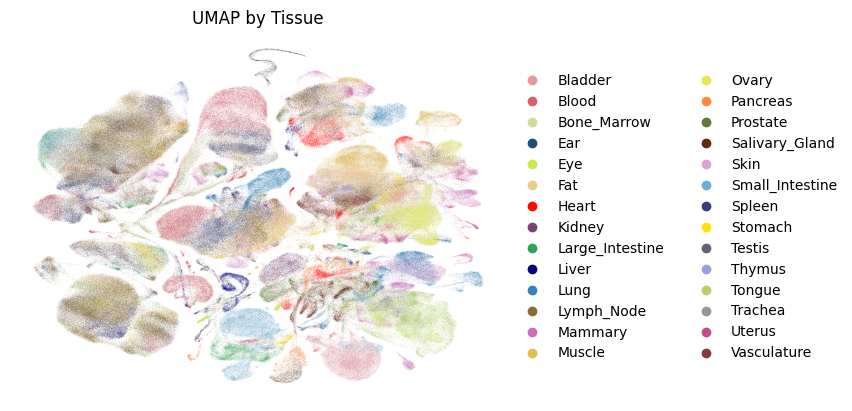

In [189]:
sc.pl.umap(
    adata,
    color='tissue_in_publication',
    legend_loc='right margin',  # or 'right margin' for large datasets
    size=0.1,  # reduce for large datasets
    title='UMAP by Tissue',
    frameon=False
)


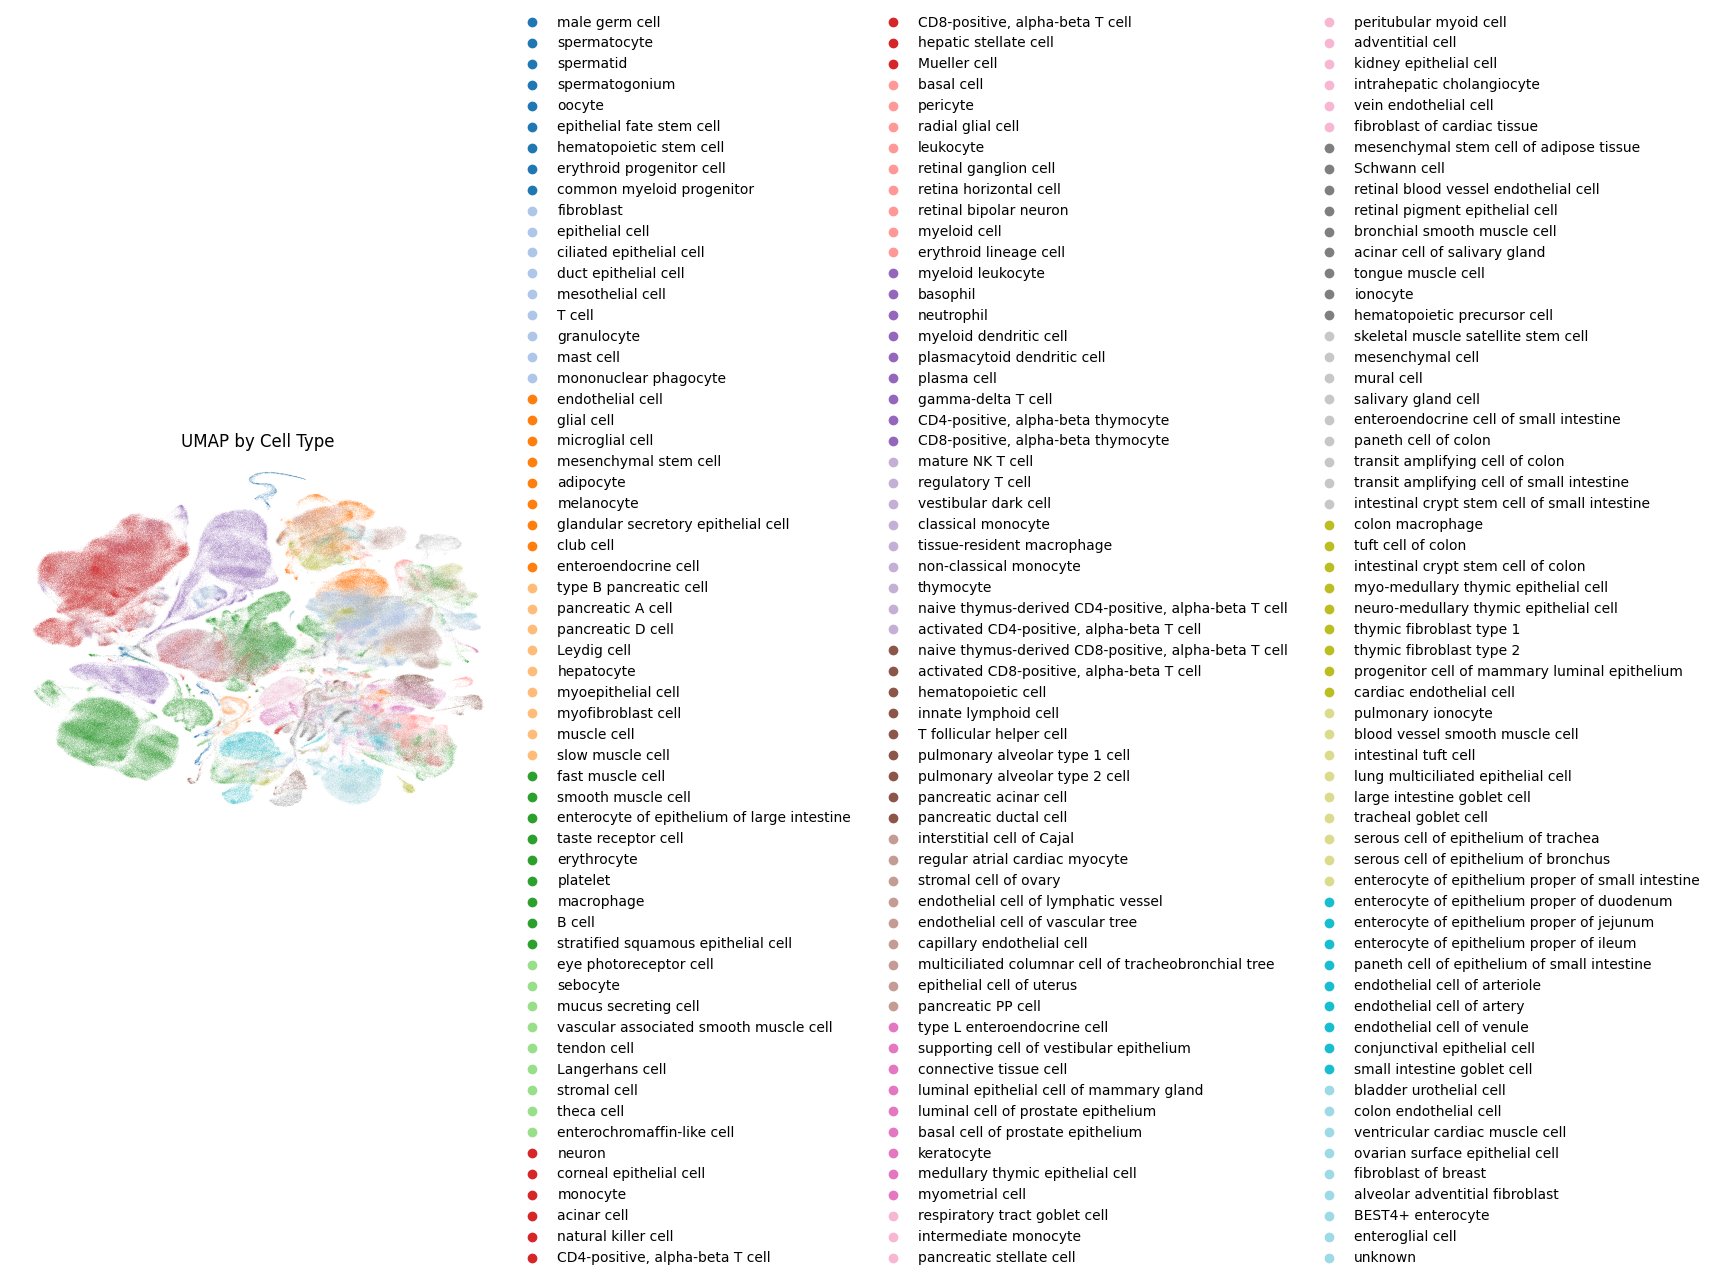

In [56]:
sc.pl.umap(
    adata,
    color='cell_type',
    legend_loc='right margin',  # or 'right margin' for large datasets
    size=0.1,  # reduce for large datasets
    title='UMAP by Cell Type',
    frameon=False
)
